<h2>Loading dataset</h2>

The OBBans library used below is written by the dataset creators for the ease of importing and visualizing it.

In [1]:
from obb_anns import OBBAnns
o = OBBAnns('data/ds2_dense/deepscores_train.json')
o.load_annotations()

c:\users\danyl\obb_anns\obb_anns\obb_anns.py:29: UserWarning: polyiou was not found. Running with no support for metric calculations.
  warnings.warn(warning_string)


loading ann_info...
done! t=12.57s


In [7]:
type(o)

obb_anns.obb_anns.OBBAnns

In [2]:
def find_images(start, end):
    found = []
    for i in range(start, end):
        try:
            found.append(o.get_img_ann_pair(idxs=[i]))
        except:
            pass
    return found

In [18]:
import numpy as np

def cropp_image_smart(original_bbox, width_of_image=1960, height_of_image=2772):
    bbox = np.array(original_bbox)
    bbox[[1, 3]] = bbox[[1, 3]] * (1300 / height_of_image)
    bbox[[0, 2]] = bbox[[0, 2]] * (1000 / width_of_image)
    
    #print(width_of_image)

    length = np.abs(bbox[2] - bbox[0])
    height = np.abs(bbox[3] - bbox[1])
    new_x1 = max(bbox[0] - 1000 * pow((1 - (length / 1000)), 50) * (length), 0)
    new_x2 = min(bbox[2] + 1000 * pow((1 - (length / 1000)), 50) * (length), 999)
    new_y1 = max(bbox[1] - 1000 * pow((1 - (height / 1300)), 50) * (height), 0)
    new_y2 = min(bbox[3] + 1000 * pow((1 - (height / 1300)), 50) * (height), 1299)
    
    return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

In [8]:
find_images(1, 3)[0][1][0]

a_bbox  \
435136    [93.0, 167.0, 1866.0, 234.0]   
435137    [93.0, 702.0, 1866.0, 769.0]   
435138  [1805.0, 784.0, 1837.0, 787.0]   
435139  [1708.0, 784.0, 1739.0, 787.0]   
435140  [1610.0, 784.0, 1641.0, 787.0]   
...                                ...   
435979  [790.0, 2019.0, 791.0, 2084.0]   
435980  [740.0, 2044.0, 741.0, 2084.0]   
435981  [740.0, 2542.0, 761.0, 2559.0]   
435982  [740.0, 2389.0, 761.0, 2406.0]   
435983  [740.0, 2243.0, 761.0, 2260.0]   

                                                   o_bbox      cat_id   area  \
435136  [1866.0, 234.0, 1866.0, 167.0, 93.0, 167.0, 93...  [135, 208]  11995   
435137  [1866.0, 769.0, 1866.0, 702.0, 93.0, 702.0, 93...  [135, 208]  12904   
435138  [1837.0, 787.0, 1837.0, 784.0, 1805.0, 784.0, ...    [2, 138]     51   
435139  [1739.0, 787.0, 1739.0, 784.0, 1708.0, 784.0, ...    [2, 138]     47   
435140  [1641.0, 787.0, 1641.0, 784.0, 1610.0, 784.0, ...    [2, 138]     47   
...                                                   ...         ...    ...   
435979  [791.0, 2084.0, 791.0, 2019.0, 790.0, 2019.0, ...   [42, 161]    132   
435980  [741.0, 2084.0, 741.0, 2044.0, 740.0, 2044.0, ...   [42, 161]     82   
435981  [763.800048828125, 2552.60009765625, 757.0, 25...   [25, 157]    287   
435982  [764.0, 2399.0, 757.2000122070312, 2385.399902...   [27, 157]    289   
435983  [763.5, 2249.5, 752.5, 2238.5, 737.0, 2254.0, ...   [27, 157]    289   

       img_id                                      comments  
435136      4                             instance:#000006;  
435137      4                             instance:#000017;  
435138      4                             instance:#000018;  
435139      4                             instance:#000019;  
435140      4                             instance:#00001a;  
...       ...                                           ...  
435979      4                             instance:#0003b4;  
435980      4                             instance:#0003b5;  
435981      4   instance:#0003b6;duration:4;rel_position:6;  
435982      4   instance:#0003b7;duration:4;rel_position:3;  
435983      4  instance:#0003b8;duration:4;rel_position:-1;  

[848 rows x 6 columns]

In [124]:
from PIL import Image
import random

def dataset_generator(start, end):
    found = find_images(start, end)
    ground_im = Image.new("RGB", (128, 128), (255, 255, 255))
    ground_mask = Image.new("L", (128, 128), (0,))
    for entry in found:
        img, props = entry[0][0], entry[1][0]
        #print(props)
        image = Image.open(f"data/ds2_dense/images/{img['filename']}")
        segm = img['filename'].split('.')
        print(segm[0] + '_seg.' + segm[1])
        mask = Image.open(f"data/ds2_dense/segmentation/{segm[0] + '_seg.' + segm[1]}")
        width, height = image.size
        image = image.resize((1000, 1300))
        mask = mask.resize((1000, 1300))
        pairs = props['a_bbox']
        print(pairs)
        pairs = pairs.sample(n=1).reset_index(drop=True)
        #print(pairs)
        print("here")
        for bbox in pairs.iterrows():
            print("here")
            symbol = cropp_image_smart(bbox, width, height)
            image_cr = image.crop(symbol)
            #mask = np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
            mask_cr = np.array(list(map(lambda index: mapping[index], np.array(mask.crop(symbol)))))
            mask_cr = mask_cr / 255
            #yield np.expand_dims(image.crop(symbol), axis=0), np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
            print(type(image_cr[0]))
            #plt.imshow(image_cr[0])
            ground_im.paste(Image.fromarray(image_cr), (0, 0))
            plt.imshow(ground_im)
            plt.show()
            print(image_cr)
            ground_mask.paste(Image.fromarray(mask_cr), (0, 0))
            plt.imshow(ground_mask)
            plt.show()
            #ground_mask = 
            yield np.expand_dims(ground_im, axis=0), np.expand_dims(np.expand_dims(ground_mask, axis=-1), axis=0)
            ground_im = Image.new("RGB", (128, 128), (255, 255, 255))
            ground_mask = Image.new("L", (128, 128), (0,))

In [5]:
import pandas as pd
found = find_images(0, 500)
#print(type(found))

df_train = pd.DataFrame()
for entry in found:
    df2_train = entry[1][0]
    df2_train['filename'] = entry[0][0]['filename']
    df2_train['cat_id'] = df2_train['cat_id'].apply(lambda x: x[0])
    df_train = df_train.append(df2_train)

In [6]:
found = find_images(900, 1000)
#print(type(found))
df_val = pd.DataFrame()
for entry in found:
    df2_val = entry[1][0]
    df2_val['filename'] = entry[0][0]['filename']
    df2_val['cat_id'] = df2_val['cat_id'].apply(lambda x: x[0])
    df_val = df_val.append(df2_val)

In [12]:
for i in range(1, 137):
    display(df_train[df_train['cat_id'] == i].sample(1))

a_bbox  \
344011  [73.0, 126.0, 88.0, 356.0]   

                                                   o_bbox  cat_id  area  \
344011  [88.00434112548828, 126.00437927246094, 73.502...       1   991   

       img_id           comments  \
344011   1078  instance:#000065;   

                                                filename  
344011  lg-263172443869766193-aug-emmentaler--page-2.png

a_bbox  \
274952  [811.0, 1186.0, 841.0, 1189.0]   

                                                   o_bbox  cat_id  area  \
274952  [841.0, 1189.0, 841.0, 1186.0, 811.0, 1186.0, ...       2    44   

       img_id           comments                                 filename  
274952    145  instance:#000226;  lg-594478153613956586-aug-gonville-.png

a_bbox  \
838721  [1379.0, 1111.0, 1385.0, 1118.0]   

                                                   o_bbox  cat_id  area  \
838721  [1385.0, 1111.0, 1379.0, 1111.0, 1379.0, 1118....       3    42   

       img_id           comments                                 filename  
838721    642  instance:#000115;  lg-138276217-aug-emmentaler--page-2.png

a_bbox  \
276012  [295.0, 173.0, 336.0, 234.0]   

                                                   o_bbox  cat_id  area  \
276012  [336.0, 173.0, 295.0, 173.0, 295.0, 234.0, 336...       4  1199   

       img_id           comments  \
276012   1026  instance:#000060;   

                                               filename  
276012  lg-808535147666906326-aug-beethoven--page-1.png

a_bbox  \
232512  [575.0, 1397.0, 619.0, 1455.0]   

                                                   o_bbox  cat_id  area  \
232512  [625.0, 1434.0, 597.1600341796875, 1396.880004...       5   691   

       img_id           comments  \
232512   1259  instance:#00035b;   

                                               filename  
232512  lg-83301893611632707-aug-emmentaler--page-2.png

a_bbox  \
223498  [107.0, 1834.0, 153.0, 1976.0]   

                                                   o_bbox  cat_id  area  \
223498  [165.79449462890625, 1841.2183837890625, 121.2...       6  1994   

       img_id           comments                              filename  
223498    958  instance:#0002c9;  lg-48560814-aug-lilyjazz--page-2.png

a_bbox  \
315848  [119.0, 1680.0, 169.0, 1769.0]   

                                                   o_bbox  cat_id  area  \
315848  [169.83114624023438, 1768.349853515625, 166.91...       7  2136   

       img_id           comments  \
315848     53  instance:#0002d9;   

                                               filename  
315848  lg-523155381240242384-aug-lilyjazz--page-41.png

a_bbox  \
414202  [1443.0, 2538.0, 1483.0, 2610.0]   

                                                   o_bbox  cat_id  area  \
414202  [1484.0191650390625, 2609.479248046875, 1481.1...       8  1587   

       img_id           comments  \
414202   1121  instance:#00031c;   

                                              filename  
414202  lg-136961156018845714-aug-lilyjazz--page-2.png

a_bbox  \
134600  [118.0, 2022.0, 161.0, 2072.0]   

                                                   o_bbox  cat_id  area  \
134600  [161.6517791748047, 2022.580810546875, 119.269...       9   651   

       img_id           comments  \
134600    250  instance:#000286;   

                                                 filename  
134600  lg-523155381240242384-aug-emmentaler--page-18.png

ValueError: a must be greater than 0 unless no samples are taken

In [30]:
from PIL import Image
import random
import pandas as pd

def dataset_generator(type_of_dataset):
    if(type_of_dataset == 'train'):
        df = df_train
    else:
        df = df_val
    ground_im = Image.new("RGB", (1000, 1000), (255, 255, 255))
    ground_mask = Image.new("L", (1000, 1000), 0)
    cat_id = 1
    while True:
        #print(df.head)
        #print(cat_id)
        entry = df[df['cat_id'] == cat_id]
        if(not entry.empty):
            try:
                entry = entry.sample(1)
                image = Image.open(f"data/ds2_dense/images/{entry.iloc[0]['filename']}")
                segm = entry.iloc[0]['filename'].split('.')
                #print(segm[0] + '_seg.' + segm[1])
                mask = Image.open(f"data/ds2_dense/segmentation/{segm[0] + '_seg.' + segm[1]}")
                width, height = image.size
                image = image.resize((1000, 1300))
                mask = mask.resize((1000, 1300))
                pairs = entry.iloc[0][['a_bbox', 'cat_id']]
                #print(pairs)
                #print(pairs)
                symbol = cropp_image_smart(entry.iloc[0]['a_bbox'], width, height)
                image_cr = image.crop(symbol)
                #mask = np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
                mask_cr = Image.fromarray(np.array(list(map(lambda index: mapping[index], np.array(mask.crop(symbol))))))
                #mask_cr = mask.crop(symbol)
                #mask_cr = Image.fromarray(np.array(mask.crop(symbol)) / 256)
                #mask_cr = mask_cr / 256
                #yield np.expand_dims(image.crop(symbol), axis=0), np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
                #print(type(image_cr[0]))
                #plt.imshow(image_cr[0])
                ground_im.paste(image_cr, (0, 0))
                ground_mask.paste(mask_cr, (0, 0))
                #ground_mask = 
                yield np.expand_dims(ground_im, axis=0), np.expand_dims(tf.keras.utils.to_categorical(ground_mask, num_classes=137, dtype='float32'), axis=0)
                ground_im = Image.new("RGB", (1000, 1000), (255, 255, 255))
                ground_mask = Image.new("L", (1000, 1000), 0)
                cat_id = cat_id + 1
                if (cat_id == 137):
                    cat_id = 1
            except:
                cat_id = cat_id + 1
                if (cat_id == 137):
                    cat_id = 1
        else:
            cat_id = cat_id + 1
            if (cat_id == 137):
                cat_id = 1            
    

In [31]:
from PIL import Image
import random
import pandas as pd

def dataset_generator(type_of_dataset):
    if(type_of_dataset == 'train'):
        df = df_train
    else:
        df = df_val
    ground_im = Image.new("RGB", (1000, 1000), (255, 255, 255))
    ground_mask = Image.new("L", (1000, 1000), 0)
    cat_id = 1
    while True:
        #print(df.head)
        #print(cat_id)
        entry = df[df['cat_id'] == cat_id]
        if(not entry.empty):
            try:
                entry = entry.sample(1)
                image = Image.open(f"data/ds2_dense/images/{entry.iloc[0]['filename']}")
                segm = entry.iloc[0]['filename'].split('.')
                #print(segm[0] + '_seg.' + segm[1])
                mask = Image.open(f"data/ds2_dense/segmentation/{segm[0] + '_seg.' + segm[1]}")
                width, height = image.size
                image = image.resize((1000, 1300))
                mask = mask.resize((500, 500))
                pairs = entry.iloc[0][['a_bbox', 'cat_id']]
                #print(pairs)
                #print(pairs)
                symbol = cropp_image_smart(entry.iloc[0]['a_bbox'], width, height)
                image_cr = image.crop(symbol)
                #mask = np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
                mask_cr = Image.fromarray(np.array(list(map(lambda index: mapping[index], np.array(mask.crop(symbol))))))
                #mask_cr = mask.crop(symbol)
                #mask_cr = Image.fromarray(np.array(mask.crop(symbol)) / 256)
                #mask_cr = mask_cr / 256
                #yield np.expand_dims(image.crop(symbol), axis=0), np.expand_dims(np.array(list(map(lambda index: mapping[index], np.expand_dims(mask.crop(symbol), axis=-1)))), axis=0)
                #print(type(image_cr[0]))
                #plt.imshow(image_cr[0])
                ground_im.paste(image_cr, (0, 0))
                ground_mask.paste(mask_cr, (0, 0))
                #ground_mask = 
                yield np.expand_dims(ground_im, axis=0), np.expand_dims(tf.keras.utils.to_categorical(ground_mask, num_classes=137, dtype='float32'), axis=0)
                ground_im = Image.new("RGB", (1000, 1000), (255, 255, 255))
                ground_mask = Image.new("L", (1000, 1000), 0)
                cat_id = cat_id + 1
                if (cat_id == 137):
                    cat_id = 1
            except:
                cat_id = cat_id + 1
                if (cat_id == 137):
                    cat_id = 1
        else:
            cat_id = cat_id + 1
            if (cat_id == 137):
                cat_id = 1            
    

In [26]:
import tensorflow as tf

train_data = tf.data.Dataset.from_generator(generator = lambda : dataset_generator('train'), output_signature=(
         tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.int32),
         tf.TensorSpec(shape=(None, None, None, 137), dtype=tf.float32)))
val_data = tf.data.Dataset.from_generator(generator = lambda : dataset_generator('val'), output_signature=(
         tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.int32),
         tf.TensorSpec(shape=(None, None, None, 137), dtype=tf.float32)))

Exception ignored in: <generator object dataset_generator at 0x000001B98BAA0820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


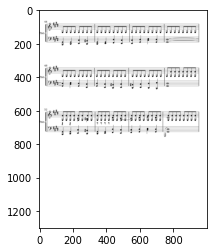

In [27]:
import matplotlib.pyplot as plt

temp = next(iter(train_data))
plt.imshow(temp[0][0])
plt.show()
    #plt.imshow(create_mask(temp[1]))
#plt.show()

In [63]:
print(mapping / 256)

[0.         0.00390625 0.0078125  0.         0.         0.
 0.         0.01171875 0.015625   0.01953125 0.0234375  0.02734375
 0.03125    0.03515625 0.0390625  0.         0.         0.
 0.         0.04296875 0.046875   0.05078125 0.0546875  0.05859375
 0.0625     0.06640625 0.0703125  0.07421875 0.078125   0.08203125
 0.0859375  0.         0.         0.08984375 0.09375    0.09765625
 0.1015625  0.10546875 0.109375   0.11328125 0.1171875  0.12109375
 0.125      0.12890625 0.1328125  0.13671875 0.140625   0.14453125
 0.1484375  0.15234375 0.15625    0.16015625 0.1640625  0.16796875
 0.171875   0.17578125 0.1796875  0.18359375 0.1875     0.19140625
 0.1953125  0.19921875 0.203125   0.20703125 0.2109375  0.21484375
 0.21875    0.22265625 0.2265625  0.23046875 0.234375   0.23828125
 0.2421875  0.24609375 0.25       0.25390625 0.2578125  0.26171875
 0.265625   0.26953125 0.2734375  0.27734375 0.28125    0.28515625
 0.2890625  0.29296875 0.296875   0.30078125 0.3046875  0.30859375
 0.3125    

The categories of symbols are loaded from the json file given along with the dataset. These categories will later be used to map an 8-bit grayscale image into a 136-channel image for more efficient segmentation.

In [4]:
import numpy as np

categories = o.get_cats()
#print(categories)
number = {num: data['color'] for num, data in categories.items() if (data['annotation_set'] == 'deepscores') }
print(len(number))
mapping = np.zeros(256)
i = 1
for key, val in number.items():
    mapping[val] = i
    i = i + 1
mapping

136


array([  0.,   1.,   2.,   0.,   0.,   0.,   0.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,   0.,   0.,   0.,   0.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,   0.,   0.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,   0.,   0.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120.,   0., 121., 122., 123.,   0., 127., 12

<h2>Model creation</h2>

Unet with a mobilenet backbone for efficient work of the model on mobile devices.

In [52]:
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2D, BatchNormalization, Activation
from random import randrange
import numpy, elasticdeform
import random
from PIL import Image

tf.compat.v1.enable_eager_execution()

tf.keras.backend.set_floatx('float64')
#tf.enable_eager_execution()

np.random.seed(42)
tf.random.set_seed(42)

CUT_SIZE = 128
BATCH_SIZE = 1
LR = 1e-4
EPOCHS = 30


def load_data(path, split=0.12):
    images = sorted(glob(os.path.join(path, 'images/*')))
    masks = sorted(glob(os.path.join(path, 'segmentation/*')))

    X_train, X_val = train_test_split(images, test_size=split, random_state=42)
    y_train, y_val = train_test_split(masks, test_size=split, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=split, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=split, random_state=42)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data('data\\ds2_dense\\')
print(len(X_train))
print(len(X_val))
print(len(X_test))

def read_image(path):
    #path = path.decode()
    image = Image.open(path)
    #x = cv2.imread(path, cv2.IMREAD_COLOR)
    image = image.resize((1152, 1920))
    return image

def read_mask(path):
    #path = path.decode()
    x = Image.open(path)
    x = x.resize((1152, 1920), Image.NEAREST)
    #x = x/255
    x = np.expand_dims(x, axis=-1)
    x = np.array(list(map(lambda index : mapping[index], x)))
    print(x.shape)
    plt.imsave('colors.png', np.squeeze(x))
    plt.show()
    #print(type(x))
    return x

print(X_train[2])


def tf_parse(x, y):
    def parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        #x, y = elasticdeform.deform_random_grid([x, y], axis=[(0, 1), (0, 1)], sigma=random.choice([randrange(25), 0]), points=3)
        #x[x > 1] = 1 
        #y[y > 1] = 1
        x = split_image(tf.convert_to_tensor(x, dtype=tf.float32), (CUT_SIZE, CUT_SIZE))
        #print(x)
        #print("HEEEEEERE\n\n\n\\n\\n\n\n\n\n\n\n\n\n\n\n\n\n")
        #y = split_image(y, (CUT_SIZE, CUT_SIZE))
        new = [y[i:i + CUT_SIZE, j:j + CUT_SIZE] for j in range(0, y.shape[1], CUT_SIZE) for i in range(0, y.shape[0], CUT_SIZE)]

        return x, tf.convert_to_tensor(new, dtype=tf.float32)

    def split_image(image3, tile_size):
        image_shape = tf.shape(image3)
        tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
        serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
        return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])

    def split_image2(image3, tile_size):
        image_shape = tf.shape(image3)
        tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1]])
        serial_tiles = tf.transpose(tile_rows, [1, 0, 2])
        return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0]])

    for trn, vl in zip(x, y):
        x, y = parse(trn, vl)    #trn, vl = tf.numpy_function(parse, [x, y], [tf.float32, tf.float64])
        #print(x)
        x.set_shape([None, CUT_SIZE, CUT_SIZE, 3])
        y.set_shape([None, CUT_SIZE, CUT_SIZE, 1])
        #rand_choice = [random.randint(1, 10), random.randint(1, 20), random.randint(1, 20), random.randint(1, 20)]
        for i in [k + 1 + (j * 15) for j in range(9) for k in range(4)]:
            yield x[i], y[i]
    #return x[0:int((len(x)/12))], y[0:int((len(y)/12))]
    #return x[3:4], y[3:4]

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_generator(lambda: tf_parse(x, y), output_signature=(
         tf.TensorSpec(shape=(CUT_SIZE, CUT_SIZE, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(CUT_SIZE, CUT_SIZE, 1), dtype=tf.float32)))
    #dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_dataset = tf_dataset(X_train, y_train, batch=BATCH_SIZE)
valid_dataset = tf_dataset(X_val, y_val, batch=BATCH_SIZE)

def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

base_model = tf.keras.applications.MobileNetV2(input_shape=[CUT_SIZE, CUT_SIZE, 3], include_top=False, weights=None, alpha=1.2)

#base_model.summary()
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
#down_stack.summary()

from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64

]

def unet_model(output_channels: int):
  inputs = tf.keras.layers.Input(shape=[CUT_SIZE, CUT_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 137

model = unet_model(output_channels=OUTPUT_CLASSES)
model.summary()
model.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.00012),
              tf.keras.optimizers.SGD(lr=0.0001,momentum=.9,nesterov=False),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=custom_loss,
              metrics=['accuracy'],
              run_eagerly=False)

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    BATCH_SIZE = 64
    BUFFER_SIZE = 1000
    STEPS_PER_EPOCH = 10

    train_batches = (
        train_dataset
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .repeat()
            .prefetch(buffer_size=tf.data.AUTOTUNE))

EPOCHS = 7
VAL_SUBSPLITS = 5

#print(next(iter(train_dataset))[1][1])

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([0.01 if i == 0 else 1 for i in range(1, 137)])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

model_history = model.fit(train_dataset, epochs=10,
                          steps_per_epoch=135,
                          validation_steps=50,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

1327
206
181
data\ds2_dense\images\lg-55859018-aug-beethoven--page-2.png
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_54 (Functional)           [(None, 64, 64, 144) 2632928     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1771520     model_54[0][4]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1184)   0           sequential[0][0]                 
                  

C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: in user code:

    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    <ipython-input-50-63c7503bf692>:37 custom_loss  *
        if(tf.equal(tf.size(tf.boolean_mask(layer, mask)), 0)):
    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\array_ops.py:1922 boolean_mask_v2
        return boolean_mask(tensor, mask, name, axis)
    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\array_ops.py:1842 boolean_mask
        shape_tensor[axis:axis + ndims_mask].assert_is_compatible_with(shape_mask)
    C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 128, 128) and (128, 128, 1) are incompatible


In [14]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
sm.set_framework('tf.keras')
sm.framework()
tf.keras.backend.set_floatx('float32')

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data

# preprocess input

# define model
resnet_model = Unet(BACKBONE, activation='softmax', encoder_weights='imagenet', classes=137)
#inputs = model.layers[0]
#resnet_model = model_initial.layers[-2]
#print(type(model))
#resnet_model = tf.keras.layers.Softmax()(resnet_model.output)
#resnet_model = tf.keras.Model(model_initial.input, resnet_model)

resnet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=custom_loss, metrics=[iou_score, 'accuracy'], run_eagerly=False)
print(resnet_model.summary())
# fit model
history_resnet_model = resnet_model.fit(train_data, epochs=50,
                          batch_size=1,
                          steps_per_epoch=135,
                          validation_steps=50,
                          validation_data=val_data)

Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
______________________________________________

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
135/135 [==============================] - ETA: 0s - loss: 116853.6250 - iou_score: 2.8996e-04 - accuracy: 0.1903

Exception ignored in: <generator object dataset_generator at 0x000001B99F323190>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 73s 467ms/step - loss: 116853.6250 - iou_score: 2.8996e-04 - accuracy: 0.1903 - val_loss: 132081.6875 - val_iou_score: 4.1098e-04 - val_accuracy: 0.3247
Epoch 2/50
135/135 [==============================] - ETA: 0s - loss: 78452.6484 - iou_score: 6.5488e-04 - accuracy: 0.8731

Exception ignored in: <generator object dataset_generator at 0x000001B99F323120>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 463ms/step - loss: 78452.6484 - iou_score: 6.5488e-04 - accuracy: 0.8731 - val_loss: 96205.1406 - val_iou_score: 8.5663e-04 - val_accuracy: 0.8250
Epoch 3/50
135/135 [==============================] - ETA: 0s - loss: 55594.5195 - iou_score: 0.0015 - accuracy: 0.9391

Exception ignored in: <generator object dataset_generator at 0x000001B99F453EB0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 459ms/step - loss: 55594.5195 - iou_score: 0.0015 - accuracy: 0.9391 - val_loss: 54246.5234 - val_iou_score: 0.0019 - val_accuracy: 0.9455
Epoch 4/50
135/135 [==============================] - ETA: 0s - loss: 33226.1992 - iou_score: 0.0032 - accuracy: 0.9431

Exception ignored in: <generator object dataset_generator at 0x000001B99F5B9EB0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 459ms/step - loss: 33226.1992 - iou_score: 0.0032 - accuracy: 0.9431 - val_loss: 32793.9688 - val_iou_score: 0.0036 - val_accuracy: 0.9436
Epoch 5/50
135/135 [==============================] - ETA: 0s - loss: 22603.4473 - iou_score: 0.0050 - accuracy: 0.9440

Exception ignored in: <generator object dataset_generator at 0x000001B9A13EBC10>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 454ms/step - loss: 22603.4473 - iou_score: 0.0050 - accuracy: 0.9440 - val_loss: 25057.4473 - val_iou_score: 0.0048 - val_accuracy: 0.9513
Epoch 6/50
135/135 [==============================] - ETA: 0s - loss: 17668.7812 - iou_score: 0.0063 - accuracy: 0.9505

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 469ms/step - loss: 17668.7812 - iou_score: 0.0063 - accuracy: 0.9505 - val_loss: 20156.0410 - val_iou_score: 0.0061 - val_accuracy: 0.9574
Epoch 7/50
135/135 [==============================] - ETA: 0s - loss: 15146.8477 - iou_score: 0.0077 - accuracy: 0.9553

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 458ms/step - loss: 15146.8477 - iou_score: 0.0077 - accuracy: 0.9553 - val_loss: 15475.1064 - val_iou_score: 0.0077 - val_accuracy: 0.9610
Epoch 8/50
135/135 [==============================] - ETA: 0s - loss: 13298.8955 - iou_score: 0.0088 - accuracy: 0.9599

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 465ms/step - loss: 13298.8955 - iou_score: 0.0088 - accuracy: 0.9599 - val_loss: 14471.3965 - val_iou_score: 0.0088 - val_accuracy: 0.9626
Epoch 9/50
135/135 [==============================] - ETA: 0s - loss: 11495.2959 - iou_score: 0.0098 - accuracy: 0.9641

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 451ms/step - loss: 11495.2959 - iou_score: 0.0098 - accuracy: 0.9641 - val_loss: 11697.5566 - val_iou_score: 0.0106 - val_accuracy: 0.9619
Epoch 10/50
135/135 [==============================] - ETA: 0s - loss: 11019.3574 - iou_score: 0.0110 - accuracy: 0.9631

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 461ms/step - loss: 11019.3574 - iou_score: 0.0110 - accuracy: 0.9631 - val_loss: 10485.3428 - val_iou_score: 0.0111 - val_accuracy: 0.9678
Epoch 11/50
135/135 [==============================] - ETA: 0s - loss: 10234.3086 - iou_score: 0.0121 - accuracy: 0.9651

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 458ms/step - loss: 10234.3086 - iou_score: 0.0121 - accuracy: 0.9651 - val_loss: 10149.2227 - val_iou_score: 0.0112 - val_accuracy: 0.9724
Epoch 12/50
135/135 [==============================] - ETA: 0s - loss: 9049.1123 - iou_score: 0.0131 - accuracy: 0.9688

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 468ms/step - loss: 9049.1123 - iou_score: 0.0131 - accuracy: 0.9688 - val_loss: 9409.1191 - val_iou_score: 0.0131 - val_accuracy: 0.9701
Epoch 13/50
135/135 [==============================] - ETA: 0s - loss: 8462.4600 - iou_score: 0.0139 - accuracy: 0.9703

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 469ms/step - loss: 8462.4600 - iou_score: 0.0139 - accuracy: 0.9703 - val_loss: 8836.5127 - val_iou_score: 0.0141 - val_accuracy: 0.9689
Epoch 14/50
135/135 [==============================] - ETA: 0s - loss: 7919.8706 - iou_score: 0.0144 - accuracy: 0.9732

Exception ignored in: <generator object dataset_generator at 0x000001B9ACBBBAC0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 457ms/step - loss: 7919.8706 - iou_score: 0.0144 - accuracy: 0.9732 - val_loss: 8237.8818 - val_iou_score: 0.0151 - val_accuracy: 0.9713
Epoch 15/50
135/135 [==============================] - ETA: 0s - loss: 7316.1787 - iou_score: 0.0160 - accuracy: 0.9741

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 453ms/step - loss: 7316.1787 - iou_score: 0.0160 - accuracy: 0.9741 - val_loss: 7962.5518 - val_iou_score: 0.0154 - val_accuracy: 0.9724
Epoch 16/50
135/135 [==============================] - ETA: 0s - loss: 7484.7876 - iou_score: 0.0159 - accuracy: 0.9742

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 459ms/step - loss: 7484.7876 - iou_score: 0.0159 - accuracy: 0.9742 - val_loss: 10017.1572 - val_iou_score: 0.0153 - val_accuracy: 0.9675
Epoch 17/50
135/135 [==============================] - ETA: 0s - loss: 6960.5850 - iou_score: 0.0173 - accuracy: 0.9752

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 458ms/step - loss: 6960.5850 - iou_score: 0.0173 - accuracy: 0.9752 - val_loss: 8263.1299 - val_iou_score: 0.0170 - val_accuracy: 0.9719
Epoch 18/50
135/135 [==============================] - ETA: 0s - loss: 7031.8228 - iou_score: 0.0181 - accuracy: 0.9742

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 451ms/step - loss: 7031.8228 - iou_score: 0.0181 - accuracy: 0.9742 - val_loss: 8191.0269 - val_iou_score: 0.0172 - val_accuracy: 0.9731
Epoch 19/50
135/135 [==============================] - ETA: 0s - loss: 6706.6797 - iou_score: 0.0187 - accuracy: 0.9754

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 445ms/step - loss: 6706.6797 - iou_score: 0.0187 - accuracy: 0.9754 - val_loss: 7525.7188 - val_iou_score: 0.0185 - val_accuracy: 0.9736
Epoch 20/50
135/135 [==============================] - ETA: 0s - loss: 6527.4536 - iou_score: 0.0192 - accuracy: 0.9756

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 63s 470ms/step - loss: 6527.4536 - iou_score: 0.0192 - accuracy: 0.9756 - val_loss: 6627.2700 - val_iou_score: 0.0186 - val_accuracy: 0.9747
Epoch 21/50
135/135 [==============================] - ETA: 0s - loss: 6535.9907 - iou_score: 0.0193 - accuracy: 0.9761

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 64s 477ms/step - loss: 6535.9907 - iou_score: 0.0193 - accuracy: 0.9761 - val_loss: 7877.1333 - val_iou_score: 0.0181 - val_accuracy: 0.9733
Epoch 22/50
135/135 [==============================] - ETA: 0s - loss: 5935.5806 - iou_score: 0.0204 - accuracy: 0.9779

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 458ms/step - loss: 5935.5806 - iou_score: 0.0204 - accuracy: 0.9779 - val_loss: 5979.8169 - val_iou_score: 0.0205 - val_accuracy: 0.9769
Epoch 23/50
135/135 [==============================] - ETA: 0s - loss: 5912.7368 - iou_score: 0.0211 - accuracy: 0.9776

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 461ms/step - loss: 5912.7368 - iou_score: 0.0211 - accuracy: 0.9776 - val_loss: 6154.8320 - val_iou_score: 0.0196 - val_accuracy: 0.9776
Epoch 24/50
135/135 [==============================] - ETA: 0s - loss: 5498.6450 - iou_score: 0.0224 - accuracy: 0.9785

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 447ms/step - loss: 5498.6450 - iou_score: 0.0224 - accuracy: 0.9785 - val_loss: 5846.6646 - val_iou_score: 0.0209 - val_accuracy: 0.9786
Epoch 25/50
135/135 [==============================] - ETA: 0s - loss: 5429.1592 - iou_score: 0.0219 - accuracy: 0.9801

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 453ms/step - loss: 5429.1592 - iou_score: 0.0219 - accuracy: 0.9801 - val_loss: 6370.4517 - val_iou_score: 0.0216 - val_accuracy: 0.9777
Epoch 26/50
135/135 [==============================] - ETA: 0s - loss: 5262.9658 - iou_score: 0.0232 - accuracy: 0.9798

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 457ms/step - loss: 5262.9658 - iou_score: 0.0232 - accuracy: 0.9798 - val_loss: 5647.6758 - val_iou_score: 0.0233 - val_accuracy: 0.9782
Epoch 27/50
135/135 [==============================] - ETA: 0s - loss: 4954.3120 - iou_score: 0.0241 - accuracy: 0.9814

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 461ms/step - loss: 4954.3120 - iou_score: 0.0241 - accuracy: 0.9814 - val_loss: 6065.2212 - val_iou_score: 0.0221 - val_accuracy: 0.9785
Epoch 28/50
135/135 [==============================] - ETA: 0s - loss: 4615.1206 - iou_score: 0.0245 - accuracy: 0.9825

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 451ms/step - loss: 4615.1206 - iou_score: 0.0245 - accuracy: 0.9825 - val_loss: 5451.6973 - val_iou_score: 0.0238 - val_accuracy: 0.9797
Epoch 29/50
135/135 [==============================] - ETA: 0s - loss: 4618.5054 - iou_score: 0.0253 - accuracy: 0.9824

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 450ms/step - loss: 4618.5054 - iou_score: 0.0253 - accuracy: 0.9824 - val_loss: 6712.3765 - val_iou_score: 0.0244 - val_accuracy: 0.9751
Epoch 30/50
135/135 [==============================] - ETA: 0s - loss: 4842.5952 - iou_score: 0.0255 - accuracy: 0.9818

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 462ms/step - loss: 4842.5952 - iou_score: 0.0255 - accuracy: 0.9818 - val_loss: 5201.1763 - val_iou_score: 0.0247 - val_accuracy: 0.9793
Epoch 31/50
135/135 [==============================] - ETA: 0s - loss: 4698.8638 - iou_score: 0.0268 - accuracy: 0.9813

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 450ms/step - loss: 4698.8638 - iou_score: 0.0268 - accuracy: 0.9813 - val_loss: 5273.8169 - val_iou_score: 0.0238 - val_accuracy: 0.9807
Epoch 32/50
135/135 [==============================] - ETA: 0s - loss: 4501.5908 - iou_score: 0.0265 - accuracy: 0.9828

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 449ms/step - loss: 4501.5908 - iou_score: 0.0265 - accuracy: 0.9828 - val_loss: 7326.2207 - val_iou_score: 0.0237 - val_accuracy: 0.9729
Epoch 33/50
135/135 [==============================] - ETA: 0s - loss: 4287.4453 - iou_score: 0.0280 - accuracy: 0.9827

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 444ms/step - loss: 4287.4453 - iou_score: 0.0280 - accuracy: 0.9827 - val_loss: 5276.3589 - val_iou_score: 0.0274 - val_accuracy: 0.9789
Epoch 34/50
135/135 [==============================] - ETA: 0s - loss: 3894.2500 - iou_score: 0.0287 - accuracy: 0.9842

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 456ms/step - loss: 3894.2500 - iou_score: 0.0287 - accuracy: 0.9842 - val_loss: 4906.0352 - val_iou_score: 0.0272 - val_accuracy: 0.9797
Epoch 35/50
135/135 [==============================] - ETA: 0s - loss: 3917.7092 - iou_score: 0.0298 - accuracy: 0.9843

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 454ms/step - loss: 3917.7092 - iou_score: 0.0298 - accuracy: 0.9843 - val_loss: 4664.4878 - val_iou_score: 0.0275 - val_accuracy: 0.9805
Epoch 36/50
135/135 [==============================] - ETA: 0s - loss: 3960.7458 - iou_score: 0.0298 - accuracy: 0.9835

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 453ms/step - loss: 3960.7458 - iou_score: 0.0298 - accuracy: 0.9835 - val_loss: 4640.7817 - val_iou_score: 0.0272 - val_accuracy: 0.9811
Epoch 37/50
135/135 [==============================] - ETA: 0s - loss: 3461.9343 - iou_score: 0.0309 - accuracy: 0.9852

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 454ms/step - loss: 3461.9343 - iou_score: 0.0309 - accuracy: 0.9852 - val_loss: 4670.3042 - val_iou_score: 0.0293 - val_accuracy: 0.9809
Epoch 38/50
135/135 [==============================] - ETA: 0s - loss: 3605.8799 - iou_score: 0.0321 - accuracy: 0.9842

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 455ms/step - loss: 3605.8799 - iou_score: 0.0321 - accuracy: 0.9842 - val_loss: 4643.4717 - val_iou_score: 0.0296 - val_accuracy: 0.9809
Epoch 39/50
135/135 [==============================] - ETA: 0s - loss: 4009.7805 - iou_score: 0.0313 - accuracy: 0.9835

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 448ms/step - loss: 4009.7805 - iou_score: 0.0313 - accuracy: 0.9835 - val_loss: 4406.3340 - val_iou_score: 0.0303 - val_accuracy: 0.9815
Epoch 40/50
135/135 [==============================] - ETA: 0s - loss: 3246.0107 - iou_score: 0.0325 - accuracy: 0.9860

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 450ms/step - loss: 3246.0107 - iou_score: 0.0325 - accuracy: 0.9860 - val_loss: 4479.6655 - val_iou_score: 0.0311 - val_accuracy: 0.9813
Epoch 41/50
135/135 [==============================] - ETA: 0s - loss: 3424.4395 - iou_score: 0.0331 - accuracy: 0.9849

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 455ms/step - loss: 3424.4395 - iou_score: 0.0331 - accuracy: 0.9849 - val_loss: 5309.6548 - val_iou_score: 0.0316 - val_accuracy: 0.9785
Epoch 42/50
135/135 [==============================] - ETA: 0s - loss: 3329.6719 - iou_score: 0.0331 - accuracy: 0.9855

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 452ms/step - loss: 3329.6719 - iou_score: 0.0331 - accuracy: 0.9855 - val_loss: 4631.5767 - val_iou_score: 0.0330 - val_accuracy: 0.9813
Epoch 43/50
135/135 [==============================] - ETA: 0s - loss: 3441.7874 - iou_score: 0.0342 - accuracy: 0.9843

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 459ms/step - loss: 3441.7874 - iou_score: 0.0342 - accuracy: 0.9843 - val_loss: 4312.3911 - val_iou_score: 0.0318 - val_accuracy: 0.9822
Epoch 44/50
135/135 [==============================] - ETA: 0s - loss: 2882.0798 - iou_score: 0.0354 - accuracy: 0.9868

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 449ms/step - loss: 2882.0798 - iou_score: 0.0354 - accuracy: 0.9868 - val_loss: 4071.9890 - val_iou_score: 0.0318 - val_accuracy: 0.9826
Epoch 45/50
135/135 [==============================] - ETA: 0s - loss: 2804.3567 - iou_score: 0.0350 - accuracy: 0.9876

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 446ms/step - loss: 2804.3567 - iou_score: 0.0350 - accuracy: 0.9876 - val_loss: 4450.2930 - val_iou_score: 0.0309 - val_accuracy: 0.9801
Epoch 46/50
135/135 [==============================] - ETA: 0s - loss: 2798.4072 - iou_score: 0.0366 - accuracy: 0.9872

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 450ms/step - loss: 2798.4072 - iou_score: 0.0366 - accuracy: 0.9872 - val_loss: 3842.5728 - val_iou_score: 0.0335 - val_accuracy: 0.9835
Epoch 47/50
135/135 [==============================] - ETA: 0s - loss: 2825.5129 - iou_score: 0.0358 - accuracy: 0.9875

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 458ms/step - loss: 2825.5129 - iou_score: 0.0358 - accuracy: 0.9875 - val_loss: 4141.0942 - val_iou_score: 0.0362 - val_accuracy: 0.9819
Epoch 48/50
135/135 [==============================] - ETA: 0s - loss: 2804.8894 - iou_score: 0.0362 - accuracy: 0.9870

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 60s 448ms/step - loss: 2804.8894 - iou_score: 0.0362 - accuracy: 0.9870 - val_loss: 4814.3086 - val_iou_score: 0.0324 - val_accuracy: 0.9805
Epoch 49/50
135/135 [==============================] - ETA: 0s - loss: 2553.4744 - iou_score: 0.0371 - accuracy: 0.9877

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 61s 452ms/step - loss: 2553.4744 - iou_score: 0.0371 - accuracy: 0.9877 - val_loss: 4058.4736 - val_iou_score: 0.0346 - val_accuracy: 0.9816
Epoch 50/50
135/135 [==============================] - ETA: 0s - loss: 2502.1799 - iou_score: 0.0384 - accuracy: 0.9878

Exception ignored in: <generator object dataset_generator at 0x000001B9A0DC5350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


135/135 [==============================] - 62s 459ms/step - loss: 2502.1799 - iou_score: 0.0384 - accuracy: 0.9878 - val_loss: 4017.3293 - val_iou_score: 0.0351 - val_accuracy: 0.9828


Exception ignored in: <generator object dataset_generator at 0x000001B9A0D4E580>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


In [65]:
print(train_data.take(1))

<TakeDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.int32, tf.int32)>


In [21]:
resnet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss=custom_loss, metrics=[iou_score, 'accuracy'], run_eagerly=False)
model_history = resnet_model.fit(train_data, epochs=20,
                          batch_size=6,
                          steps_per_epoch=150,
                          validation_steps=50,
                          validation_data=val_data)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 2662.6462 - iou_score: 0.0386 - accuracy: 0.9876

Exception ignored in: <generator object dataset_generator at 0x000001B96E130B30>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 74s 456ms/step - loss: 2662.6462 - iou_score: 0.0386 - accuracy: 0.9876 - val_loss: 4003.5181 - val_iou_score: 0.0363 - val_accuracy: 0.9831
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 3109.1748 - iou_score: 0.0381 - accuracy: 0.9872

Exception ignored in: <generator object dataset_generator at 0x000001B99829D430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 437ms/step - loss: 3109.1748 - iou_score: 0.0381 - accuracy: 0.9872 - val_loss: 3816.6160 - val_iou_score: 0.0365 - val_accuracy: 0.9838
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 2929.7646 - iou_score: 0.0382 - accuracy: 0.9875

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 449ms/step - loss: 2929.7646 - iou_score: 0.0382 - accuracy: 0.9875 - val_loss: 3982.4148 - val_iou_score: 0.0360 - val_accuracy: 0.9831
Epoch 4/20
150/150 [==============================] - ETA: 0s - loss: 2926.0378 - iou_score: 0.0392 - accuracy: 0.9872

Exception ignored in: <generator object dataset_generator at 0x000001B99829D510>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 68s 451ms/step - loss: 2926.0378 - iou_score: 0.0392 - accuracy: 0.9872 - val_loss: 3739.0818 - val_iou_score: 0.0359 - val_accuracy: 0.9839
Epoch 5/20
150/150 [==============================] - ETA: 0s - loss: 2255.0676 - iou_score: 0.0388 - accuracy: 0.9893

Exception ignored in: <generator object dataset_generator at 0x000001B99829D430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 69s 458ms/step - loss: 2255.0676 - iou_score: 0.0388 - accuracy: 0.9893 - val_loss: 3448.4524 - val_iou_score: 0.0360 - val_accuracy: 0.9849
Epoch 6/20
150/150 [==============================] - ETA: 0s - loss: 2639.2837 - iou_score: 0.0387 - accuracy: 0.9880

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 447ms/step - loss: 2639.2837 - iou_score: 0.0387 - accuracy: 0.9880 - val_loss: 3705.6182 - val_iou_score: 0.0358 - val_accuracy: 0.9837
Epoch 7/20
150/150 [==============================] - ETA: 0s - loss: 2441.6982 - iou_score: 0.0388 - accuracy: 0.9888

Exception ignored in: <generator object dataset_generator at 0x000001B99829D270>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 447ms/step - loss: 2441.6982 - iou_score: 0.0388 - accuracy: 0.9888 - val_loss: 3687.9824 - val_iou_score: 0.0341 - val_accuracy: 0.9841
Epoch 8/20
150/150 [==============================] - ETA: 0s - loss: 2346.6777 - iou_score: 0.0398 - accuracy: 0.9887

Exception ignored in: <generator object dataset_generator at 0x000001B99829D350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 440ms/step - loss: 2346.6777 - iou_score: 0.0398 - accuracy: 0.9887 - val_loss: 3753.7397 - val_iou_score: 0.0369 - val_accuracy: 0.9834
Epoch 9/20
150/150 [==============================] - ETA: 0s - loss: 2407.2808 - iou_score: 0.0401 - accuracy: 0.9885

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 447ms/step - loss: 2407.2808 - iou_score: 0.0401 - accuracy: 0.9885 - val_loss: 3249.3784 - val_iou_score: 0.0356 - val_accuracy: 0.9854
Epoch 10/20
150/150 [==============================] - ETA: 0s - loss: 2222.4741 - iou_score: 0.0398 - accuracy: 0.9899

Exception ignored in: <generator object dataset_generator at 0x000001B99829D270>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 442ms/step - loss: 2222.4741 - iou_score: 0.0398 - accuracy: 0.9899 - val_loss: 3640.5278 - val_iou_score: 0.0354 - val_accuracy: 0.9843
Epoch 11/20
150/150 [==============================] - ETA: 0s - loss: 2405.5066 - iou_score: 0.0397 - accuracy: 0.9885

Exception ignored in: <generator object dataset_generator at 0x000001B99829D350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 443ms/step - loss: 2405.5066 - iou_score: 0.0397 - accuracy: 0.9885 - val_loss: 3729.4556 - val_iou_score: 0.0355 - val_accuracy: 0.9842
Epoch 12/20
150/150 [==============================] - ETA: 0s - loss: 2448.7061 - iou_score: 0.0398 - accuracy: 0.9888

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 442ms/step - loss: 2448.7061 - iou_score: 0.0398 - accuracy: 0.9888 - val_loss: 3511.4709 - val_iou_score: 0.0367 - val_accuracy: 0.9846
Epoch 13/20
150/150 [==============================] - ETA: 0s - loss: 2304.9604 - iou_score: 0.0398 - accuracy: 0.9893

Exception ignored in: <generator object dataset_generator at 0x000001B99829D270>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 68s 452ms/step - loss: 2304.9604 - iou_score: 0.0398 - accuracy: 0.9893 - val_loss: 3418.9990 - val_iou_score: 0.0372 - val_accuracy: 0.9836
Epoch 14/20
150/150 [==============================] - ETA: 0s - loss: 2209.0735 - iou_score: 0.0401 - accuracy: 0.9893

Exception ignored in: <generator object dataset_generator at 0x000001B99829D350>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 65s 435ms/step - loss: 2209.0735 - iou_score: 0.0401 - accuracy: 0.9893 - val_loss: 3590.5811 - val_iou_score: 0.0356 - val_accuracy: 0.9842
Epoch 15/20
150/150 [==============================] - ETA: 0s - loss: 2171.9709 - iou_score: 0.0396 - accuracy: 0.9897

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 446ms/step - loss: 2171.9709 - iou_score: 0.0396 - accuracy: 0.9897 - val_loss: 3584.1506 - val_iou_score: 0.0370 - val_accuracy: 0.9841
Epoch 16/20
150/150 [==============================] - ETA: 0s - loss: 2317.1174 - iou_score: 0.0401 - accuracy: 0.9890

Exception ignored in: <generator object dataset_generator at 0x000001B99829D270>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 68s 455ms/step - loss: 2317.1174 - iou_score: 0.0401 - accuracy: 0.9890 - val_loss: 3346.1719 - val_iou_score: 0.0377 - val_accuracy: 0.9844
Epoch 17/20
150/150 [==============================] - ETA: 0s - loss: 2248.0862 - iou_score: 0.0402 - accuracy: 0.9892

Exception ignored in: <generator object dataset_generator at 0x000001B99829DAC0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 446ms/step - loss: 2248.0862 - iou_score: 0.0402 - accuracy: 0.9892 - val_loss: 3503.0078 - val_iou_score: 0.0366 - val_accuracy: 0.9844
Epoch 18/20
150/150 [==============================] - ETA: 0s - loss: 1957.5394 - iou_score: 0.0407 - accuracy: 0.9903

Exception ignored in: <generator object dataset_generator at 0x000001B99829D820>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 66s 440ms/step - loss: 1957.5394 - iou_score: 0.0407 - accuracy: 0.9903 - val_loss: 2978.0249 - val_iou_score: 0.0365 - val_accuracy: 0.9856
Epoch 19/20
150/150 [==============================] - ETA: 0s - loss: 2170.4424 - iou_score: 0.0397 - accuracy: 0.9898

Exception ignored in: <generator object dataset_generator at 0x000001B99829DAC0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 445ms/step - loss: 2170.4424 - iou_score: 0.0397 - accuracy: 0.9898 - val_loss: 3840.4624 - val_iou_score: 0.0379 - val_accuracy: 0.9831
Epoch 20/20
150/150 [==============================] - ETA: 0s - loss: 2282.2561 - iou_score: 0.0404 - accuracy: 0.9894

Exception ignored in: <generator object dataset_generator at 0x000001B99829D430>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


150/150 [==============================] - 67s 447ms/step - loss: 2282.2561 - iou_score: 0.0404 - accuracy: 0.9894 - val_loss: 3531.1843 - val_iou_score: 0.0368 - val_accuracy: 0.9844


Exception ignored in: <generator object dataset_generator at 0x000001B99829D4A0>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


In [34]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
sm.set_framework('tf.keras')
sm.framework()
tf.keras.backend.set_floatx('float32')

BACKBONE = 'mobilenet'
preprocess_input = get_preprocessing(BACKBONE)

# load your data

# preprocess input

# define model
model_initial = Unet(BACKBONE, encoder_weights='imagenet', classes=137)
#inputs = model.layers[0]
model_mobilenet_2 = model_initial.layers[-2]
#print(type(model))
model_mobilenet_2 = tf.keras.layers.Softmax()(model_mobilenet_2.output)
model_mobilenet_2 = tf.keras.Model(model_initial.input, model_mobilenet_2)

model_mobilenet_2.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss=custom_loss, metrics=[iou_score, 'accuracy'], run_eagerly=True)
print(model_mobilenet_2.summary())
# fit model
model_history_mobilenet_2 = model_mobilenet_2.fit(train_data, epochs=50,
                          batch_size=1,
                          steps_per_epoch=135,
                          validation_steps=50,
                          validation_data=val_data)

c:\program files\python39\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 3 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 3 128         conv1[0][0]                      
___________________________________________________________________________________________

ResourceExhaustedError: OOM when allocating tensor with shape[1,32,500,500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

In [16]:
recovery = resnet_model

In [61]:
model.compile('Adam', loss=custom_loss, metrics=[iou_score, 'accuracy'], run_eagerly=False)

model_history_mobilenet_3 = model_mobilenet_2.fit(train_data, epochs=1,
                          steps_per_epoch=135,
                          validation_steps=50,
                          validation_data=valid_dataset)

NameError: name 'model_mobilenet_2' is not defined

<h1>Adaptive focal loss</h1>

In [13]:
import math
import matplotlib.pyplot as plt
def custom_loss(y_true_batch, y_pred_batch, h=0.87, p_prime_inner=tf.convert_to_tensor(p_prime, tf.float32)):
    expected_accuracy = tf.reduce_mean(y_true_batch * y_pred_batch, axis=[0, 1, 2])
    present_in_true_batch = tf.math.greater(tf.reduce_sum(y_true_batch, axis=[0, 1, 2]), 1)
    p_prime_inner = tf.where(present_in_true_batch, expected_accuracy, p_prime_inner)
    
    p_correct = tf.reduce_mean(tf.gather(p_prime_inner, tf.where(present_in_true_batch)))
    
    
    weight = (tf.math.log(tf.math.maximum((1 - (h * p_correct + (1 - h) * 1)), np.float32(0.0000000001))) / tf.math.log(tf.math.minimum(tf.math.maximum(1 - p_correct, np.float32(0.0000000001)), np.float32(0.9999999999)))) - 1 
    #weight = (tf.math.log((1 - (h * p_correct + (1 - h) * 1))) / tf.math.log(1 - p_correct)) - 1 

    #tf.print(f'\nweight: {weight}')
    focal_real = 2 * tf.math.pow(tf.math.subtract(np.float32(1), y_pred_batch), tf.cast(weight, tf.float32))
    focal_real = focal_real * y_true_batch
    #tf.print(f'any negatives?{tf.reduce_any(tf.math.less(focal_real, 0))}')
    #tf.print(f'any nans?{tf.reduce_any(tf.math.is_nan(focal_real))}')


    #calculations
    l = tf.math.log(y_pred_batch + np.float(1e-30)) * y_true_batch
    #tf.print(f'any nans in l?{tf.reduce_any(tf.math.is_nan(l))}')
    #tf.print(f'any inf l?{tf.reduce_any(tf.math.is_inf(l))}')

    #l = tf.math.multiply(l, y_balance)
    l = l * focal_real
    #tf.print(f'any nans in l?{tf.reduce_any(tf.math.is_nan(l))}')
    #tf.print(f'any nans in p_prime?{tf.reduce_any(tf.math.is_nan(p_prime_inner))}')
    ans = -1 * tf.reduce_sum(l)
    #tf.print(f'any nans in ans?{tf.reduce_any(tf.math.is_nan(ans))}')

    return ans
    

<h1>Simple focal loss</h1>

In [50]:
import math
import matplotlib.pyplot as plt
def focal_loss(y_true_batch, y_pred_batch, weight=6):
    focal_real = 2 * tf.math.pow(tf.math.subtract(np.float32(1), y_pred_batch), tf.cast(weight, tf.float32))
    focal_real = focal_real * y_true_batch
    l = tf.math.log(y_pred_batch + np.float(1e-30)) * y_true_batch
    l = l * focal_real
    return -1 * tf.reduce_sum(l)
    

<h1>Tversky focal loss</h1>

In [35]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=6):
    tv = tversky(y_true, y_pred)
    return tf.pow((1 - tv), gamma)

In [13]:
import math
import matplotlib.pyplot as plt
def custom_loss(y_true_batch, y_pred_batch, h=0.95, p_prime_inner=tf.convert_to_tensor(p_prime)):
    y_true_batch = tf.cast(y_true_batch, tf.int32)
    #tr_np = y_true_batch.numpy()
    #pr_np = y_pred_batch.numpy()
        
    unique_values, idx, counts = tf.unique_with_counts(tf.reshape(y_true_batch,[-1]))
    #unique_values = unique_values - 1
    #upd = np.zeros_like(unique_values)
    for i in range(len(unique_values)):
        true_positive_proportion = counts[i] / (128 * 128)
        true_negative_proportion = 1 - true_positive_proportion
        #print(f'True positives: {true_positive_proportion}')
        
        #print(p_prime.numpy())
        #print(unique_values[i].numpy())
        layer = y_pred_batch[:, :, :, unique_values[i]]
        #print(f'slice: {layer.numpy()}')
        #print(layer)
        #print(layer.shape)
        #print(tr_np.shape)
        #mask = y_true_batch[y_true_batch == unique_values[i] - 1]
        mask_false_positives = tf.math.not_equal(y_true_batch, unique_values[i])
        mask_false_positives = tf.reshape(mask_false_positives, [1, 128, 128])
        
        mask = tf.math.equal(y_true_batch, unique_values[i])
        mask = tf.reshape(mask, [1, 128, 128])
        #print(layer.shape)
        #print(mask.shape)
        #print(tf.print(tf.squeeze(y_true_batch) == unique_values[i]))
        #print(mask)
        #mask = np.array(mask)
        #true_positives = tf.reshape(tf.boolean_mask(layer, mask), [1, 128, 128])
        #true_negatives = tf.reshape(tf.boolean_mask(layer, mask_false_positives), [1, 128, 128])
        #print(f'shapes: {true_positives.shape} , {true_negatives.shape}')
        if(tf.equal(tf.size(tf.boolean_mask(layer, mask)), 0)):
            prob_true_positive = np.float32(0)
            #print("here")
        else:
            prob_true_positive = tf.math.reduce_mean(tf.boolean_mask(layer, mask))
            if tf.math.is_nan(prob_true_positive):
                prob_true_negative = np.float32(0)
            #print(f'True positives: {tf.boolean_mask(layer, mask).numpy()}')
            
        if(tf.equal(tf.size(tf.boolean_mask(layer, mask_false_positives)), 0)):
            prob_true_negative = np.float32(0)
        else:
            prob_true_negative = tf.cast(tf.constant(1), tf.float32) - tf.math.reduce_mean(tf.boolean_mask(layer, mask_false_positives))
            if tf.math.is_nan(prob_true_negative):
                prob_true_negative = np.float32(0)
            #print(f'True positives: {tf.boolean_mask(layer, mask_false_positives).numpy()}')


        #print(prob_true_positive.numpy())
        #print(prob_true_negative.numpy())
        
        prob = (prob_true_positive * tf.cast(true_positive_proportion, tf.float32) + (prob_true_negative * tf.cast(true_negative_proportion, tf.float32))) / 137
        #if(tf.math.is_nan(prob)):
            ##tf.print(f"index:{ unique_values[i]}")
            #tf.print(unique_values[i])
            #tf.print(layer)
            #tf.print(prob_true_positive)
            #tf.print(prob_true_negative)
            #plt.imshow(y_true_batch)
            #tf.print(tf.boolean_mask(layer, mask), summarize=128 * 128)
            #tf.print(tf.boolean_mask(layer, mask_false_positives), summarize=128 * 128)
            #raise ValueError
            #tf.print(true_positive_proportion)
            #tf.print(true_negative_proportion)
            #raise ValueError

        #if(np.isnan(prob.numpy())):
        #    print("here")
        #if(np.isnan(prob.numpy())):
        #    print(f'proportions: {true_positive_proportion} and {true_positive_proportion} \n and {tf.boolean_mask(layer, mask)} and {tf.boolean_mask(layer, mask_false_positives)} ')
        
        #prob = tf.math.reduce_mean(tf.boolean_mask(layer, mask)) / 136
        #prob_1 = tf.math.reduce_mean(tf.boolean_mask(layer, mask))
        #prob = tf.math.reduce_mean(tf.add(tf.boolean_mask(layer, mask), tf.subtract(np.float32(1), tf.boolean_mask(layer, mask_false_positives)))) / 136
        #print(tf.reshape(prob, [-1]).shape)
        #print(prob_1.shape)
        
        #p_prime[i] = tf.math.reduce_mean(layer[layer != 0]) / 136
        #p_prime[i] = tf.math.reduce_mean(tf.boolean_mask(layer, mask))
        #print([[np.float32(i)]], [prob])
        p_prime_inner = tf.tensor_scatter_nd_update(p_prime_inner, [[unique_values[i]]], [prob])
    
    p_correct = tf.math.reduce_mean(tf.gather(p_prime_inner, unique_values))
    #print(p_correct.numpy())
    #weight = tf.math.log(tf.math.maximum(1 - (h * p_correct + (1 - h)), 0.000000000001)) / tf.math.log(tf.math.maximum(1 - p_correct,  0.000000000001)) - 1
    weight = (tf.math.log(tf.math.maximum((1 - (h * p_correct + (1 - h) * 1)), np.float32(0.0000000001))) / tf.math.log(tf.math.minimum(tf.math.maximum(1 - p_correct, np.float32(0.0000000001)), np.float32(0.9999999999)))) - 1 
    #if(tf.math.is_nan(weight)):
    #    tf.print(unique_values)
    #    for val in range(len(unique_values)):
    #        tf.print("index: ", val)
    #        tf.print(y_pred_batch[:, :, :, unique_values[val]])
    #    tf.print(weight)
    #    tf.print(prob_true_positive)
    #    tf.print(prob_true_negative)
    #print(f'\n{weight.numpy()}')
    #print(weight.numpy())
    #print(f'\n{weight}')
    #Focal loss
    #Check for k only for used classes and for all classes
    focal_real = 2 * tf.math.pow(tf.math.subtract(np.float32(1), y_pred_batch), tf.cast(weight, tf.float32))
    focal_real = tf.gather_nd(focal_real, y_true_batch, batch_dims=3)

    #print(weight.numpy())
    
    #median frequency balancing
    #y_balance = tf.gather_nd(weights_3d, y_true_batch, batch_dims=3)
    
    #calculations
    l = tf.math.log(tf.gather_nd(y_pred_batch, y_true_batch, batch_dims=3) + np.float(1e-50))
    #l = tf.math.multiply(l, y_balance)
    l = tf.math.multiply(l, focal_real)
    ans = -1 * tf.math.reduce_sum(l)
    #if(tf.math.is_nan(ans)):
    #    tf.print("answer: ", ans)
    #    tf.print(weight)
    #    tf.print(prob_true_positive)
    #    tf.print(prob_true_negative)
    return ans

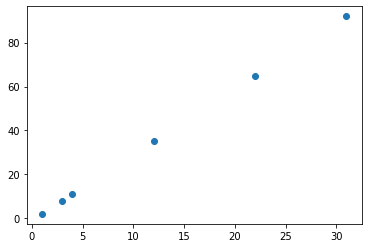

In [2]:
import matplotlib.pyplot as plt
import numpy as np
a = np.array([1, 22, 3, 4, 12, 31])
b = a * 3 - 1
plt.scatter(a, b)
plt.show()


In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.gather_nd(y_pred, y_true, batch_dims=3)
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    y_pred = tf.cast(y_pred, tf.int32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
weights_list = tf.convert_to_tensor(weights_list)

In [ ]:
print([i + (j * 15) for j in range(9) for i in range(4)])

In [ ]:

import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2D, BatchNormalization, Activation
from random import randrange
import numpy, elasticdeform
import random
tf.keras.backend.set_floatx('float64')

tf.compat.v1.enable_eager_execution()

np.random.seed(42)
tf.random.set_seed(42)

CUT_SIZE = 128
BATCH_SIZE = 2
LR = 1e-4
EPOCHS = 30


def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, 'images/*')))
    masks = sorted(glob(os.path.join(path, 'segmentation/*')))

    X_train, X_val = train_test_split(images, test_size=split, random_state=42)
    y_train, y_val = train_test_split(masks, test_size=split, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=split, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=split, random_state=42)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data('data\\ds2_dense\\')
print(len(X_train))
print(len(X_val))
print(len(X_test))

def read_image(path):
    #path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (1152, 1920))
    x = x/255
    return x

def read_mask(path):
    #path = path.decode()
    x = Image.open(path)
    x = x.resize((1152, 1920), Image.NEAREST)
    #x = x/255
    x = np.expand_dims(x, axis=-1)
    #x = np.array(list((lambda index : mapping[index], x)))
    #print(type(x))
    return x


def tf_parse(x, y):
    def parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        #x, y = elasticdeform.deform_random_grid([x, y], axis=[(0, 1), (0, 1)], sigma=random.choice([randrange(25), 0]), points=3)
        #x[x > 1] = 1 
        #y[y > 1] = 1
        x = tf.convert_to_tensor(x, dtype=tf.float64)
        y = tf.convert_to_tensor(y, dtype=tf.float64)
        #print(y)
        #x = split_image(tf.convert_to_tensor(x, dtype=tf.float64), (CUT_SIZE, CUT_SIZE))
        #y = split_image(tf.convert_to_tensor(y, dtype=tf.float64), (CUT_SIZE, CUT_SIZE))

        #print(x)
        #print("HEEEEEERE\n\n\n\\n\\n\n\n\n\n\n\n\n\n\n\n\n\n")
        #y = split_image(y, (CUT_SIZE, CUT_SIZE))
        #new = [y[i:i + CUT_SIZE, j:j + CUT_SIZE] for j in range(0, y.shape[1], CUT_SIZE) for i in range(0, y.shape[0], CUT_SIZE)]

        return x, y

    def split_image(image3, tile_size):
        image_shape = tf.shape(image3)
        tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
        serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
        return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])

    def split_image2(image3, tile_size):
        image_shape = tf.shape(image3)
        tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1]])
        serial_tiles = tf.transpose(tile_rows, [1, 0, 2])
        return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0]])

    for trn, vl in zip(x, y):
        x, y = parse(trn, vl)    #trn, vl = tf.numpy_function(parse, [x, y], [tf.float64, tf.float64])
        #print(x)
        x.set_shape([None, None, 3])
        y.set_shape([None, None, 1])
        #rand_choice = [random.randint(1, 10), random.randint(1, 20), random.randint(1, 20), random.randint(1, 20)]
        yield x, y
    #return x[0:int((len(x)/12))], y[0:int((len(y)/12))]
    #return x[3:4], y[3:4]

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_generator(lambda: tf_parse(x, y), output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=tf.float64),
         tf.TensorSpec(shape=(None, None, 1), dtype=tf.float64)))
    #dataset = dataset.map(tf_parse)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

train_dataset = tf_dataset(X_train, y_train, 1)

In [ ]:
#np.savetxt('weights.csv', np.array(weights), delimiter=',')

shape of mask is : (1, 128, 128, 137)


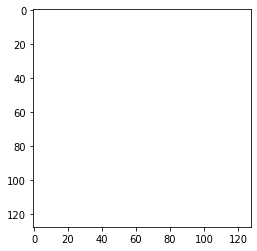

TypeError: Invalid shape (128, 128, 137) for image data

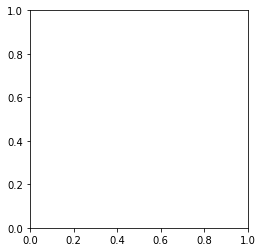

In [139]:
#test_dataset = tf_dataset(X_test, y_test, 1)
import matplotlib.pyplot as plt

def create_mask(pred_mask):
  prediction = pred_mask[0]
  print(prediction.shape)
  #for i in range(136):
  #  plt.imshow(prediction[:,:,i])
  #  plt.show()
  prediction = tf.argmax(prediction, axis=-1)
  print(pred_mask.shape)


  #prediction = [..., tf.newaxis]
  #print(prediction)
  return prediction

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = resnet_model.predict(image)
      print(f'shape of mask is : {pred_mask.shape}')
      plt.imshow(image[0])
      plt.show()
      plt.imshow(mask[0], interpolation='nearest')
      plt.show()
      plt.imshow(create_mask(pred_mask), interpolation='nearest')
      plt.show()
  #else:
    #display([sample_image, sample_mask,
     #        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(val_data, 25)
print(model.summary())


shape of mask is : (1, 128, 128, 137)


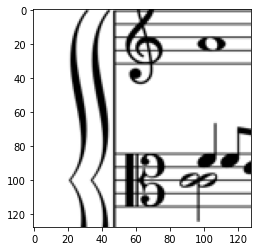

(128, 128, 137)
(1, 128, 128, 137)


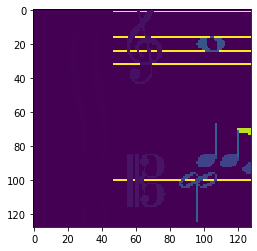

(128, 128, 137)
(1, 128, 128, 137)


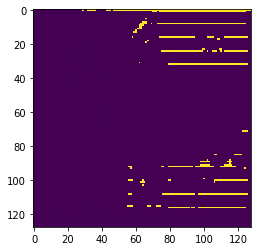

shape of mask is : (1, 128, 128, 137)


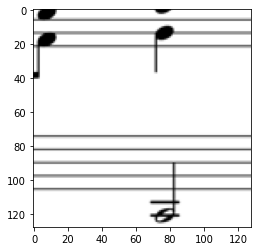

(128, 128, 137)
(1, 128, 128, 137)


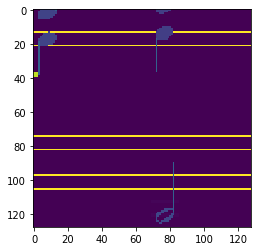

(128, 128, 137)
(1, 128, 128, 137)


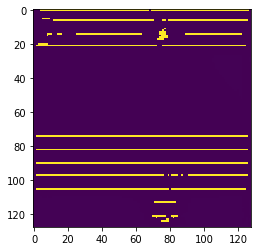

shape of mask is : (1, 128, 128, 137)


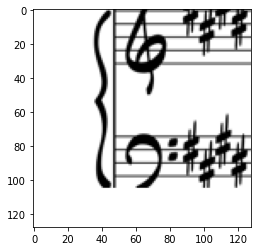

(128, 128, 137)
(1, 128, 128, 137)


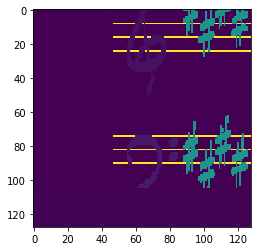

(128, 128, 137)
(1, 128, 128, 137)


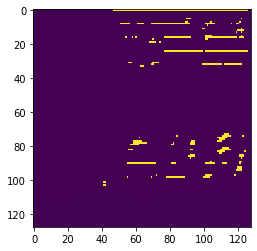

shape of mask is : (1, 128, 128, 137)


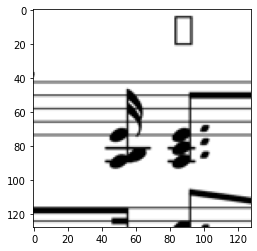

(128, 128, 137)
(1, 128, 128, 137)


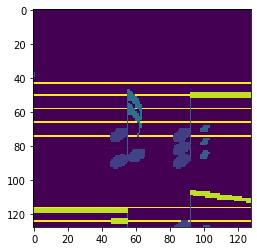

(128, 128, 137)
(1, 128, 128, 137)


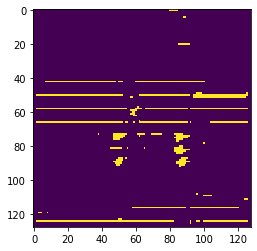

shape of mask is : (1, 128, 128, 137)


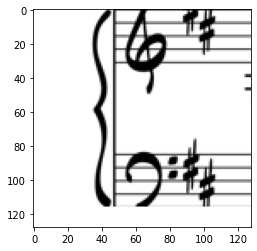

(128, 128, 137)
(1, 128, 128, 137)


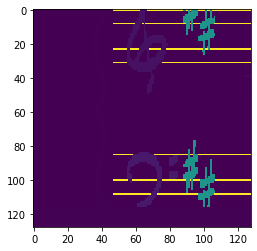

(128, 128, 137)
(1, 128, 128, 137)


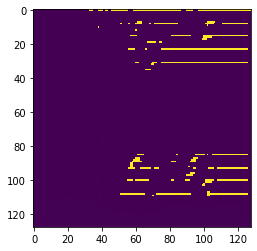

shape of mask is : (1, 128, 128, 137)


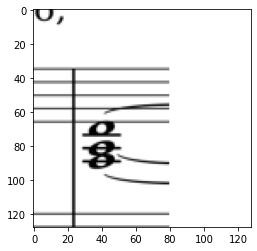

(128, 128, 137)
(1, 128, 128, 137)


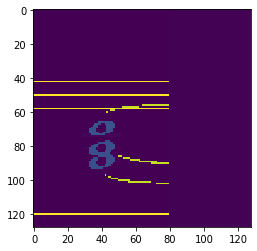

(128, 128, 137)
(1, 128, 128, 137)


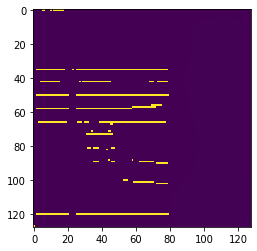

shape of mask is : (1, 128, 128, 137)


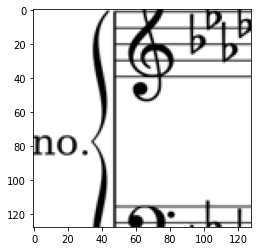

(128, 128, 137)
(1, 128, 128, 137)


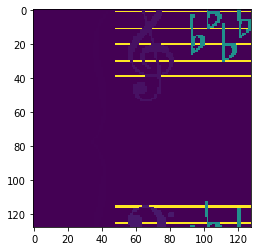

(128, 128, 137)
(1, 128, 128, 137)


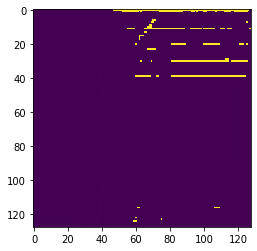

shape of mask is : (1, 128, 128, 137)


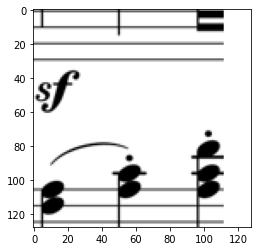

(128, 128, 137)
(1, 128, 128, 137)


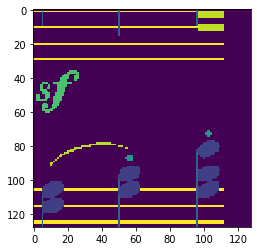

(128, 128, 137)
(1, 128, 128, 137)


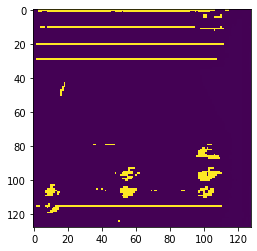

shape of mask is : (1, 128, 128, 137)


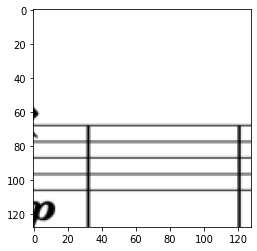

(128, 128, 137)
(1, 128, 128, 137)


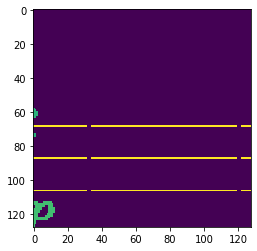

(128, 128, 137)
(1, 128, 128, 137)


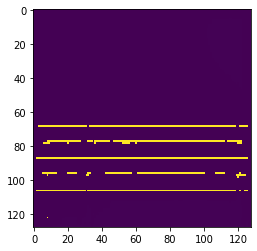

shape of mask is : (1, 128, 128, 137)


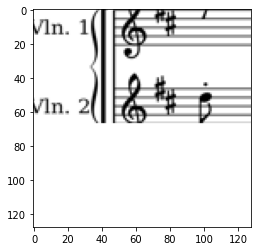

(128, 128, 137)
(1, 128, 128, 137)


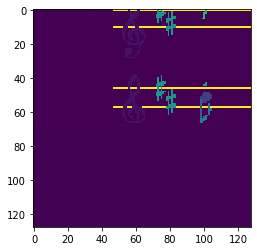

(128, 128, 137)
(1, 128, 128, 137)


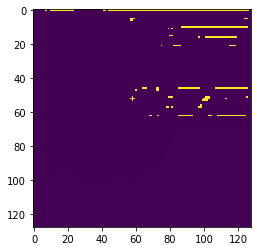

shape of mask is : (1, 128, 128, 137)


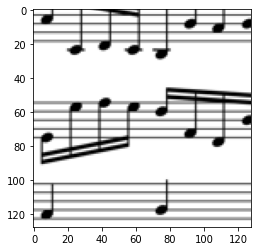

(128, 128, 137)
(1, 128, 128, 137)


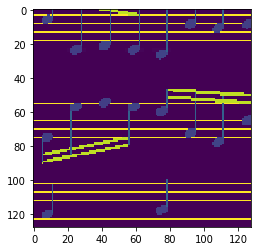

(128, 128, 137)
(1, 128, 128, 137)


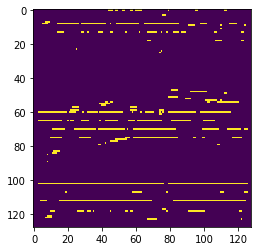

shape of mask is : (1, 128, 128, 137)


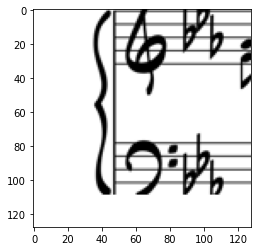

(128, 128, 137)
(1, 128, 128, 137)


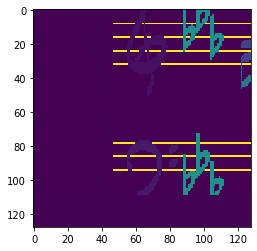

(128, 128, 137)
(1, 128, 128, 137)


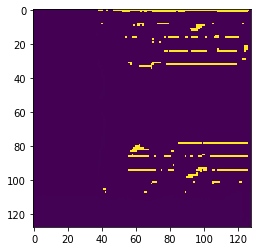

shape of mask is : (1, 128, 128, 137)


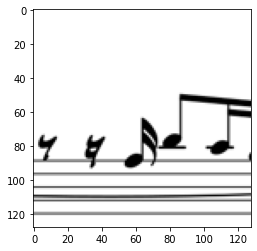

(128, 128, 137)
(1, 128, 128, 137)


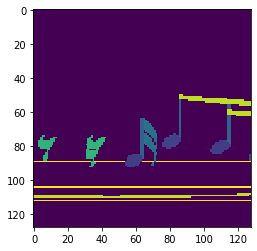

(128, 128, 137)
(1, 128, 128, 137)


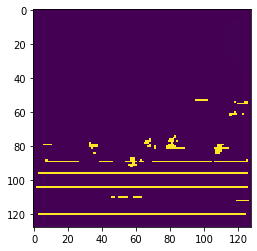

shape of mask is : (1, 128, 128, 137)


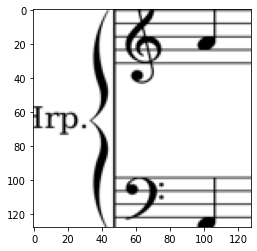

(128, 128, 137)
(1, 128, 128, 137)


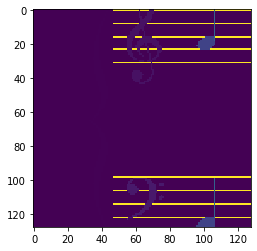

(128, 128, 137)
(1, 128, 128, 137)


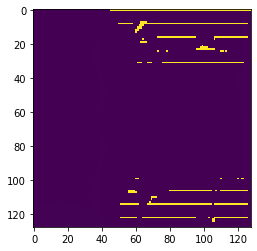

shape of mask is : (1, 128, 128, 137)


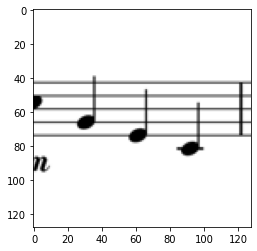

(128, 128, 137)
(1, 128, 128, 137)


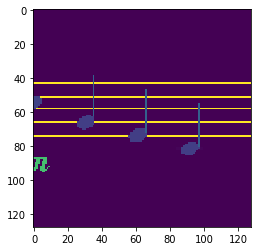

(128, 128, 137)
(1, 128, 128, 137)


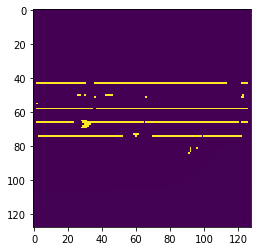

shape of mask is : (1, 128, 128, 137)


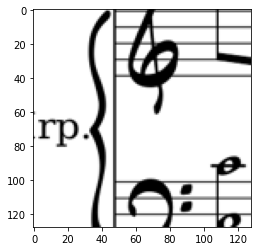

(128, 128, 137)
(1, 128, 128, 137)


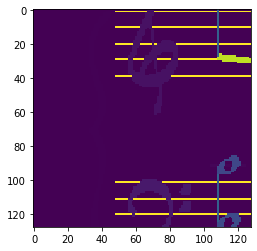

(128, 128, 137)
(1, 128, 128, 137)


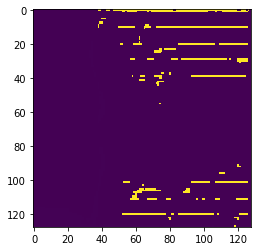

shape of mask is : (1, 128, 128, 137)


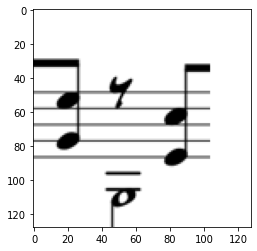

(128, 128, 137)
(1, 128, 128, 137)


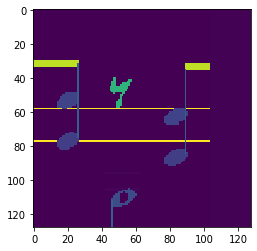

(128, 128, 137)
(1, 128, 128, 137)


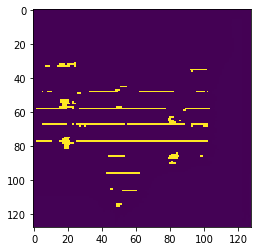

shape of mask is : (1, 128, 128, 137)


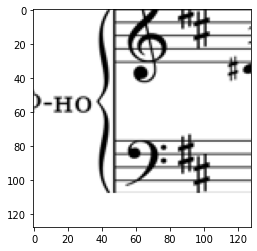

(128, 128, 137)
(1, 128, 128, 137)


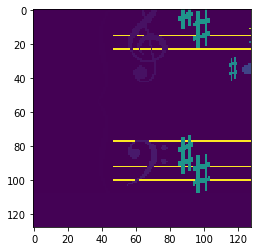

(128, 128, 137)
(1, 128, 128, 137)


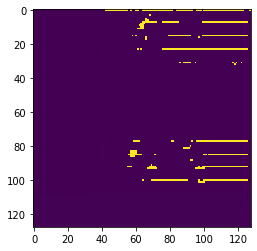

shape of mask is : (1, 128, 128, 137)


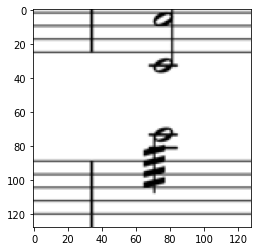

(128, 128, 137)
(1, 128, 128, 137)


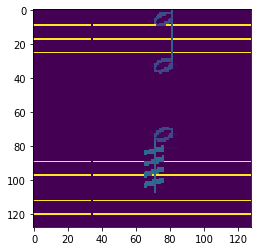

(128, 128, 137)
(1, 128, 128, 137)


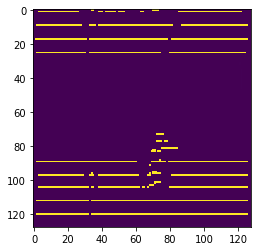

shape of mask is : (1, 128, 128, 137)


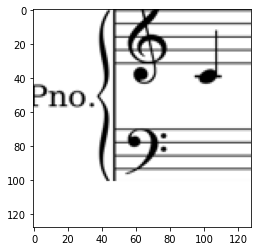

(128, 128, 137)
(1, 128, 128, 137)


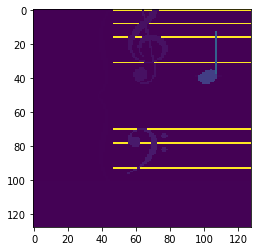

(128, 128, 137)
(1, 128, 128, 137)


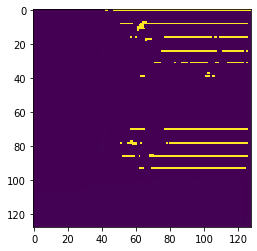

shape of mask is : (1, 128, 128, 137)


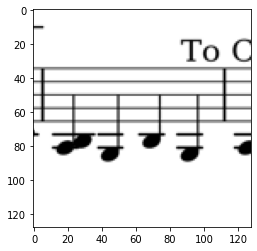

(128, 128, 137)
(1, 128, 128, 137)


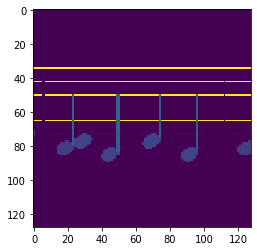

(128, 128, 137)
(1, 128, 128, 137)


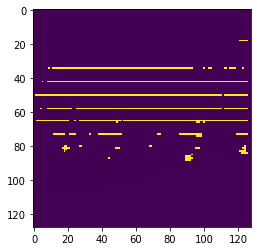

shape of mask is : (1, 128, 128, 137)


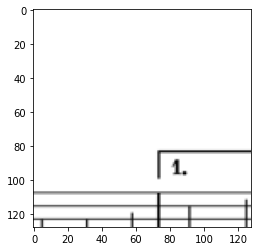

(128, 128, 137)
(1, 128, 128, 137)


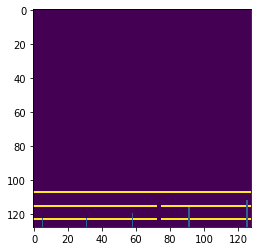

(128, 128, 137)
(1, 128, 128, 137)


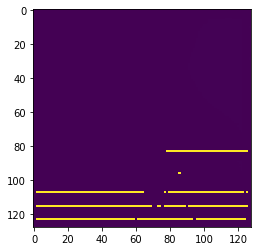

shape of mask is : (1, 128, 128, 137)


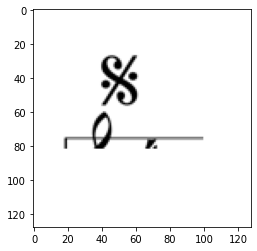

(128, 128, 137)
(1, 128, 128, 137)


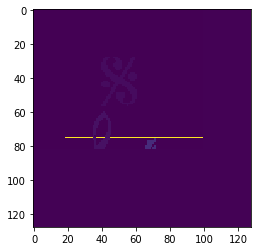

(128, 128, 137)
(1, 128, 128, 137)


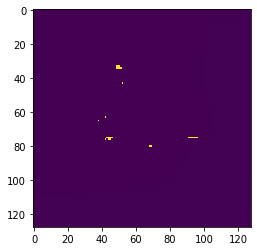

shape of mask is : (1, 128, 128, 137)


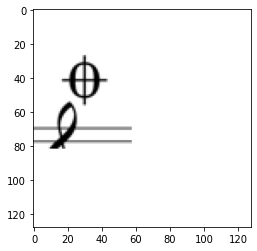

(128, 128, 137)
(1, 128, 128, 137)


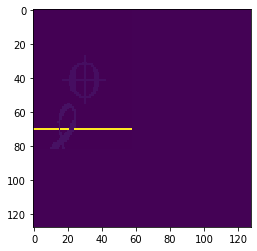

(128, 128, 137)
(1, 128, 128, 137)


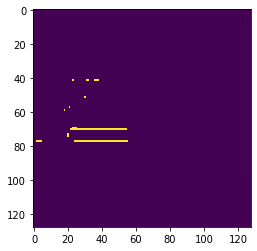

shape of mask is : (1, 128, 128, 137)


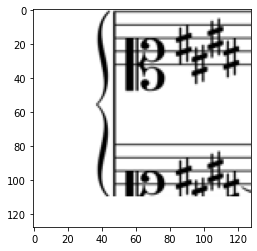

(128, 128, 137)
(1, 128, 128, 137)


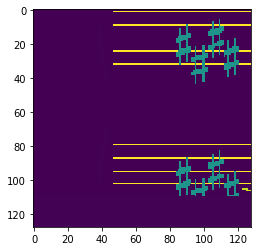

(128, 128, 137)
(1, 128, 128, 137)


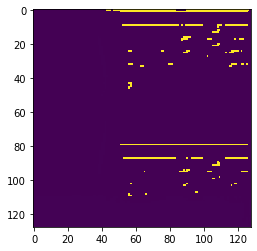

NameError: name 'model' is not defined

In [14]:
#test_dataset = tf_dataset(X_test, y_test, 1)

def create_mask(pred_mask):
  prediction = pred_mask[0]
  print(prediction.shape)
  #for i in range(136):
  #  plt.imshow(prediction[:,:,i])
  #  plt.show()
  prediction = tf.argmax(prediction, axis=-1)
  print(pred_mask.shape)


  #prediction = [..., tf.newaxis]
  #print(prediction)
  return prediction

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_mobilenet_2.predict(image)
      print(f'shape of mask is : {pred_mask.shape}')
      plt.imshow(image[0])
      plt.show()
      plt.imshow(create_mask(mask), interpolation='nearest')
      plt.show()
      plt.imshow(create_mask(pred_mask), interpolation='nearest')
      plt.show()
  #else:
    #display([sample_image, sample_mask,
     #        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(val_data, 25)
print(model.summary())


shape of mask is : (1, 256, 256, 137)


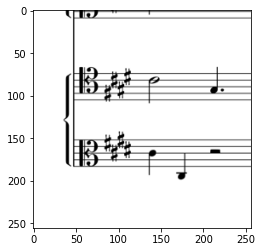

(256, 256, 137)
(1, 256, 256, 137)


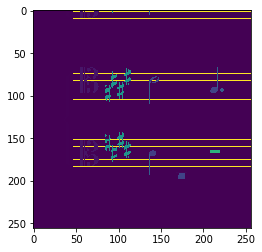

(256, 256, 137)
(1, 256, 256, 137)


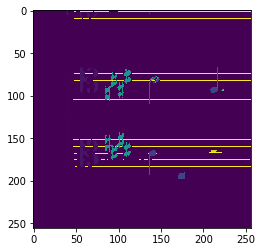

shape of mask is : (1, 256, 256, 137)


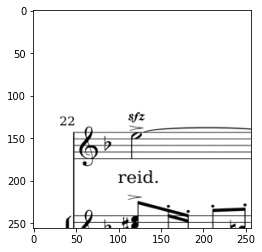

(256, 256, 137)
(1, 256, 256, 137)


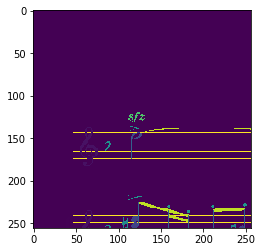

(256, 256, 137)
(1, 256, 256, 137)


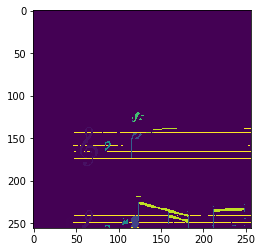

shape of mask is : (1, 256, 256, 137)


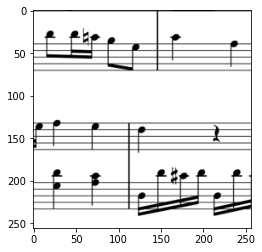

(256, 256, 137)
(1, 256, 256, 137)


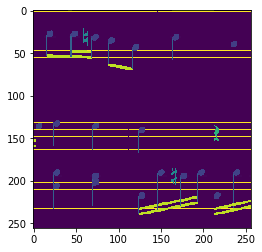

(256, 256, 137)
(1, 256, 256, 137)


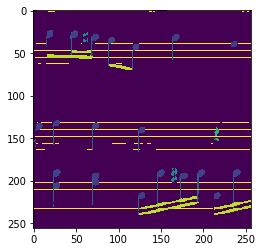

shape of mask is : (1, 256, 256, 137)


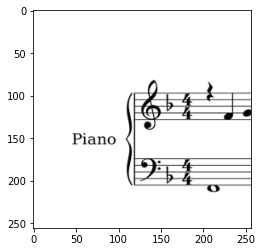

(256, 256, 137)
(1, 256, 256, 137)


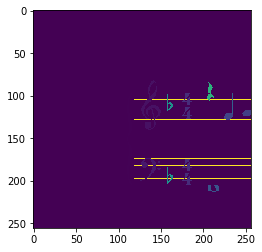

(256, 256, 137)
(1, 256, 256, 137)


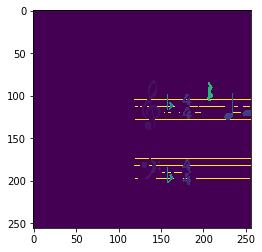

shape of mask is : (1, 256, 256, 137)


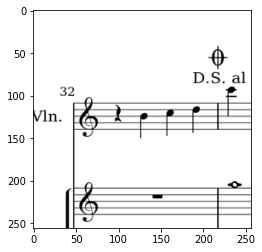

(256, 256, 137)
(1, 256, 256, 137)


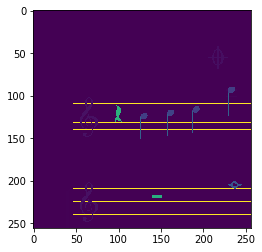

(256, 256, 137)
(1, 256, 256, 137)


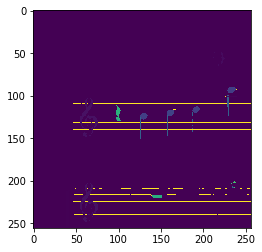

shape of mask is : (1, 256, 256, 137)


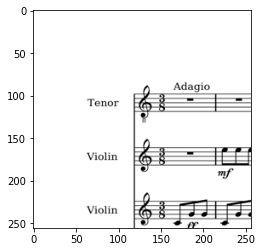

(256, 256, 137)
(1, 256, 256, 137)


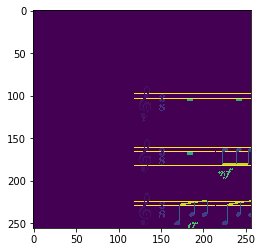

(256, 256, 137)
(1, 256, 256, 137)


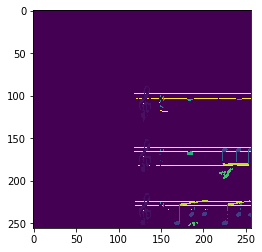

shape of mask is : (1, 256, 256, 137)


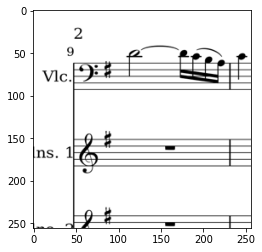

(256, 256, 137)
(1, 256, 256, 137)


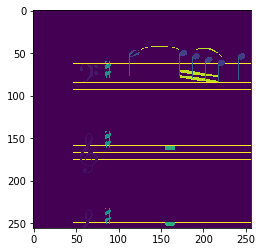

(256, 256, 137)
(1, 256, 256, 137)


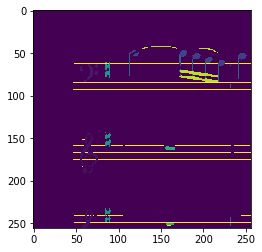

shape of mask is : (1, 256, 256, 137)


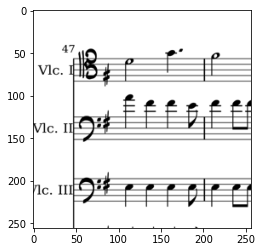

(256, 256, 137)
(1, 256, 256, 137)


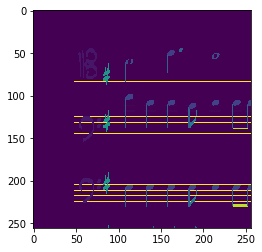

(256, 256, 137)
(1, 256, 256, 137)


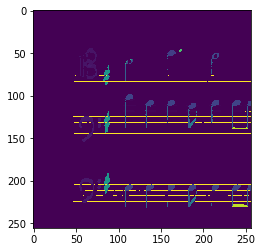

shape of mask is : (1, 256, 256, 137)


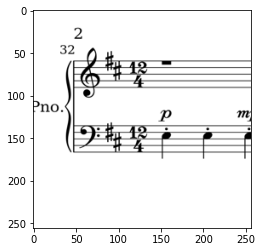

(256, 256, 137)
(1, 256, 256, 137)


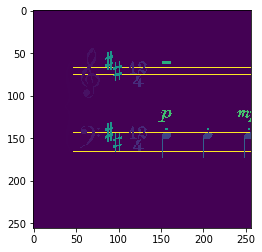

(256, 256, 137)
(1, 256, 256, 137)


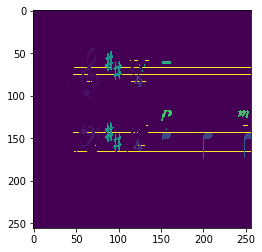

shape of mask is : (1, 256, 256, 137)


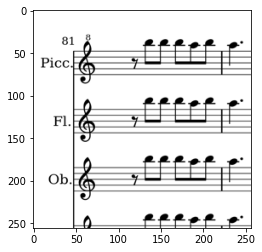

(256, 256, 137)
(1, 256, 256, 137)


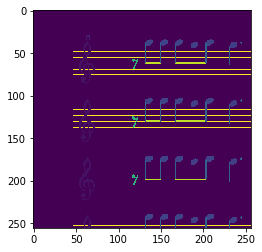

(256, 256, 137)
(1, 256, 256, 137)


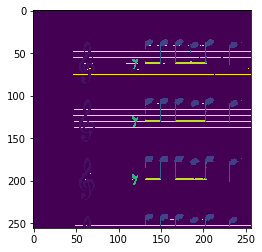

shape of mask is : (1, 256, 256, 137)


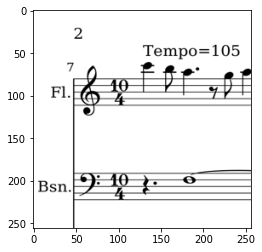

(256, 256, 137)
(1, 256, 256, 137)


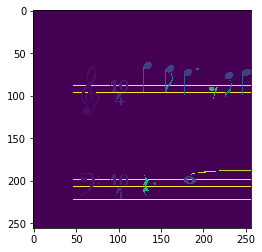

(256, 256, 137)
(1, 256, 256, 137)


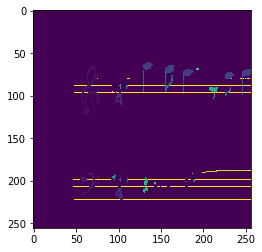

shape of mask is : (1, 256, 256, 137)


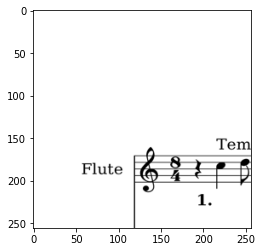

(256, 256, 137)
(1, 256, 256, 137)


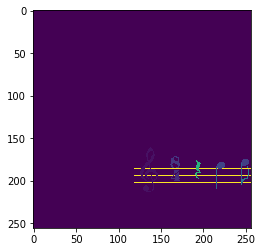

(256, 256, 137)
(1, 256, 256, 137)


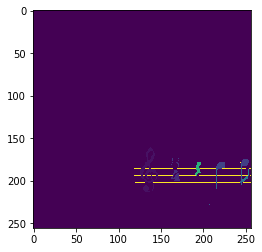

shape of mask is : (1, 256, 256, 137)


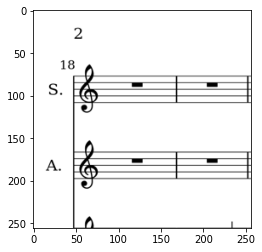

(256, 256, 137)
(1, 256, 256, 137)


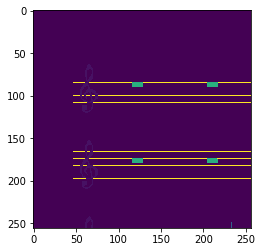

(256, 256, 137)
(1, 256, 256, 137)


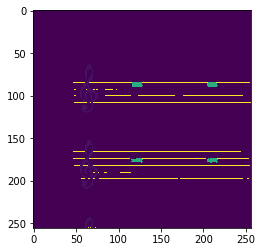

shape of mask is : (1, 256, 256, 137)


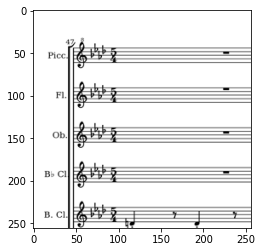

(256, 256, 137)
(1, 256, 256, 137)


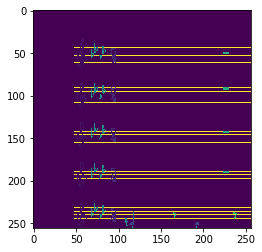

(256, 256, 137)
(1, 256, 256, 137)


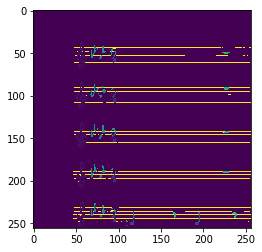

shape of mask is : (1, 256, 256, 137)


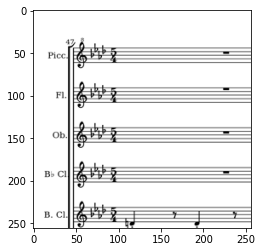

(256, 256, 137)
(1, 256, 256, 137)


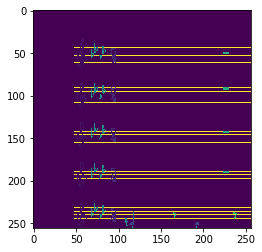

(256, 256, 137)
(1, 256, 256, 137)


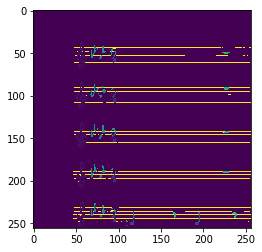

shape of mask is : (1, 256, 256, 137)


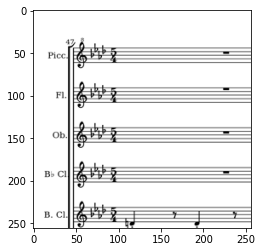

(256, 256, 137)
(1, 256, 256, 137)


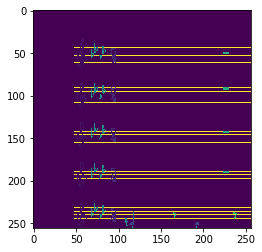

(256, 256, 137)
(1, 256, 256, 137)


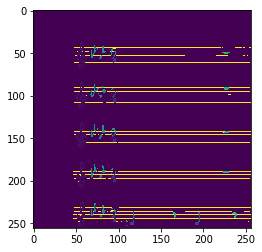

shape of mask is : (1, 256, 256, 137)


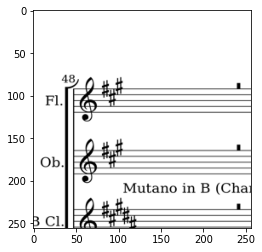

(256, 256, 137)
(1, 256, 256, 137)


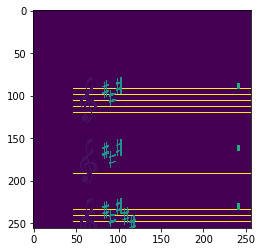

(256, 256, 137)
(1, 256, 256, 137)


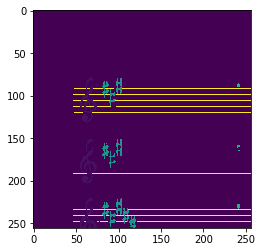

shape of mask is : (1, 256, 256, 137)


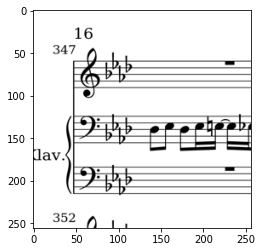

(256, 256, 137)
(1, 256, 256, 137)


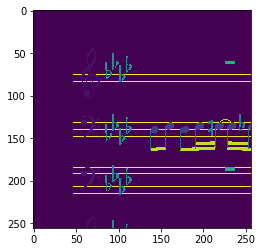

(256, 256, 137)
(1, 256, 256, 137)


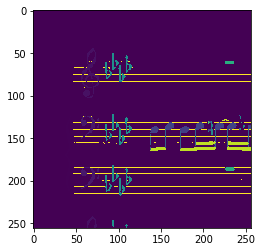

shape of mask is : (1, 256, 256, 137)


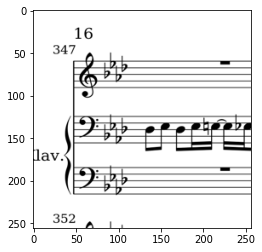

(256, 256, 137)
(1, 256, 256, 137)


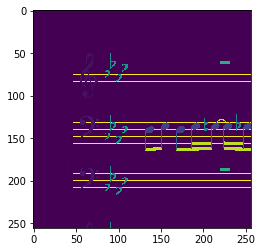

(256, 256, 137)
(1, 256, 256, 137)


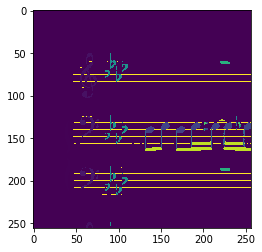

shape of mask is : (1, 256, 256, 137)


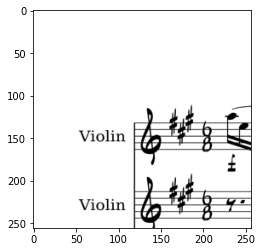

(256, 256, 137)
(1, 256, 256, 137)


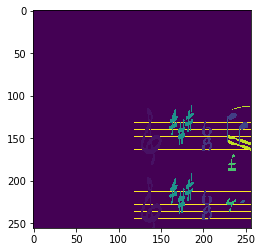

(256, 256, 137)
(1, 256, 256, 137)


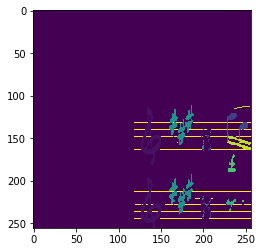

shape of mask is : (1, 256, 256, 137)


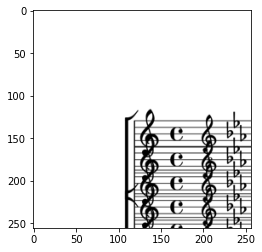

(256, 256, 137)
(1, 256, 256, 137)


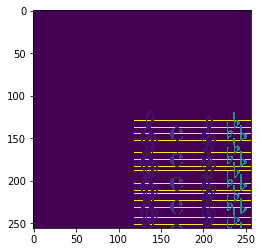

(256, 256, 137)
(1, 256, 256, 137)


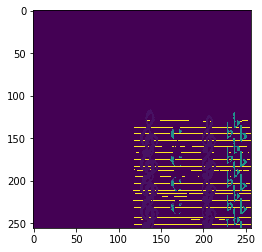

shape of mask is : (1, 256, 256, 137)


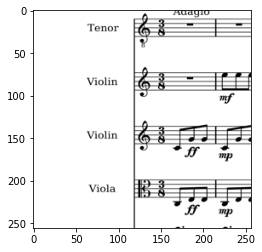

(256, 256, 137)
(1, 256, 256, 137)


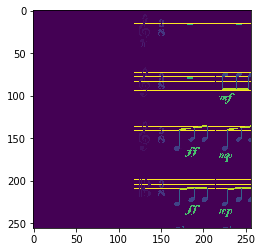

(256, 256, 137)
(1, 256, 256, 137)


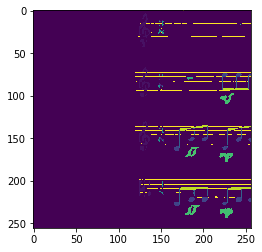

shape of mask is : (1, 256, 256, 137)


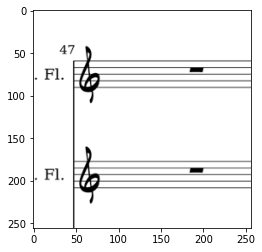

(256, 256, 137)
(1, 256, 256, 137)


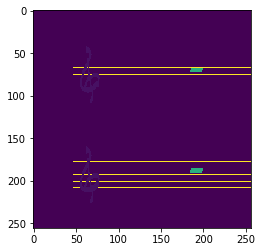

(256, 256, 137)
(1, 256, 256, 137)


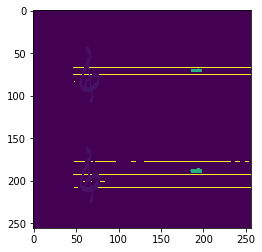

shape of mask is : (1, 256, 256, 137)


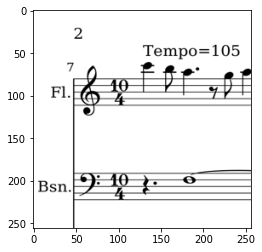

(256, 256, 137)
(1, 256, 256, 137)


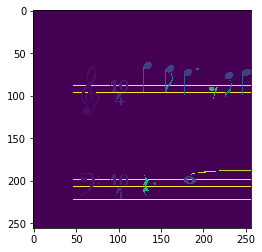

(256, 256, 137)
(1, 256, 256, 137)


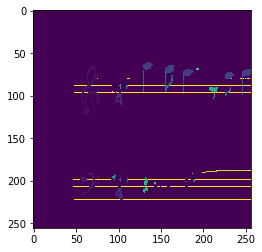

shape of mask is : (1, 256, 256, 137)


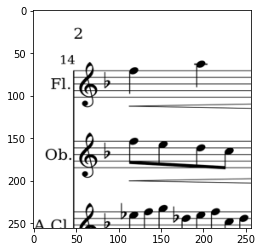

(256, 256, 137)
(1, 256, 256, 137)


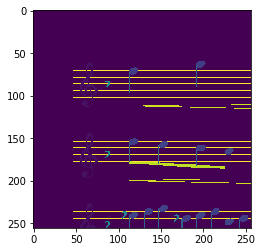

(256, 256, 137)
(1, 256, 256, 137)


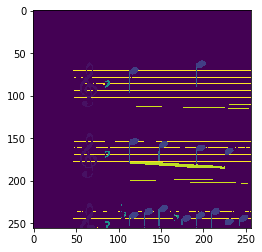

shape of mask is : (1, 256, 256, 137)


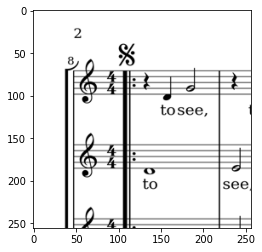

(256, 256, 137)
(1, 256, 256, 137)


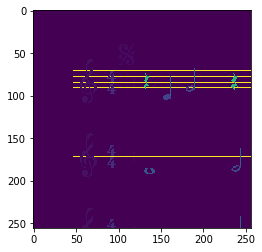

(256, 256, 137)
(1, 256, 256, 137)


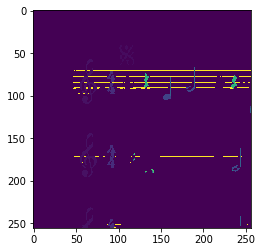

shape of mask is : (1, 256, 256, 137)


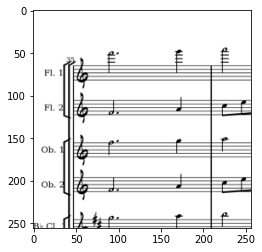

(256, 256, 137)
(1, 256, 256, 137)


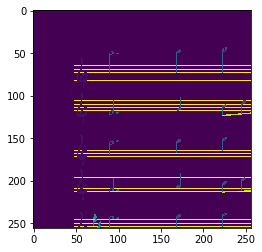

(256, 256, 137)
(1, 256, 256, 137)


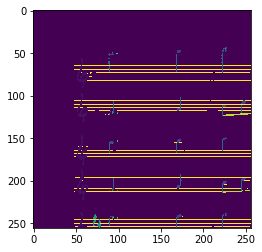

shape of mask is : (1, 256, 256, 137)


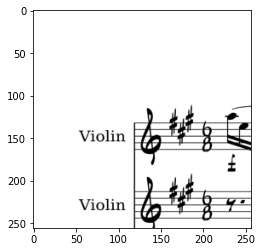

(256, 256, 137)
(1, 256, 256, 137)


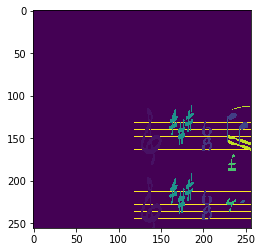

(256, 256, 137)
(1, 256, 256, 137)


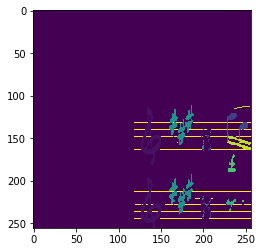

shape of mask is : (1, 256, 256, 137)


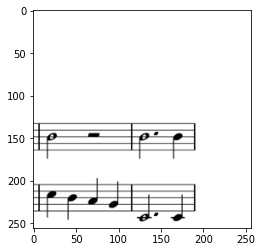

(256, 256, 137)
(1, 256, 256, 137)


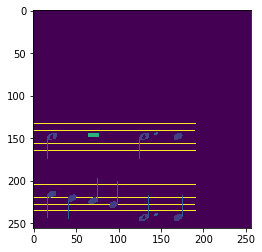

(256, 256, 137)
(1, 256, 256, 137)


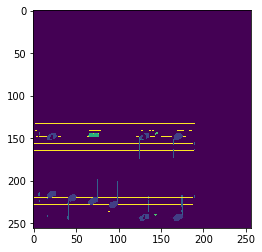

shape of mask is : (1, 256, 256, 137)


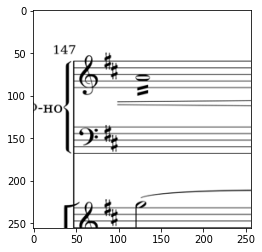

(256, 256, 137)
(1, 256, 256, 137)


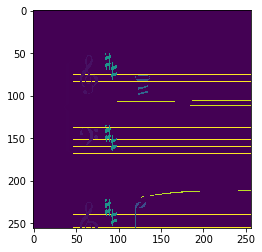

(256, 256, 137)
(1, 256, 256, 137)


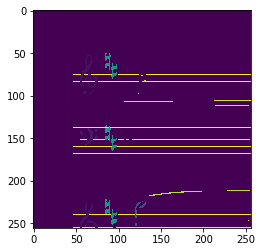

shape of mask is : (1, 256, 256, 137)


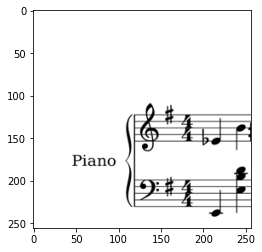

(256, 256, 137)
(1, 256, 256, 137)


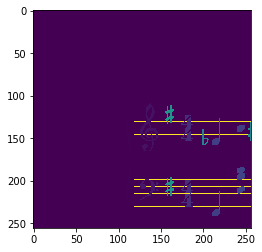

(256, 256, 137)
(1, 256, 256, 137)


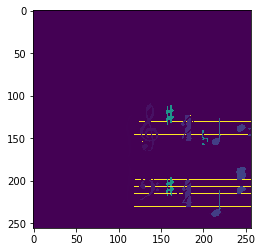

shape of mask is : (1, 256, 256, 137)


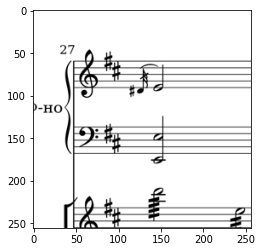

(256, 256, 137)
(1, 256, 256, 137)


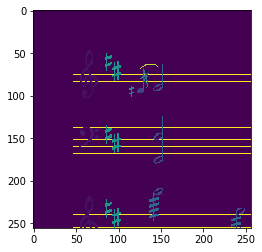

(256, 256, 137)
(1, 256, 256, 137)


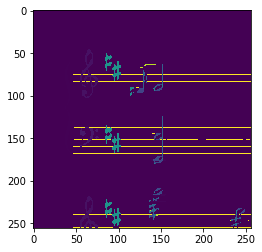

shape of mask is : (1, 256, 256, 137)


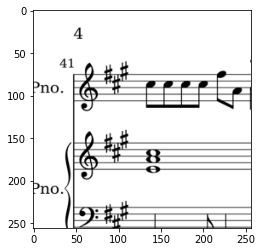

(256, 256, 137)
(1, 256, 256, 137)


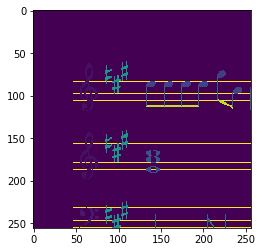

(256, 256, 137)
(1, 256, 256, 137)


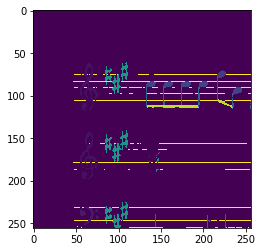

shape of mask is : (1, 256, 256, 137)


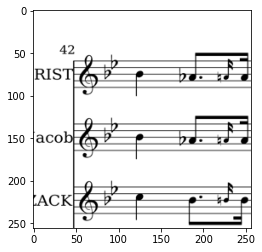

(256, 256, 137)
(1, 256, 256, 137)


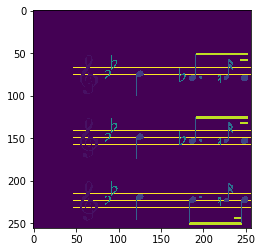

(256, 256, 137)
(1, 256, 256, 137)


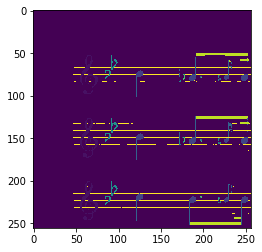

shape of mask is : (1, 256, 256, 137)


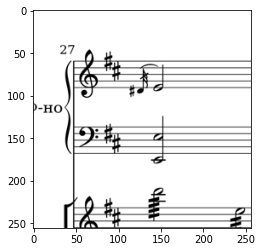

(256, 256, 137)
(1, 256, 256, 137)


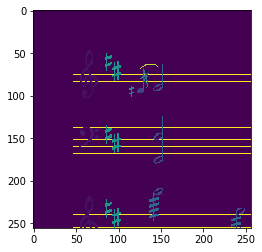

(256, 256, 137)
(1, 256, 256, 137)


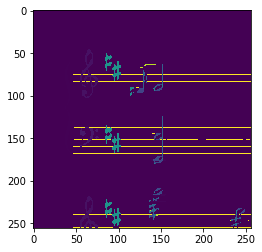

shape of mask is : (1, 256, 256, 137)


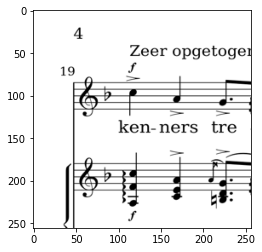

(256, 256, 137)
(1, 256, 256, 137)


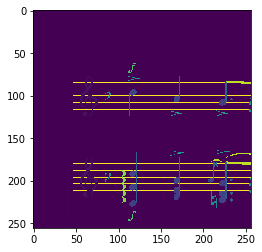

(256, 256, 137)
(1, 256, 256, 137)


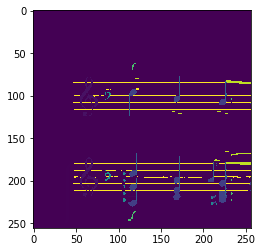

shape of mask is : (1, 256, 256, 137)


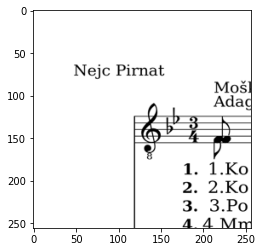

(256, 256, 137)
(1, 256, 256, 137)


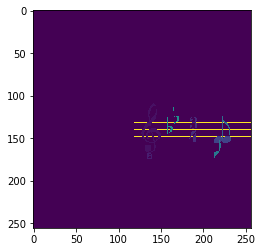

(256, 256, 137)
(1, 256, 256, 137)


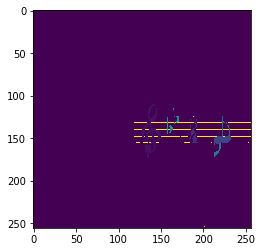

shape of mask is : (1, 256, 256, 137)


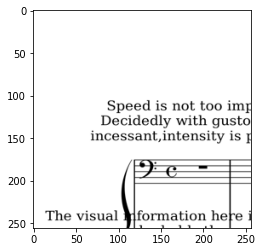

(256, 256, 137)
(1, 256, 256, 137)


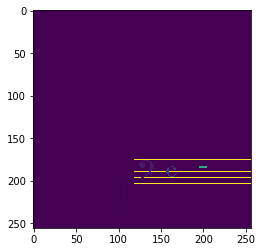

(256, 256, 137)
(1, 256, 256, 137)


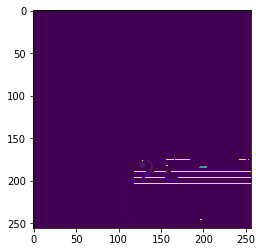

shape of mask is : (1, 256, 256, 137)


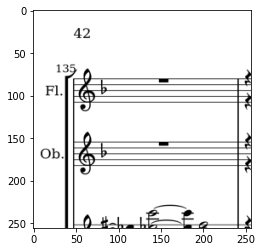

(256, 256, 137)
(1, 256, 256, 137)


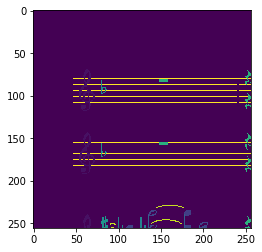

(256, 256, 137)
(1, 256, 256, 137)


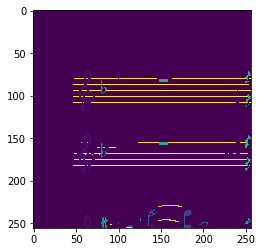

shape of mask is : (1, 256, 256, 137)


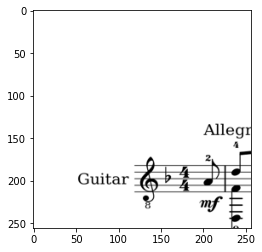

(256, 256, 137)
(1, 256, 256, 137)


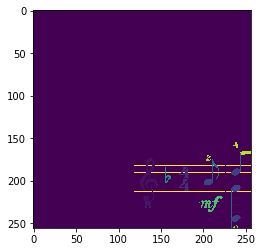

(256, 256, 137)
(1, 256, 256, 137)


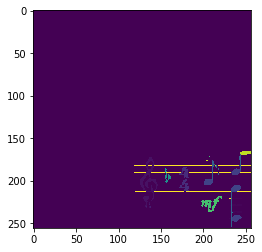

shape of mask is : (1, 256, 256, 137)


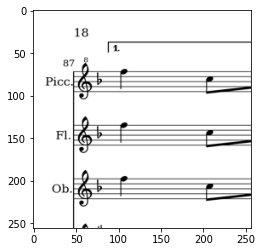

(256, 256, 137)
(1, 256, 256, 137)


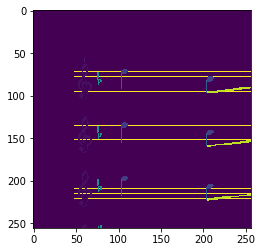

(256, 256, 137)
(1, 256, 256, 137)


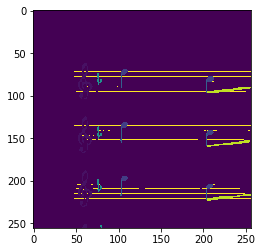

shape of mask is : (1, 256, 256, 137)


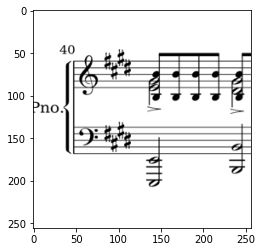

(256, 256, 137)
(1, 256, 256, 137)


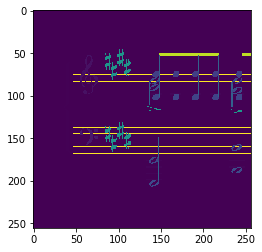

(256, 256, 137)
(1, 256, 256, 137)


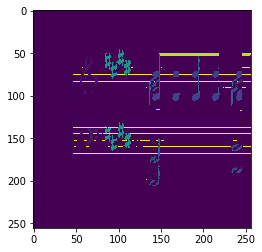

shape of mask is : (1, 256, 256, 137)


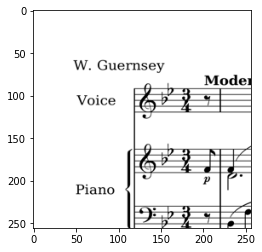

(256, 256, 137)
(1, 256, 256, 137)


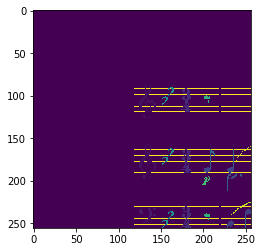

(256, 256, 137)
(1, 256, 256, 137)


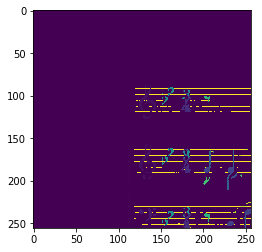

shape of mask is : (1, 256, 256, 137)


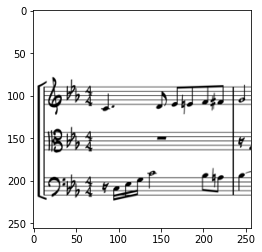

(256, 256, 137)
(1, 256, 256, 137)


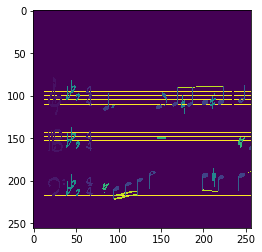

(256, 256, 137)
(1, 256, 256, 137)


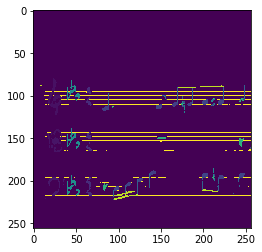

shape of mask is : (1, 256, 256, 137)


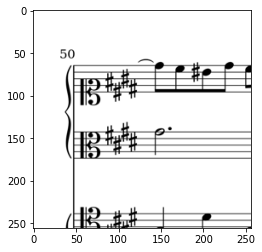

(256, 256, 137)
(1, 256, 256, 137)


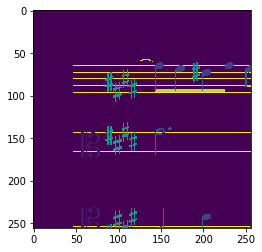

(256, 256, 137)
(1, 256, 256, 137)


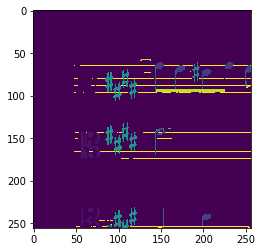

shape of mask is : (1, 256, 256, 137)


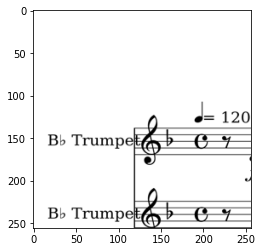

(256, 256, 137)
(1, 256, 256, 137)


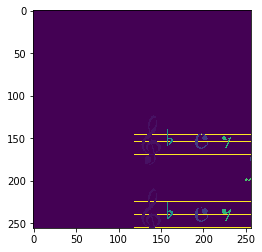

(256, 256, 137)
(1, 256, 256, 137)


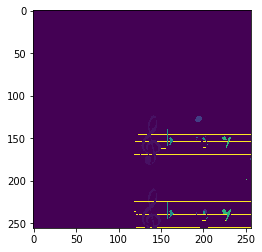

shape of mask is : (1, 256, 256, 137)


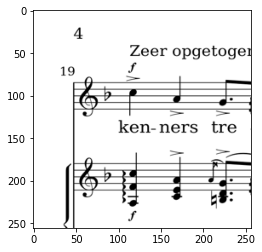

(256, 256, 137)
(1, 256, 256, 137)


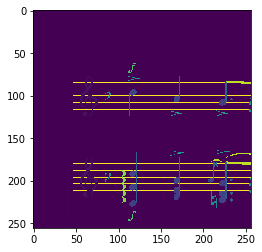

(256, 256, 137)
(1, 256, 256, 137)


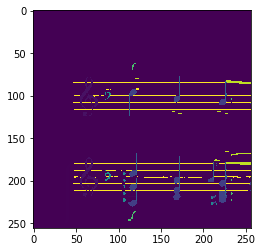

shape of mask is : (1, 256, 256, 137)


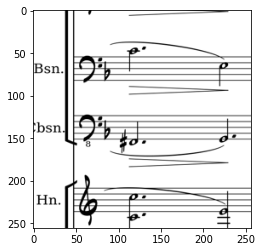

(256, 256, 137)
(1, 256, 256, 137)


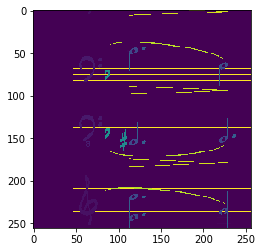

(256, 256, 137)
(1, 256, 256, 137)


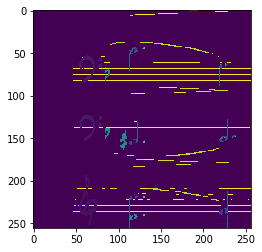

shape of mask is : (1, 256, 256, 137)


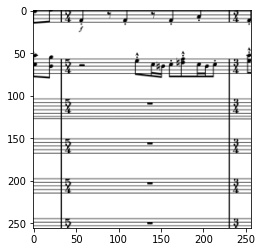

(256, 256, 137)
(1, 256, 256, 137)


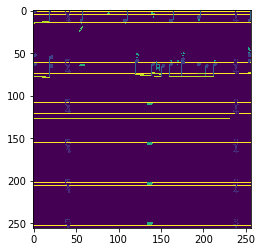

(256, 256, 137)
(1, 256, 256, 137)


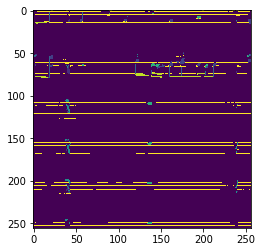

shape of mask is : (1, 256, 256, 137)


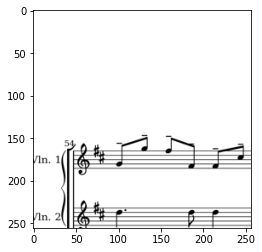

(256, 256, 137)
(1, 256, 256, 137)


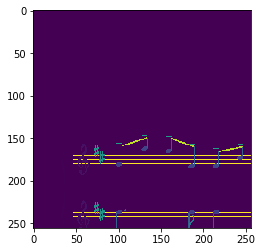

(256, 256, 137)
(1, 256, 256, 137)


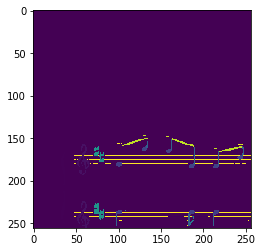

shape of mask is : (1, 256, 256, 137)


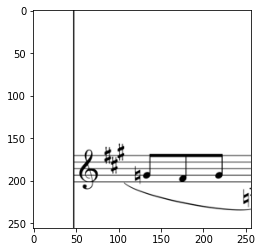

(256, 256, 137)
(1, 256, 256, 137)


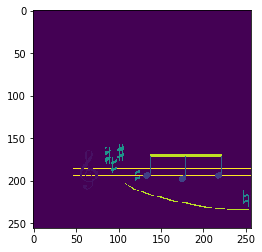

(256, 256, 137)
(1, 256, 256, 137)


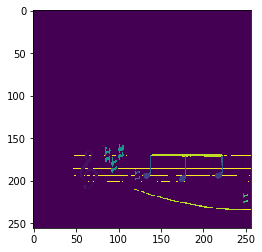

shape of mask is : (1, 256, 256, 137)


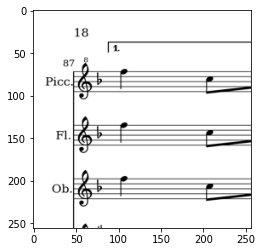

(256, 256, 137)
(1, 256, 256, 137)


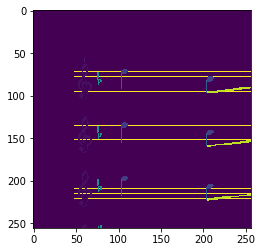

(256, 256, 137)
(1, 256, 256, 137)


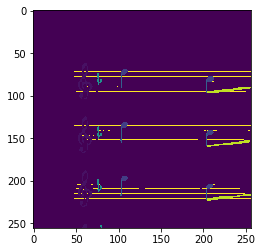

shape of mask is : (1, 256, 256, 137)


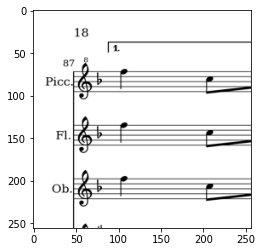

(256, 256, 137)
(1, 256, 256, 137)


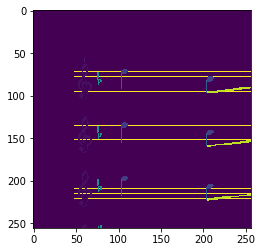

(256, 256, 137)
(1, 256, 256, 137)


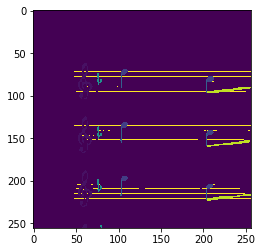

shape of mask is : (1, 256, 256, 137)


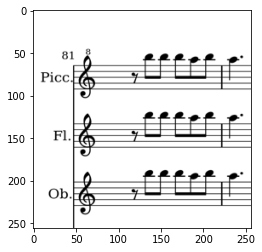

(256, 256, 137)
(1, 256, 256, 137)


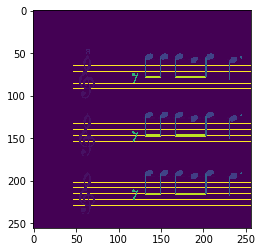

(256, 256, 137)
(1, 256, 256, 137)


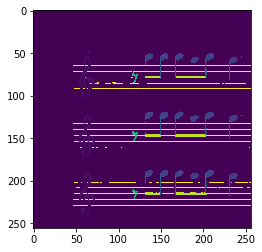

shape of mask is : (1, 256, 256, 137)


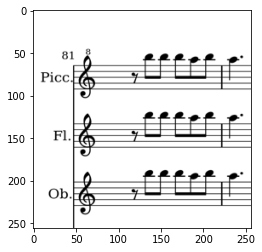

(256, 256, 137)
(1, 256, 256, 137)


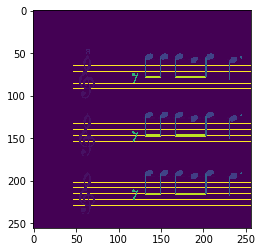

(256, 256, 137)
(1, 256, 256, 137)


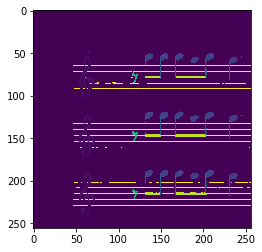

shape of mask is : (1, 256, 256, 137)


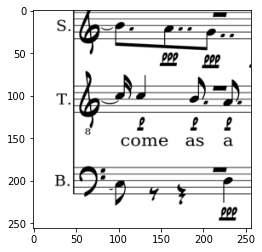

(256, 256, 137)
(1, 256, 256, 137)


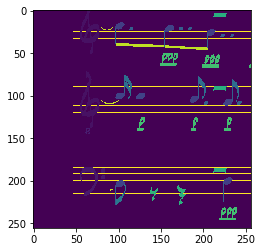

(256, 256, 137)
(1, 256, 256, 137)


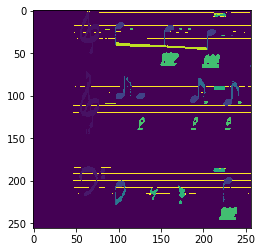

shape of mask is : (1, 256, 256, 137)


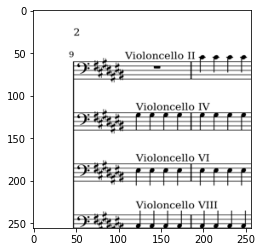

(256, 256, 137)
(1, 256, 256, 137)


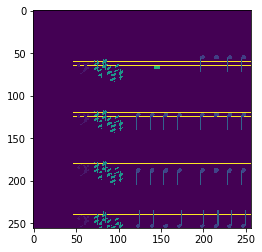

(256, 256, 137)
(1, 256, 256, 137)


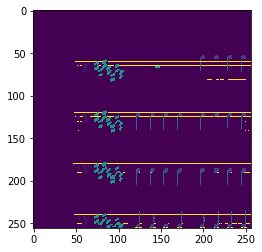

shape of mask is : (1, 256, 256, 137)


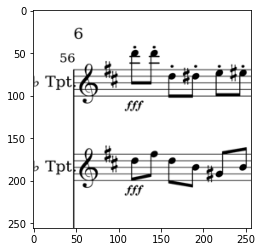

(256, 256, 137)
(1, 256, 256, 137)


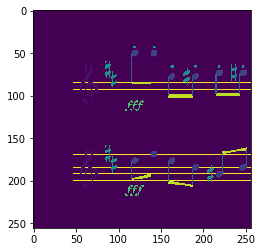

(256, 256, 137)
(1, 256, 256, 137)


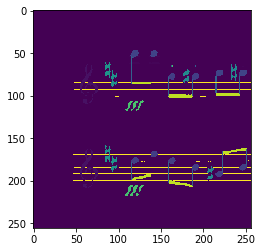

shape of mask is : (1, 256, 256, 137)


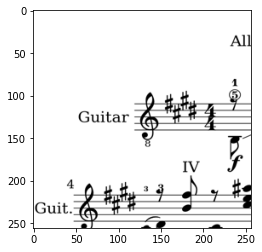

(256, 256, 137)
(1, 256, 256, 137)


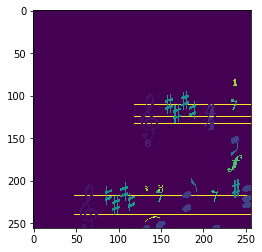

(256, 256, 137)
(1, 256, 256, 137)


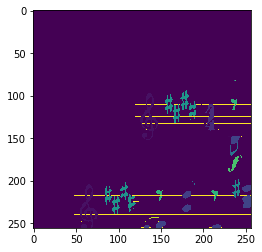

shape of mask is : (1, 256, 256, 137)


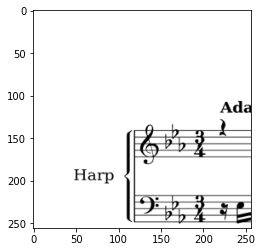

(256, 256, 137)
(1, 256, 256, 137)


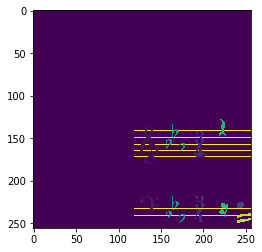

(256, 256, 137)
(1, 256, 256, 137)


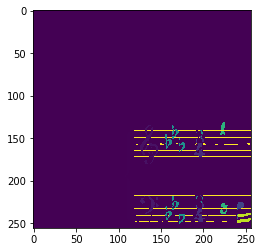

shape of mask is : (1, 256, 256, 137)


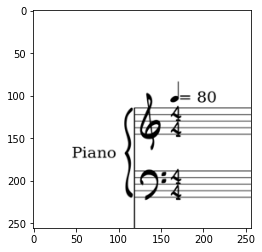

(256, 256, 137)
(1, 256, 256, 137)


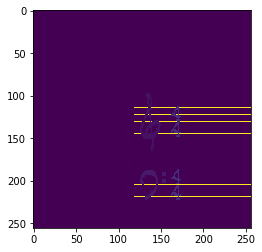

(256, 256, 137)
(1, 256, 256, 137)


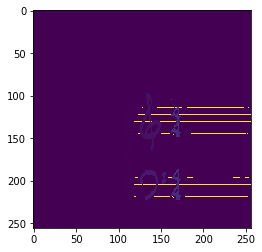

shape of mask is : (1, 256, 256, 137)


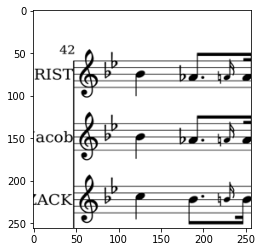

(256, 256, 137)
(1, 256, 256, 137)


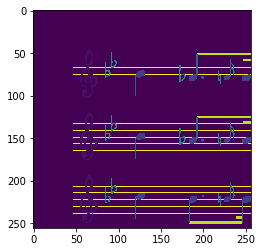

(256, 256, 137)
(1, 256, 256, 137)


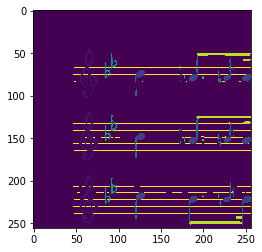

shape of mask is : (1, 256, 256, 137)


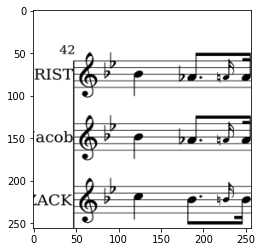

(256, 256, 137)
(1, 256, 256, 137)


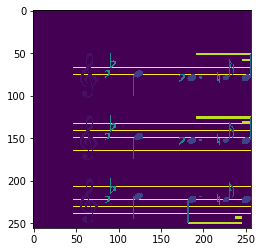

(256, 256, 137)
(1, 256, 256, 137)


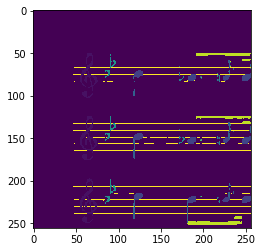

shape of mask is : (1, 256, 256, 137)


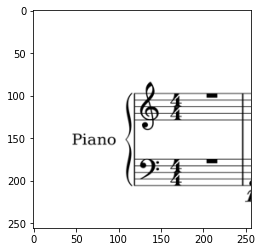

(256, 256, 137)
(1, 256, 256, 137)


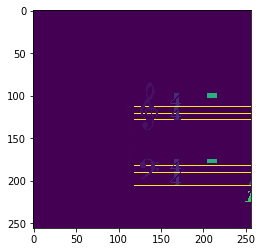

(256, 256, 137)
(1, 256, 256, 137)


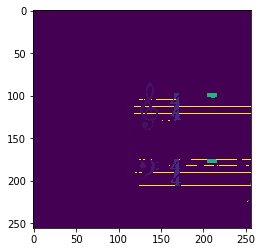

shape of mask is : (1, 256, 256, 137)


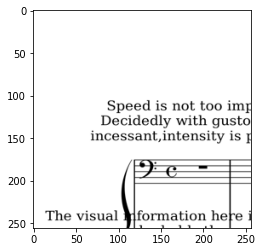

(256, 256, 137)
(1, 256, 256, 137)


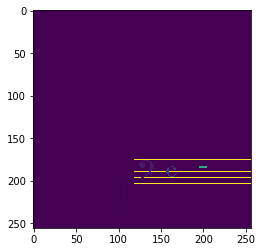

(256, 256, 137)
(1, 256, 256, 137)


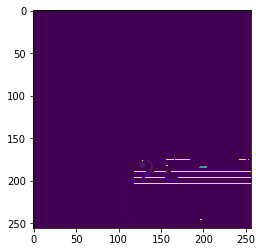

shape of mask is : (1, 256, 256, 137)


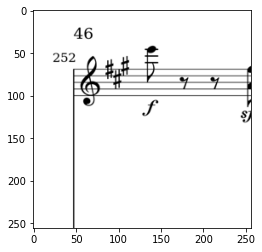

(256, 256, 137)
(1, 256, 256, 137)


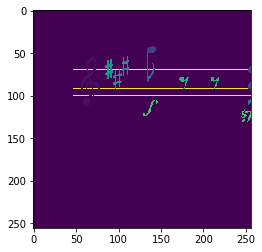

(256, 256, 137)
(1, 256, 256, 137)


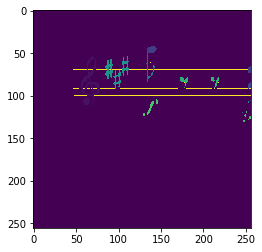

shape of mask is : (1, 256, 256, 137)


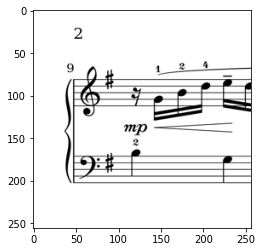

(256, 256, 137)
(1, 256, 256, 137)


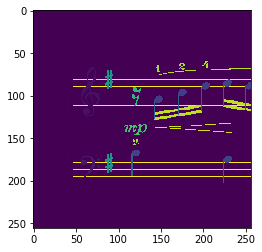

(256, 256, 137)
(1, 256, 256, 137)


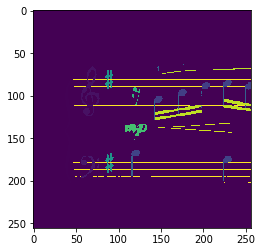

shape of mask is : (1, 256, 256, 137)


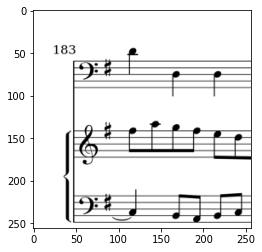

(256, 256, 137)
(1, 256, 256, 137)


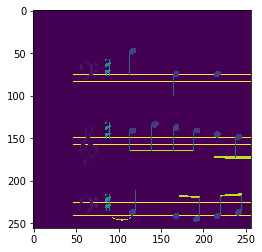

(256, 256, 137)
(1, 256, 256, 137)


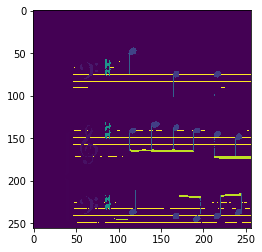

shape of mask is : (1, 256, 256, 137)


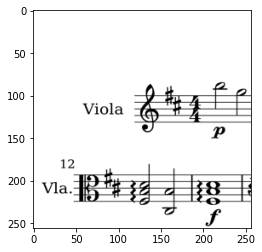

(256, 256, 137)
(1, 256, 256, 137)


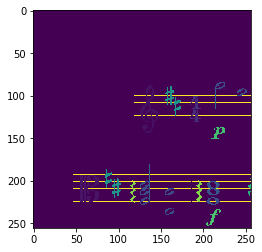

(256, 256, 137)
(1, 256, 256, 137)


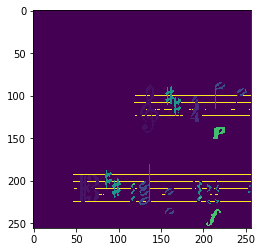

shape of mask is : (1, 256, 256, 137)


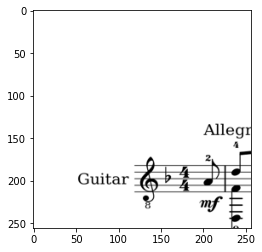

(256, 256, 137)
(1, 256, 256, 137)


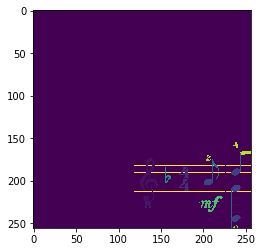

(256, 256, 137)
(1, 256, 256, 137)


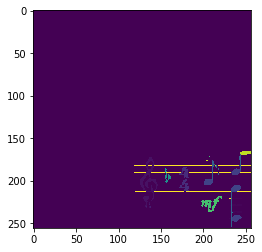

shape of mask is : (1, 256, 256, 137)


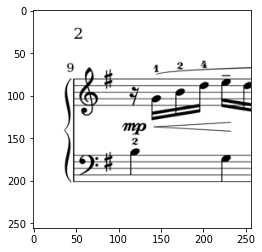

(256, 256, 137)
(1, 256, 256, 137)


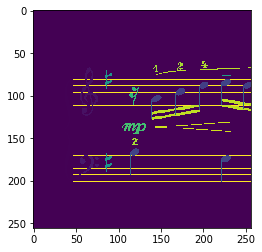

(256, 256, 137)
(1, 256, 256, 137)


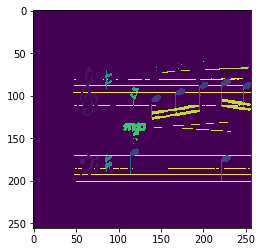

shape of mask is : (1, 256, 256, 137)


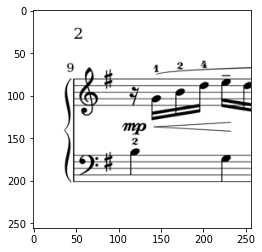

(256, 256, 137)
(1, 256, 256, 137)


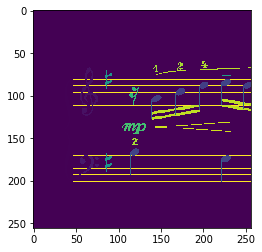

(256, 256, 137)
(1, 256, 256, 137)


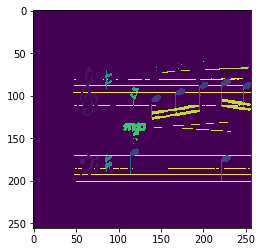

shape of mask is : (1, 256, 256, 137)


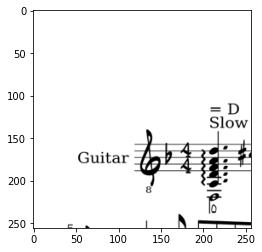

(256, 256, 137)
(1, 256, 256, 137)


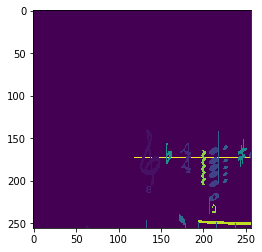

(256, 256, 137)
(1, 256, 256, 137)


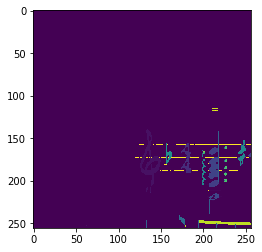

shape of mask is : (1, 256, 256, 137)


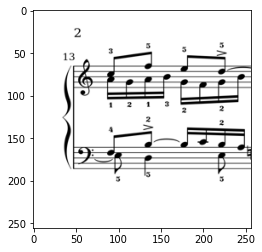

(256, 256, 137)
(1, 256, 256, 137)


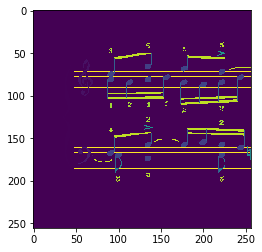

(256, 256, 137)
(1, 256, 256, 137)


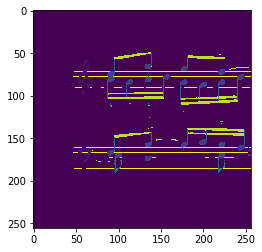

shape of mask is : (1, 256, 256, 137)


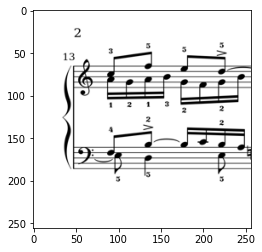

(256, 256, 137)
(1, 256, 256, 137)


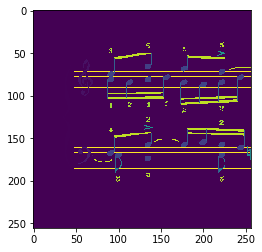

(256, 256, 137)
(1, 256, 256, 137)


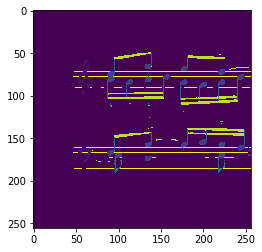

shape of mask is : (1, 256, 256, 137)


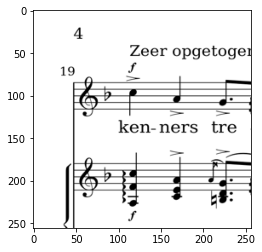

(256, 256, 137)
(1, 256, 256, 137)


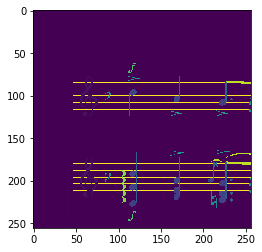

(256, 256, 137)
(1, 256, 256, 137)


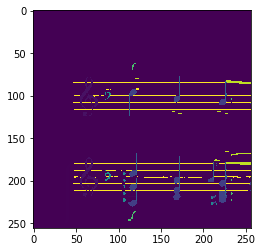

shape of mask is : (1, 256, 256, 137)


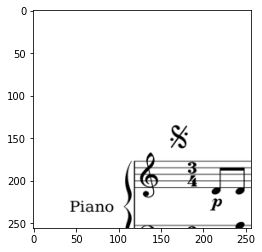

(256, 256, 137)
(1, 256, 256, 137)


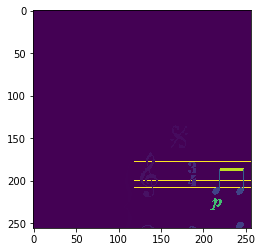

(256, 256, 137)
(1, 256, 256, 137)


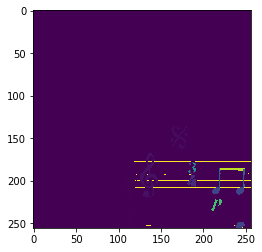

shape of mask is : (1, 256, 256, 137)


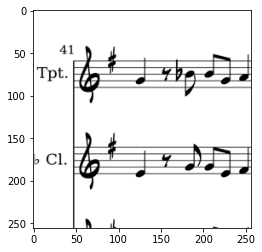

(256, 256, 137)
(1, 256, 256, 137)


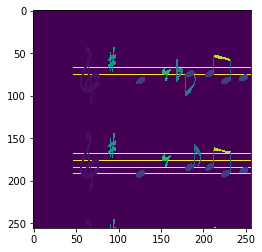

(256, 256, 137)
(1, 256, 256, 137)


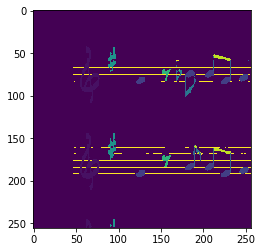

shape of mask is : (1, 256, 256, 137)


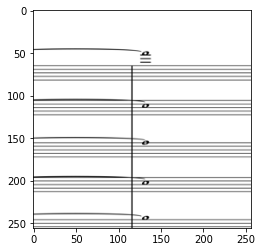

(256, 256, 137)
(1, 256, 256, 137)


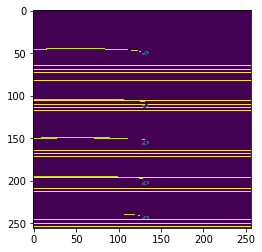

(256, 256, 137)
(1, 256, 256, 137)


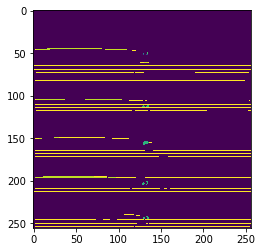

shape of mask is : (1, 256, 256, 137)


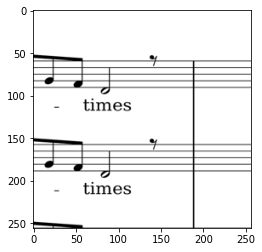

(256, 256, 137)
(1, 256, 256, 137)


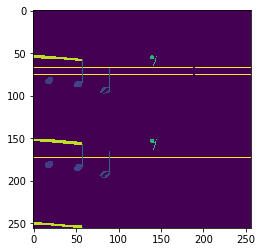

(256, 256, 137)
(1, 256, 256, 137)


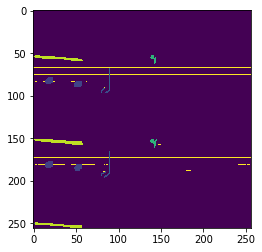

shape of mask is : (1, 256, 256, 137)


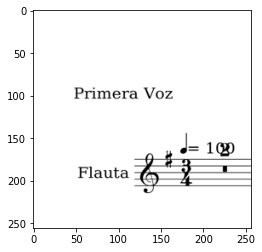

(256, 256, 137)
(1, 256, 256, 137)


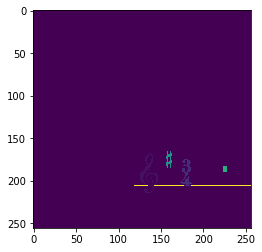

(256, 256, 137)
(1, 256, 256, 137)


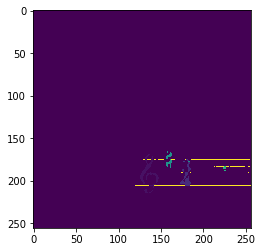

shape of mask is : (1, 256, 256, 137)


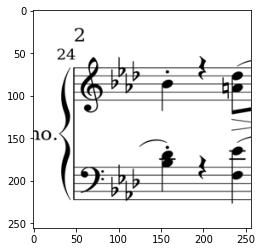

(256, 256, 137)
(1, 256, 256, 137)


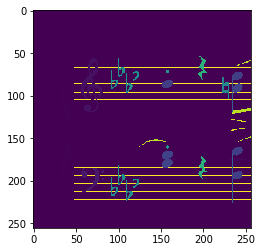

(256, 256, 137)
(1, 256, 256, 137)


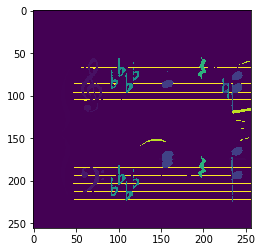

shape of mask is : (1, 256, 256, 137)


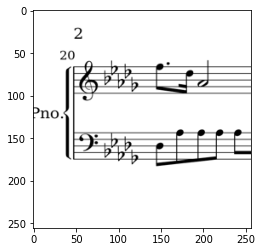

(256, 256, 137)
(1, 256, 256, 137)


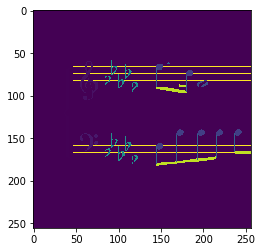

(256, 256, 137)
(1, 256, 256, 137)


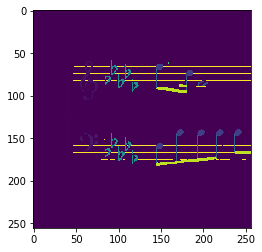

shape of mask is : (1, 256, 256, 137)


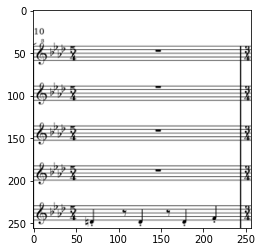

(256, 256, 137)
(1, 256, 256, 137)


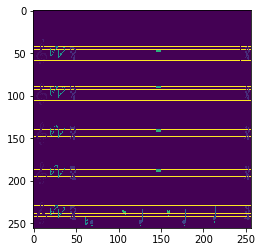

(256, 256, 137)
(1, 256, 256, 137)


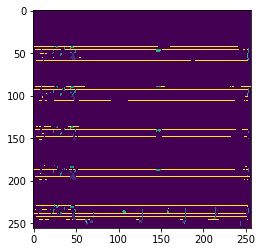

shape of mask is : (1, 256, 256, 137)


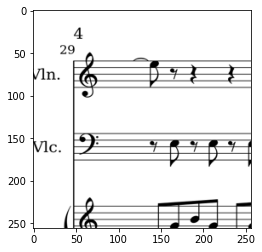

(256, 256, 137)
(1, 256, 256, 137)


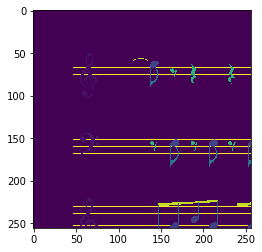

(256, 256, 137)
(1, 256, 256, 137)


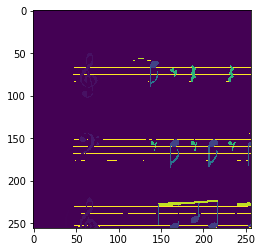

shape of mask is : (1, 256, 256, 137)


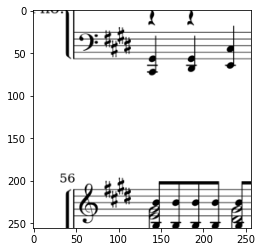

(256, 256, 137)
(1, 256, 256, 137)


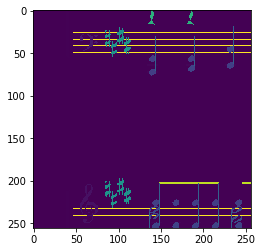

(256, 256, 137)
(1, 256, 256, 137)


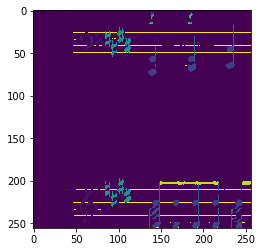

shape of mask is : (1, 256, 256, 137)


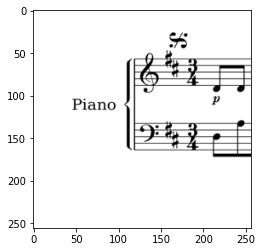

(256, 256, 137)
(1, 256, 256, 137)


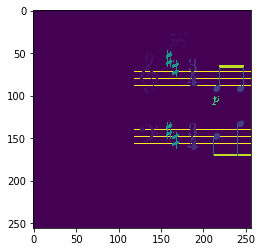

(256, 256, 137)
(1, 256, 256, 137)


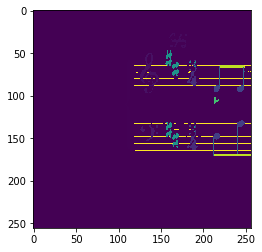

shape of mask is : (1, 256, 256, 137)


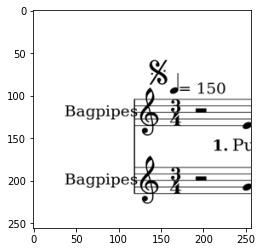

(256, 256, 137)
(1, 256, 256, 137)


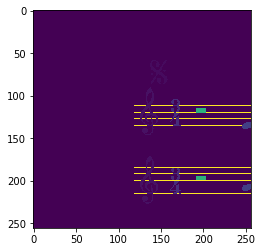

(256, 256, 137)
(1, 256, 256, 137)


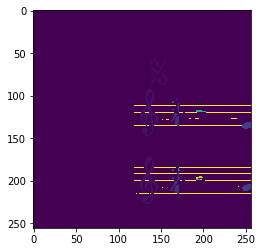

shape of mask is : (1, 256, 256, 137)


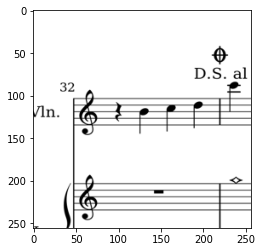

(256, 256, 137)
(1, 256, 256, 137)


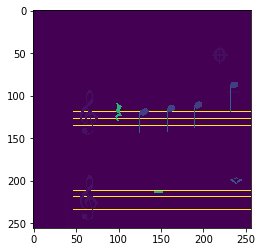

(256, 256, 137)
(1, 256, 256, 137)


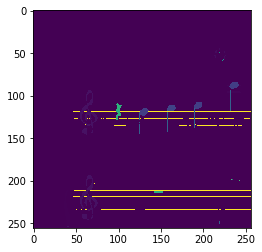

shape of mask is : (1, 256, 256, 137)


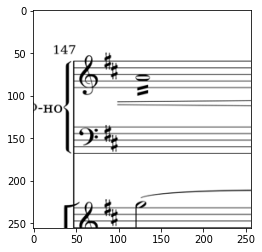

(256, 256, 137)
(1, 256, 256, 137)


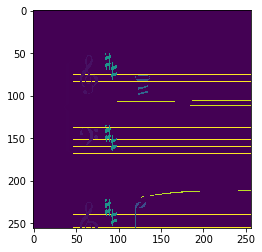

(256, 256, 137)
(1, 256, 256, 137)


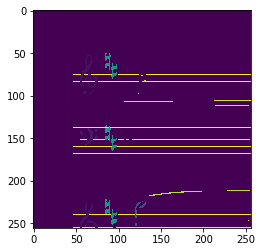

shape of mask is : (1, 256, 256, 137)


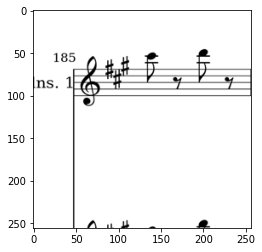

(256, 256, 137)
(1, 256, 256, 137)


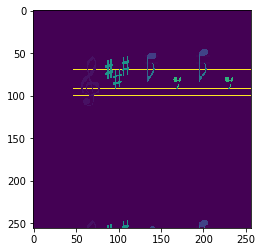

(256, 256, 137)
(1, 256, 256, 137)


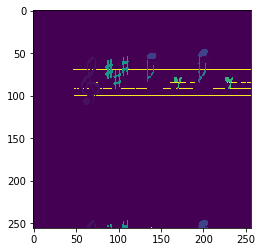

shape of mask is : (1, 256, 256, 137)


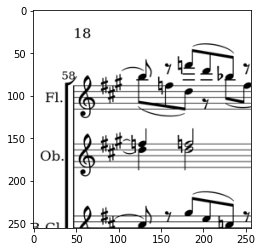

(256, 256, 137)
(1, 256, 256, 137)


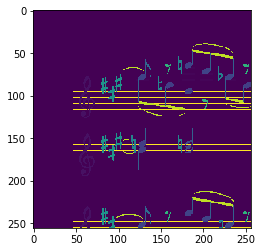

(256, 256, 137)
(1, 256, 256, 137)


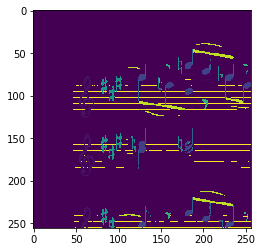

shape of mask is : (1, 256, 256, 137)


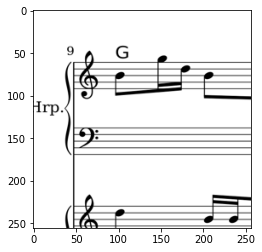

(256, 256, 137)
(1, 256, 256, 137)


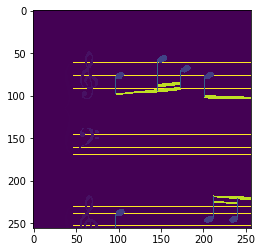

(256, 256, 137)
(1, 256, 256, 137)


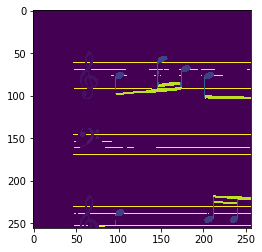

shape of mask is : (1, 256, 256, 137)


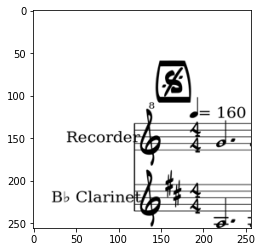

(256, 256, 137)
(1, 256, 256, 137)


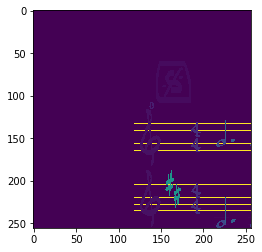

(256, 256, 137)
(1, 256, 256, 137)


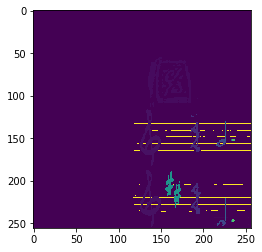

shape of mask is : (1, 256, 256, 137)


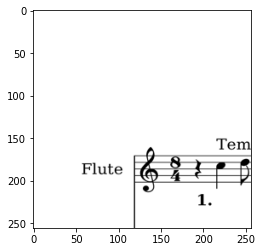

(256, 256, 137)
(1, 256, 256, 137)


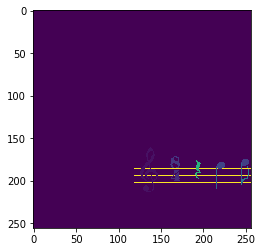

(256, 256, 137)
(1, 256, 256, 137)


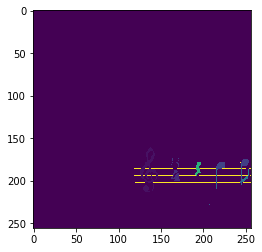

shape of mask is : (1, 256, 256, 137)


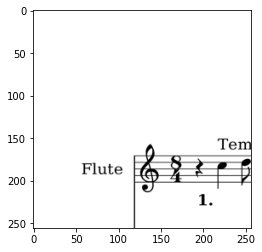

(256, 256, 137)
(1, 256, 256, 137)


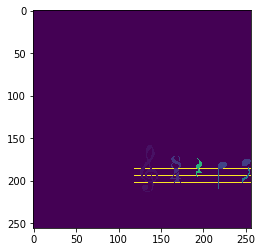

(256, 256, 137)
(1, 256, 256, 137)


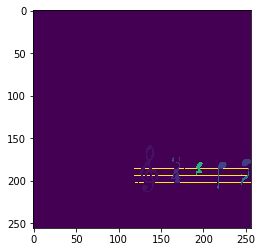

shape of mask is : (1, 256, 256, 137)


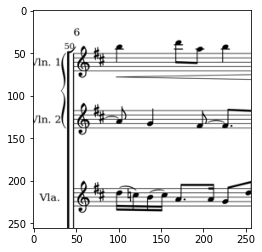

(256, 256, 137)
(1, 256, 256, 137)


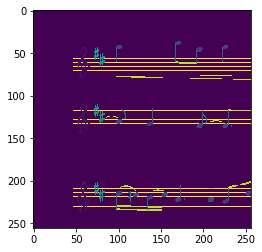

(256, 256, 137)
(1, 256, 256, 137)


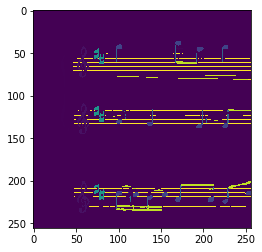

shape of mask is : (1, 256, 256, 137)


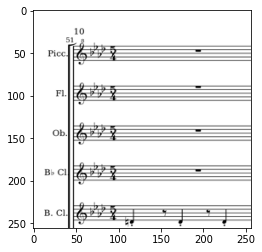

(256, 256, 137)
(1, 256, 256, 137)


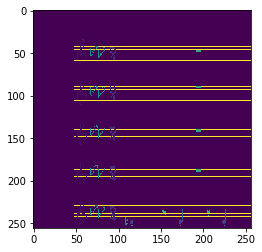

(256, 256, 137)
(1, 256, 256, 137)


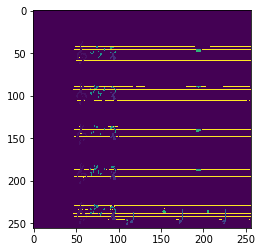

shape of mask is : (1, 256, 256, 137)


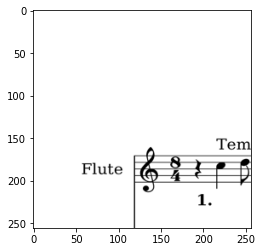

(256, 256, 137)
(1, 256, 256, 137)


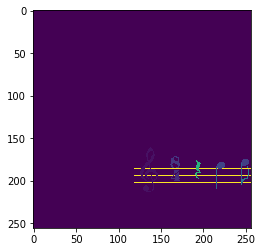

(256, 256, 137)
(1, 256, 256, 137)


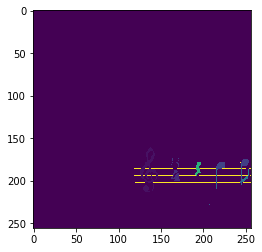

shape of mask is : (1, 256, 256, 137)


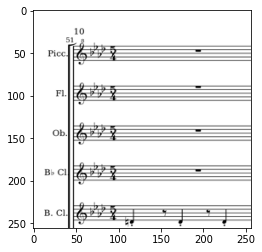

(256, 256, 137)
(1, 256, 256, 137)


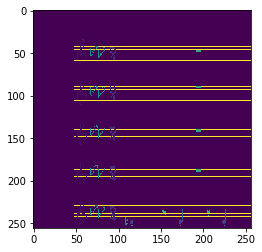

(256, 256, 137)
(1, 256, 256, 137)


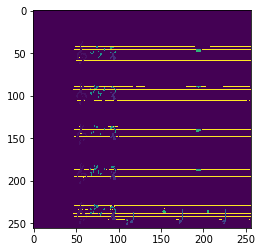

shape of mask is : (1, 256, 256, 137)


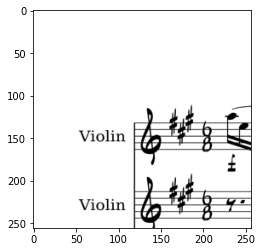

(256, 256, 137)
(1, 256, 256, 137)


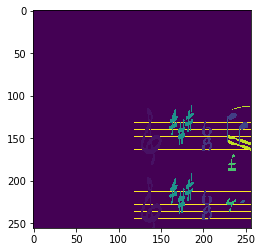

(256, 256, 137)
(1, 256, 256, 137)


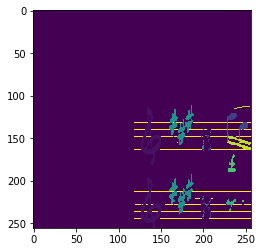

shape of mask is : (1, 256, 256, 137)


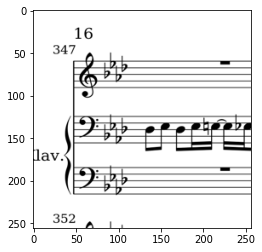

(256, 256, 137)
(1, 256, 256, 137)


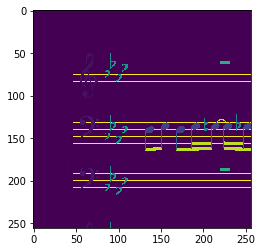

(256, 256, 137)
(1, 256, 256, 137)


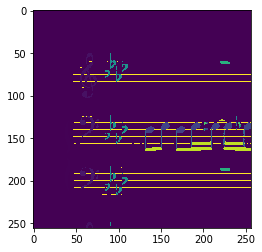

shape of mask is : (1, 256, 256, 137)


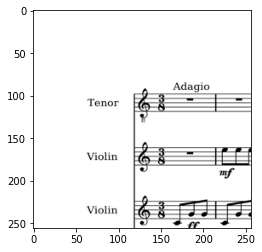

(256, 256, 137)
(1, 256, 256, 137)


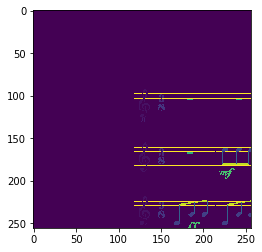

(256, 256, 137)
(1, 256, 256, 137)


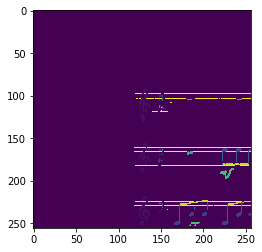

shape of mask is : (1, 256, 256, 137)


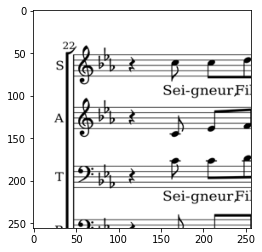

(256, 256, 137)
(1, 256, 256, 137)


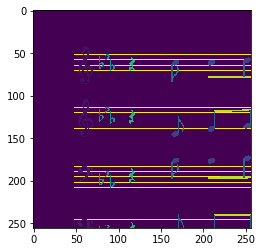

(256, 256, 137)
(1, 256, 256, 137)


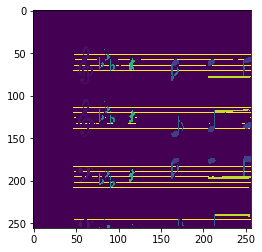

shape of mask is : (1, 256, 256, 137)


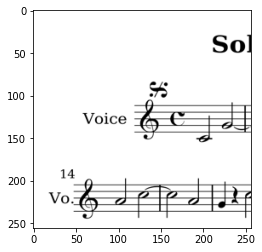

(256, 256, 137)
(1, 256, 256, 137)


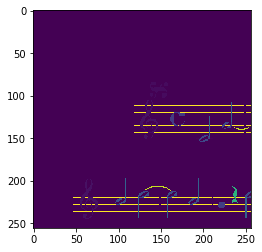

(256, 256, 137)
(1, 256, 256, 137)


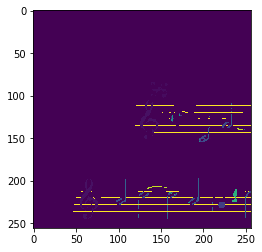

shape of mask is : (1, 256, 256, 137)


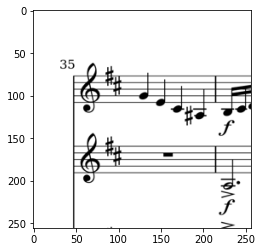

(256, 256, 137)
(1, 256, 256, 137)


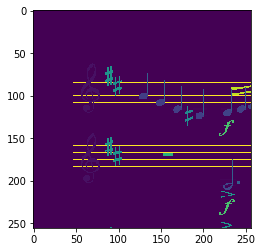

(256, 256, 137)
(1, 256, 256, 137)


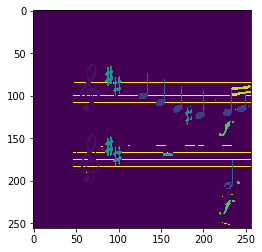

shape of mask is : (1, 256, 256, 137)


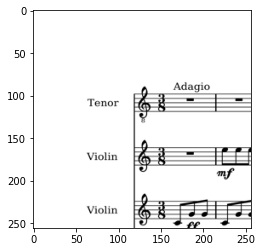

(256, 256, 137)
(1, 256, 256, 137)


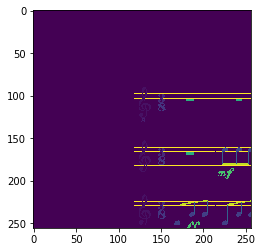

(256, 256, 137)
(1, 256, 256, 137)


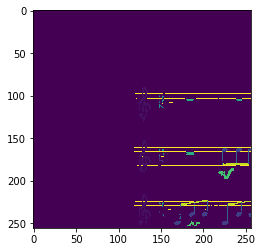

shape of mask is : (1, 256, 256, 137)


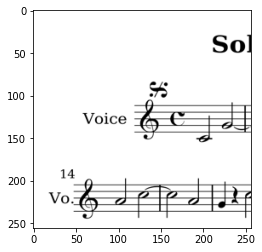

(256, 256, 137)
(1, 256, 256, 137)


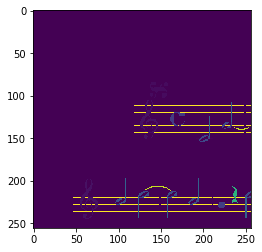

(256, 256, 137)
(1, 256, 256, 137)


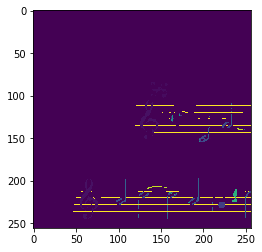

shape of mask is : (1, 256, 256, 137)


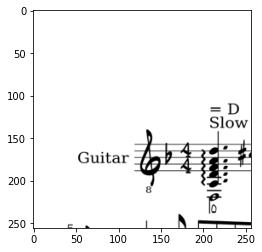

(256, 256, 137)
(1, 256, 256, 137)


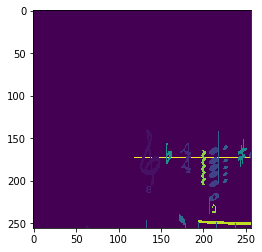

(256, 256, 137)
(1, 256, 256, 137)


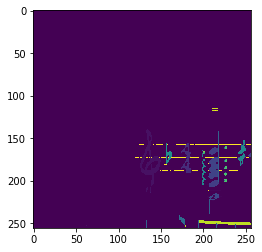

shape of mask is : (1, 256, 256, 137)


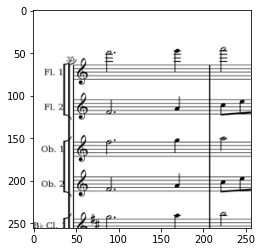

(256, 256, 137)
(1, 256, 256, 137)


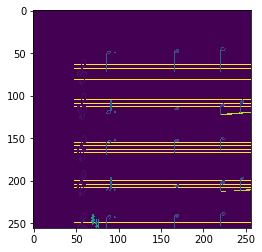

(256, 256, 137)
(1, 256, 256, 137)


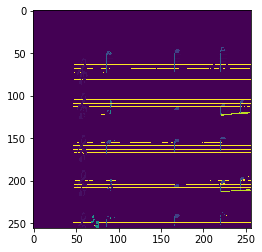

shape of mask is : (1, 256, 256, 137)


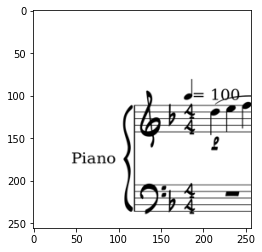

(256, 256, 137)
(1, 256, 256, 137)


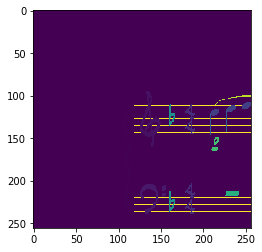

(256, 256, 137)
(1, 256, 256, 137)


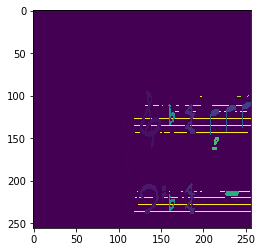

shape of mask is : (1, 256, 256, 137)


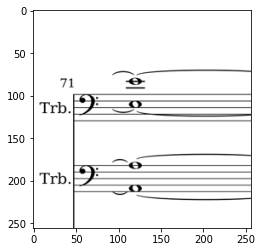

(256, 256, 137)
(1, 256, 256, 137)


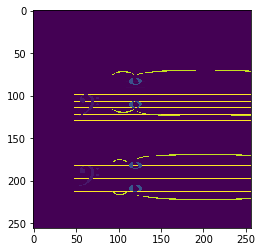

(256, 256, 137)
(1, 256, 256, 137)


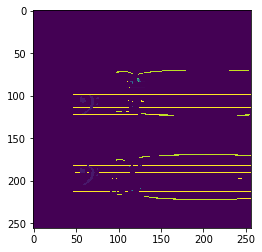

shape of mask is : (1, 256, 256, 137)


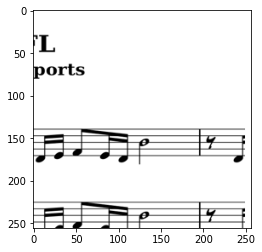

(256, 256, 137)
(1, 256, 256, 137)


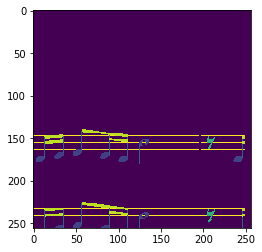

(256, 256, 137)
(1, 256, 256, 137)


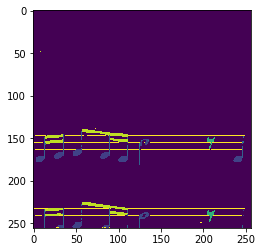

shape of mask is : (1, 256, 256, 137)


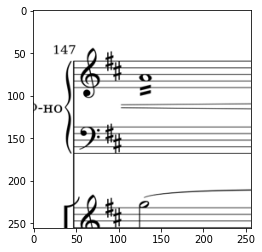

(256, 256, 137)
(1, 256, 256, 137)


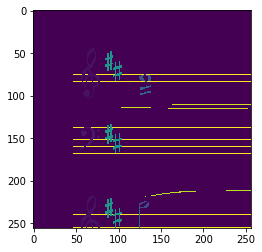

(256, 256, 137)
(1, 256, 256, 137)


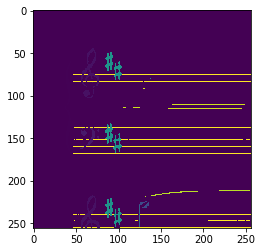

shape of mask is : (1, 256, 256, 137)


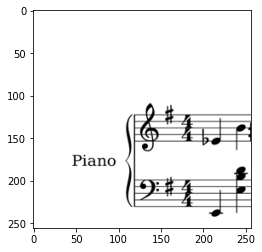

(256, 256, 137)
(1, 256, 256, 137)


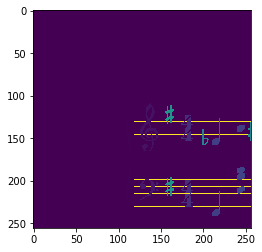

(256, 256, 137)
(1, 256, 256, 137)


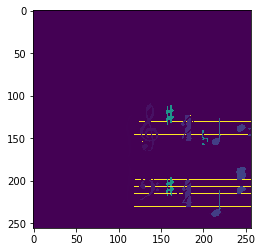

shape of mask is : (1, 256, 256, 137)


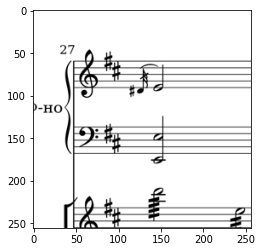

(256, 256, 137)
(1, 256, 256, 137)


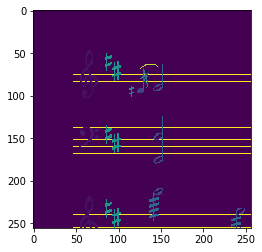

(256, 256, 137)
(1, 256, 256, 137)


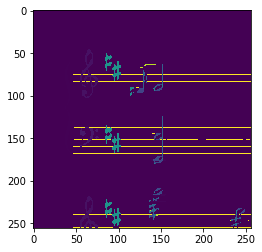

shape of mask is : (1, 256, 256, 137)


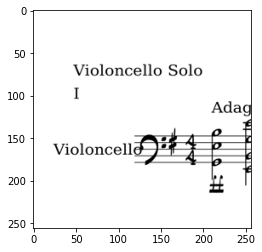

(256, 256, 137)
(1, 256, 256, 137)


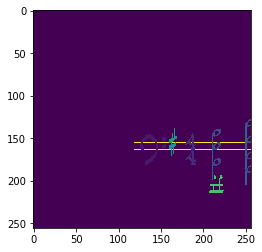

(256, 256, 137)
(1, 256, 256, 137)


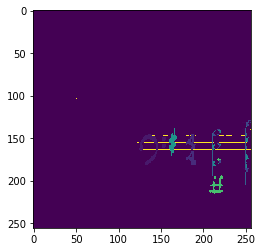

shape of mask is : (1, 256, 256, 137)


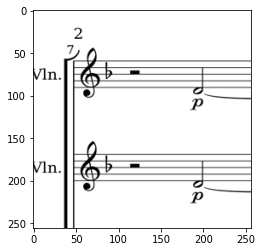

(256, 256, 137)
(1, 256, 256, 137)


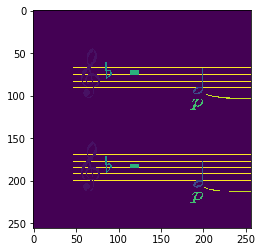

(256, 256, 137)
(1, 256, 256, 137)


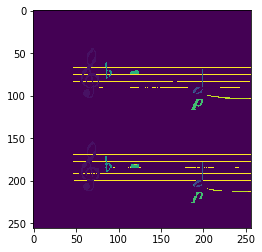

shape of mask is : (1, 256, 256, 137)


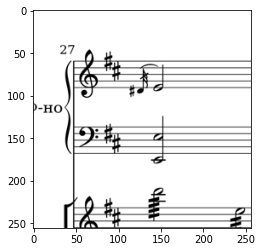

(256, 256, 137)
(1, 256, 256, 137)


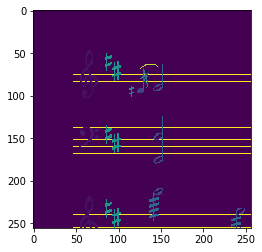

(256, 256, 137)
(1, 256, 256, 137)


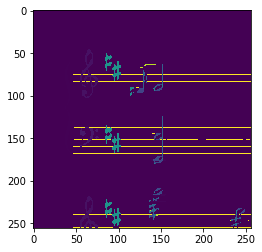

shape of mask is : (1, 256, 256, 137)


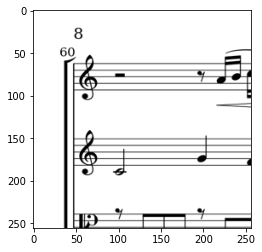

(256, 256, 137)
(1, 256, 256, 137)


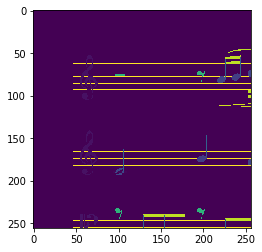

(256, 256, 137)
(1, 256, 256, 137)


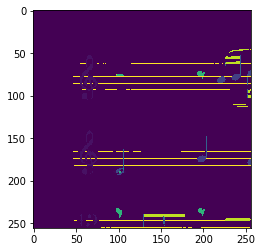

shape of mask is : (1, 256, 256, 137)


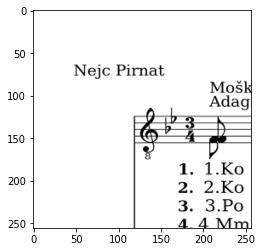

(256, 256, 137)
(1, 256, 256, 137)


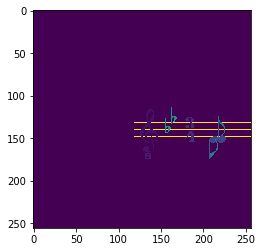

(256, 256, 137)
(1, 256, 256, 137)


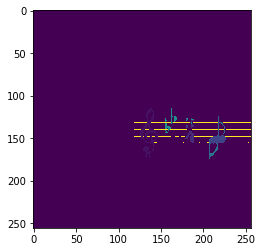

shape of mask is : (1, 256, 256, 137)


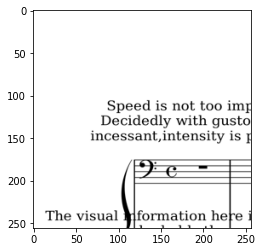

(256, 256, 137)
(1, 256, 256, 137)


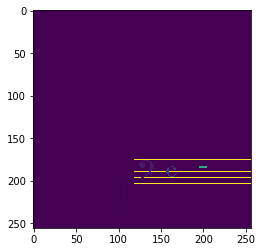

(256, 256, 137)
(1, 256, 256, 137)


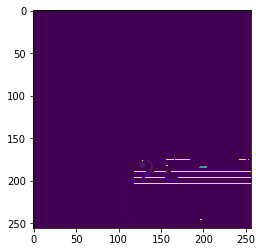

shape of mask is : (1, 256, 256, 137)


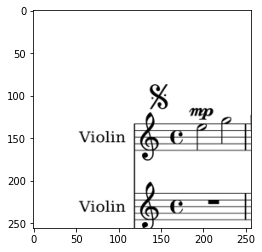

(256, 256, 137)
(1, 256, 256, 137)


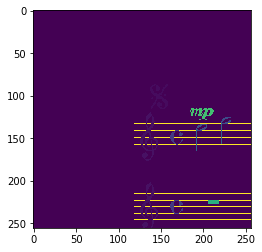

(256, 256, 137)
(1, 256, 256, 137)


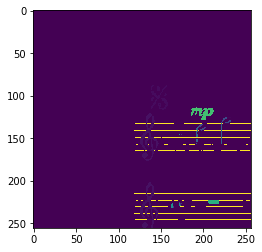

shape of mask is : (1, 256, 256, 137)


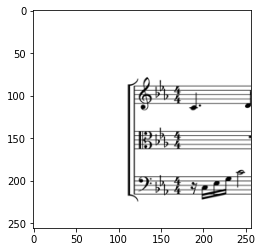

(256, 256, 137)
(1, 256, 256, 137)


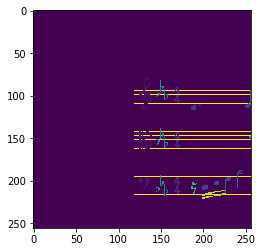

(256, 256, 137)
(1, 256, 256, 137)


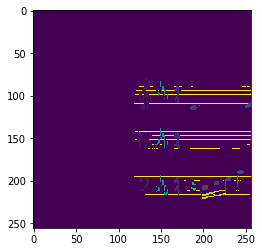

shape of mask is : (1, 256, 256, 137)


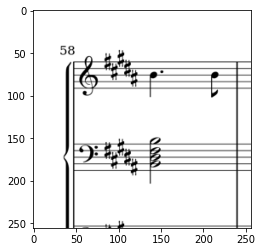

(256, 256, 137)
(1, 256, 256, 137)


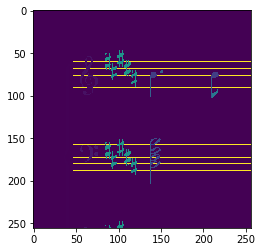

(256, 256, 137)
(1, 256, 256, 137)


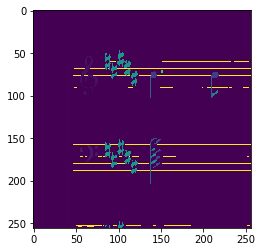

shape of mask is : (1, 256, 256, 137)


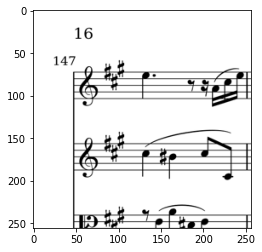

(256, 256, 137)
(1, 256, 256, 137)


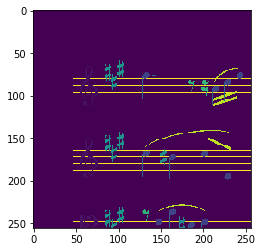

(256, 256, 137)
(1, 256, 256, 137)


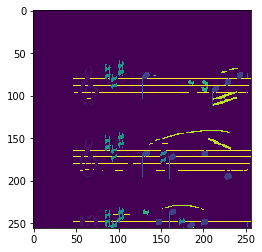

shape of mask is : (1, 256, 256, 137)


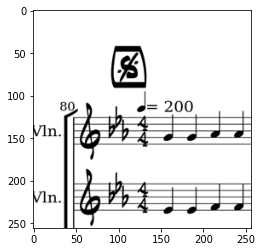

(256, 256, 137)
(1, 256, 256, 137)


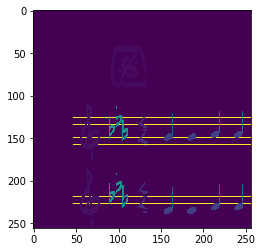

(256, 256, 137)
(1, 256, 256, 137)


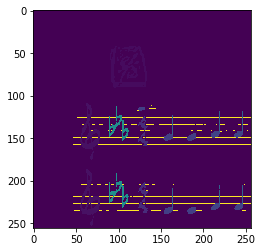

shape of mask is : (1, 256, 256, 137)


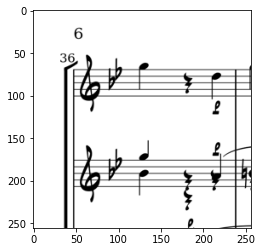

(256, 256, 137)
(1, 256, 256, 137)


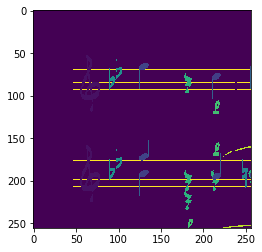

(256, 256, 137)
(1, 256, 256, 137)


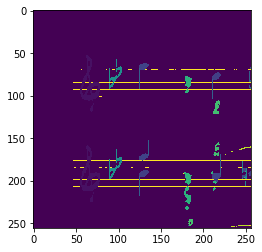

shape of mask is : (1, 256, 256, 137)


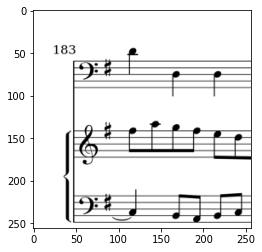

(256, 256, 137)
(1, 256, 256, 137)


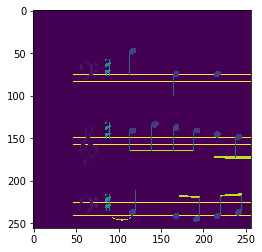

(256, 256, 137)
(1, 256, 256, 137)


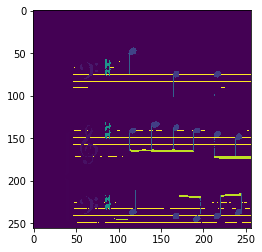

shape of mask is : (1, 256, 256, 137)


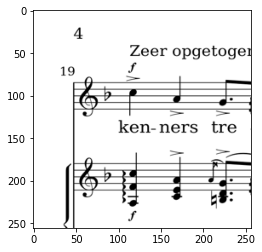

(256, 256, 137)
(1, 256, 256, 137)


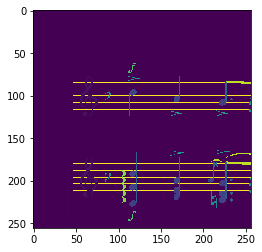

(256, 256, 137)
(1, 256, 256, 137)


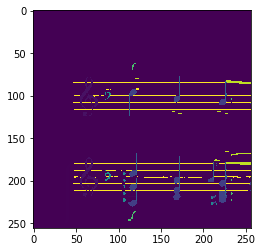

shape of mask is : (1, 256, 256, 137)


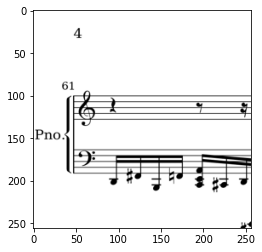

(256, 256, 137)
(1, 256, 256, 137)


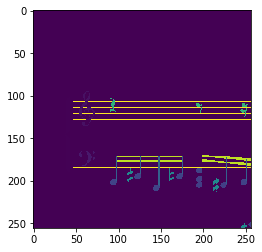

(256, 256, 137)
(1, 256, 256, 137)


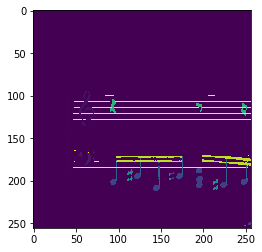

shape of mask is : (1, 256, 256, 137)


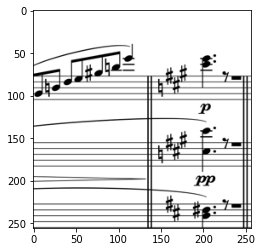

(256, 256, 137)
(1, 256, 256, 137)


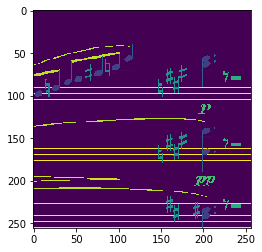

(256, 256, 137)
(1, 256, 256, 137)


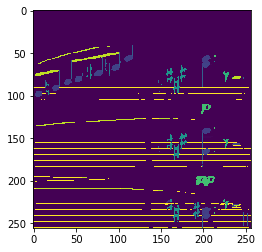

shape of mask is : (1, 256, 256, 137)


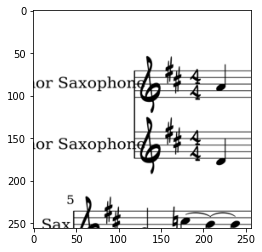

(256, 256, 137)
(1, 256, 256, 137)


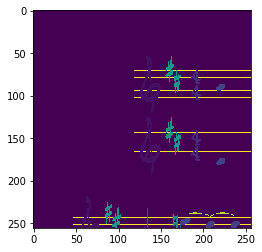

(256, 256, 137)
(1, 256, 256, 137)


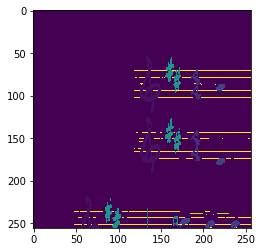

shape of mask is : (1, 256, 256, 137)


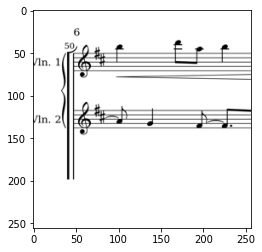

(256, 256, 137)
(1, 256, 256, 137)


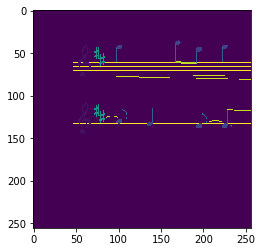

(256, 256, 137)
(1, 256, 256, 137)


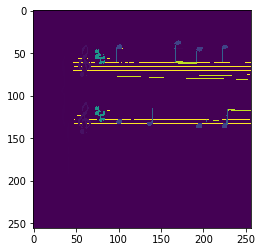

shape of mask is : (1, 256, 256, 137)


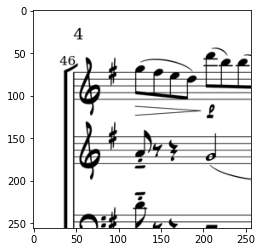

(256, 256, 137)
(1, 256, 256, 137)


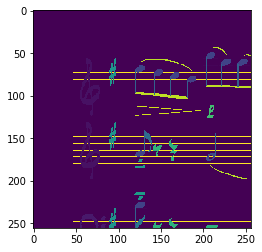

(256, 256, 137)
(1, 256, 256, 137)


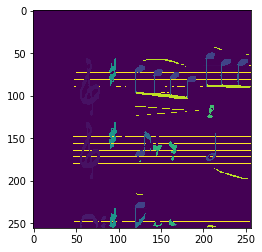

shape of mask is : (1, 256, 256, 137)


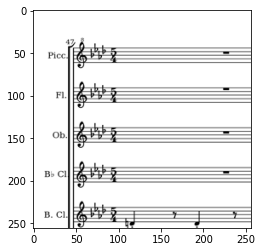

(256, 256, 137)
(1, 256, 256, 137)


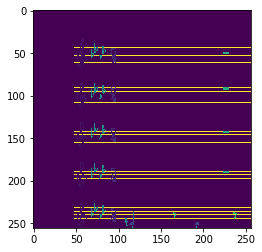

(256, 256, 137)
(1, 256, 256, 137)


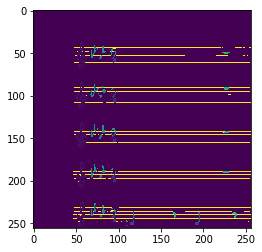

Exception ignored in: <generator object dataset_generator at 0x000001B98A7ED890>
Traceback (most recent call last):
  File "C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 796, in iterator_completed
    del self._iterators[iterator_id]
RuntimeError: generator ignored GeneratorExit


NameError: name 'model' is not defined

In [23]:
#test_dataset = tf_dataset(X_test, y_test, 1)

def create_mask(pred_mask):
  prediction = pred_mask[0]
  print(prediction.shape)
  #for i in range(136):
  #  plt.imshow(prediction[:,:,i])
  #  plt.show()
  prediction = tf.argmax(prediction, axis=-1)
  print(pred_mask.shape)


  #prediction = [..., tf.newaxis]
  #print(prediction)
  return prediction

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = resnet_model.predict(image)
      print(f'shape of mask is : {pred_mask.shape}')
      plt.imshow(image[0])
      plt.show()
      plt.imshow(create_mask(mask), interpolation='nearest')
      plt.show()
      plt.imshow(create_mask(pred_mask), interpolation='nearest')
      plt.show()
  #else:
    #display([sample_image, sample_mask,
     #        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(train_data, 136)
print(model.summary())


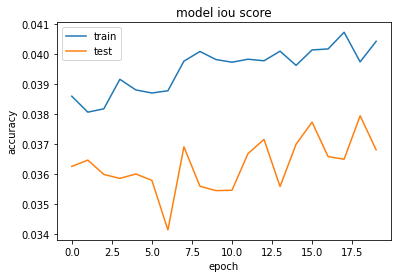

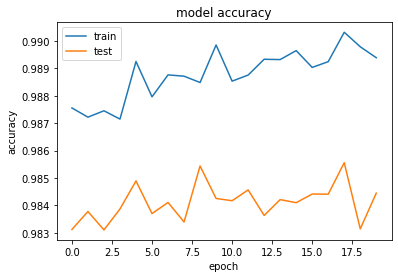

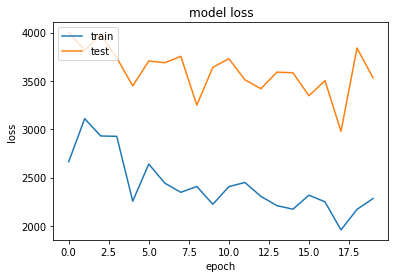

In [22]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['iou_score'])
plt.plot(model_history.history['val_iou_score'])
plt.title('model iou score')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

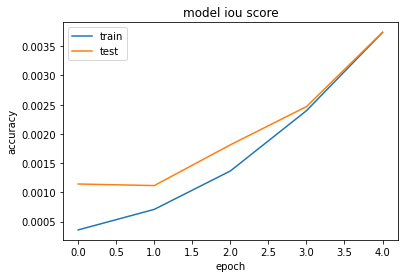

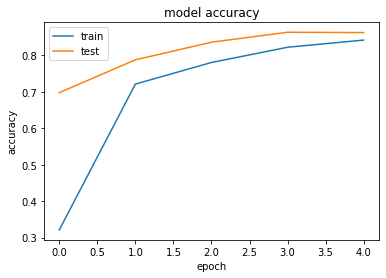

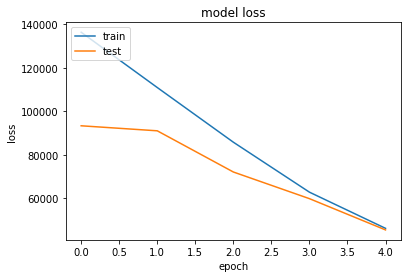

In [18]:
import matplotlib.pyplot as plt

plt.plot(model_history_mobilenet_2.history['iou_score'])
plt.plot(model_history_mobilenet_2.history['val_iou_score'])
plt.title('model iou score')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history_mobilenet_2.history['accuracy'])
plt.plot(model_history_mobilenet_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history_mobilenet_2.history['loss'])
plt.plot(model_history_mobilenet_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
import numpy as np
weights = np.loadtxt('weights.csv', delimiter=',')
print(weights)
print(len(weights))

[1.55200415e+09 7.88264000e+05 1.17455400e+06 3.39070000e+04
 8.37780000e+04 6.09660000e+04 2.55796600e+06 3.08378000e+05
 1.71481000e+05 7.43647000e+05 0.00000000e+00 3.11360000e+04
 9.22800000e+03 1.57660000e+04 3.30640000e+04 2.52140000e+04
 4.49510000e+04 2.24657000e+05 2.95900000e+03 2.19890000e+04
 1.28100000e+04 7.24690000e+04 1.90470000e+04 2.18940000e+04
 3.39650000e+04 6.54797700e+06 2.10000000e+01 6.50589600e+06
 3.00000000e+00 4.50171000e+05 2.00000000e+00 4.64741000e+05
 0.00000000e+00 2.02888000e+05 5.00000000e+00 2.26912000e+05
 0.00000000e+00 3.23990000e+04 8.00000000e+00 1.05380000e+04
 0.00000000e+00 1.76937000e+05 5.74756500e+06 8.42000000e+02
 2.98600000e+03 2.52800000e+03 9.87700000e+03 1.00000000e+01
 2.44727000e+05 0.00000000e+00 5.65620000e+04 1.13050000e+04
 2.33330000e+04 5.05970000e+04 2.90065000e+05 0.00000000e+00
 4.83710000e+04 3.69350000e+04 2.67600000e+04 4.64570000e+04
 1.86311000e+05 4.00000000e+00 3.52870000e+05 7.00000000e+00
 5.62210000e+05 2.000000

In [ ]:
print(weights)
#weights[0] = weights[0] / 1.4
#weights_list = np.zeros(137)
#for i in range(137):
#    weights_list[i] = weights[int(mapping[i])]
weights_list = np.array(weights[0:137])
weights_list[weights_list == 0] = 3
#weights_list[weights_list < 100] = 100
print(weights_list)
weights_list = weights_list / sum(weights_list)
#print(np.sum(weights_list))
print(weights_list)
median = np.median(weights_list)
weights_list = median / weights_list
print(weights_list)

#weights were too strict, so i decided to lower the deviation of them
#avg = np.mean(weights_list[weights_list != 0])
#print(avg)
#weights_list[weights_list != 0] = weights_list[weights_list != 0] + (avg - weights_list[weights_list != 0])

plt.scatter(np.arange(137), weights_list)
plt.show()

plt.ylim(0, 100000)
plt.scatter(np.arange(137), weights[0:137])
plt.show()

In [59]:
p_prime

array([6.96520697e-03, 3.53763351e-06, 5.27125632e-06, 1.52170516e-07,
       3.75985533e-07, 2.73608036e-07, 1.14798421e-05, 1.38396317e-06,
       7.69585992e-07, 3.33739781e-06, 1.34636372e-11, 1.39734603e-07,
       4.14141481e-08, 7.07559016e-08, 1.48387234e-07, 1.13157383e-07,
       2.01734652e-07, 1.00823345e-06, 1.32796342e-08, 9.86839731e-08,
       5.74897310e-08, 3.25232109e-07, 8.54806328e-08, 9.82576245e-08,
       1.52430813e-07, 2.93865290e-05, 9.42454606e-11, 2.91976745e-05,
       1.34636372e-11, 2.02031301e-06, 8.97575816e-12, 2.08570141e-06,
       1.34636372e-11, 9.10536810e-07, 2.24393954e-11, 1.01835362e-06,
       1.34636372e-11, 1.45402794e-07, 3.59030326e-11, 4.72932697e-08,
       1.34636372e-11, 7.94071861e-07, 2.57943767e-05, 3.77879418e-09,
       1.34008069e-08, 1.13453583e-08, 4.43267817e-08, 4.48787908e-11,
       1.09830518e-06, 1.34636372e-11, 2.53843416e-07, 5.07354730e-08,
       1.04715683e-07, 2.27073218e-07, 1.30177664e-06, 1.34636372e-11,
      

In [12]:
weights_list = np.array(weights[0:137])
weights_list[weights_list == 0] = 3
print(weights_list)
p_prime = (weights_list / sum(weights_list)) / 137

[1.55200415e+09 7.88264000e+05 1.17455400e+06 3.39070000e+04
 8.37780000e+04 6.09660000e+04 2.55796600e+06 3.08378000e+05
 1.71481000e+05 7.43647000e+05 3.00000000e+00 3.11360000e+04
 9.22800000e+03 1.57660000e+04 3.30640000e+04 2.52140000e+04
 4.49510000e+04 2.24657000e+05 2.95900000e+03 2.19890000e+04
 1.28100000e+04 7.24690000e+04 1.90470000e+04 2.18940000e+04
 3.39650000e+04 6.54797700e+06 2.10000000e+01 6.50589600e+06
 3.00000000e+00 4.50171000e+05 2.00000000e+00 4.64741000e+05
 3.00000000e+00 2.02888000e+05 5.00000000e+00 2.26912000e+05
 3.00000000e+00 3.23990000e+04 8.00000000e+00 1.05380000e+04
 3.00000000e+00 1.76937000e+05 5.74756500e+06 8.42000000e+02
 2.98600000e+03 2.52800000e+03 9.87700000e+03 1.00000000e+01
 2.44727000e+05 3.00000000e+00 5.65620000e+04 1.13050000e+04
 2.33330000e+04 5.05970000e+04 2.90065000e+05 3.00000000e+00
 4.83710000e+04 3.69350000e+04 2.67600000e+04 4.64570000e+04
 1.86311000e+05 4.00000000e+00 3.52870000e+05 7.00000000e+00
 5.62210000e+05 2.000000

In [ ]:
#avg = np.mean(weights_list)
#print(avg)
#weights_list = weights_list + ((avg - weights_list) / 2)
#print(weights_list)

weights_3d = np.zeros((1, 128, 128, 137))
for i in range(1):
    for j in range(128):
        for k in range(128):
            weights_3d[i][j][k] = weights_list

weights_3d = tf.convert_to_tensor(weights_3d)
print(weights_3d)

In [16]:
resnet_model.save('./BigTilesExcellent/V1')

C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./BigTilesExcellent/V1\assets


In [141]:
model_from_file.save('./NewPreprocessing/LongTrainingV3')

C:\Users\danyl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./NewPreprocessing/LongTrainingV3\assets


In [103]:
from tensorflow import keras
from segmentation_models.metrics import iou_score

model_from_file = keras.models.load_model('./NewPreprocessing/LongTrainingBetter', custom_objects = {'custom_loss' : custom_loss, 'iou_score' : iou_score})

In [ ]:
validation_dataset = tf_dataset(X_val, y_val, BATCH_SIZE)

new_model_history = model_new.fit(test_dataset, epochs=5,
                          steps_per_epoch=68,
                          validation_steps=30,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
model_new.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=custom_loss,
              metrics=['accuracy'],
              run_eagerly=False)


In [ ]:
#model_new.save('GoodModel/Ver1')

In [ ]:
import math

def custom_loss(y_true_batch, y_pred_batch):
    #y_true_batch = y_true_batch.numpy()
    #y_pred_batch = y_pred_batch.numpy()
    #print(y_pred_batch.shape)
    #y_true_batch *= 255
    #y_true_batch = y_true_batch.reshape(1, 128, 128)
    #plt.imshow(y_true_batch[0])
    #plt.show()
    y_true_batch = tf.cast(y_true_batch, tf.int32)
    #print(y_true_batch)
    #print(y_true_batch.shape)
    #print(y_true_batch)
    #print(y_true_batch.shape)

    #l = tf.math.log(tf.gather(y_pred_batch, tf.cast(y_true_batch * 255, 'int32')))
    #l = np.take_along_axis(y_pred_batch, y_true_batch, -1)
    #print(l.shape)
    #sub = [y_test_batch[]]
    #l = tf.math.log(y_pred_batch[y_true_batch])
    #y_true_np = y_true_batch.numpy()
    focal_real = tf.math.pow(tf.math.subtract(np.float64(1), y_pred_batch), 3)
    y_balance = tf.gather_nd(weights_3d, y_true_batch, batch_dims=3)
    #y_balance = tf.squeeze(tf.map_fn(fn=lambda x: weights_list[x], elems=y_true_batch, fn_output_signature=tf.float64))
    
    #focal = tf.reshape(tf.map_fn(fn=lambda x: probabilities[x], elems=y_true_np, fn_output_signature=tf.float64), [-1])
    #print(y_balance)
    #print(y_balance)
    #for i in range(137):
    #    y_balance[y_balance==i] = weights_list[i]
    #y_balance = tf.convert_to_tensor(y_balance, dtype=tf.float32)
    #y_pred_batch = tf.gather_nd(y_pred_batch, y_true_batch, batch_dims=3)
    l = tf.math.log(tf.gather_nd(y_pred_batch, y_true_batch, batch_dims=3))
    focal_real = tf.gather_nd(focal_real, y_true_batch, batch_dims=3)
    #focal = tf.math.pow(tf.math.subtract(1, y_pred_batch), 2)
    #print(l)
    #print(l.shape)
    l = tf.math.multiply(l, y_balance)
    l = tf.math.multiply(l, focal_real)
    #focal_multiplier = tf.math.subtract(1, tf.math.reduce_mean(focal))
    #l = tf.math.multiply(l, y_balance)
    #subtensor = [y_pred_batch[b, x, y] for ]
    #for y_true, y_pred in zip(y_true_batch.numpy(), y_pred_batch.numpy()):
        #l = np.log(y_pred) * 
     #   for x in range(y_pred_batch.shape[0]):
      #      for y in range(y_pred_batch.shape[1]):
       #         loss[128*x + y] = np.log(y_pred[x, y])[int(y_true[x, y])]
        #loss_val -= np.sum(loss)
    return -1 * tf.math.reduce_sum(l) #* focal_multiplier

In [10]:
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load the images and preprocess them for inception-resnet
images = []
all_filenames = listdir('musicXML/photos')
all_filenames.sort()
for filename in all_filenames:
    images.append(img_to_array(load_img('musicXML/photos/'+filename, target_size=(299, 299))))
images = np.array(images, dtype=float)
images = preprocess_input(images)
# Run the images through inception-resnet and extract the features without the classification layer
IR2 = InceptionResNetV2(weights='imagenet', include_top=False)
features = IR2.predict(images)
# We will cap each input sequence to 100 tokens
max_caption_len = 100
# Initialize the function that will create our vocabulary 
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Read a document and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
# Load all the HTML files
X = []
all_filenames = listdir('musicXML/extracted/prep')
all_filenames.sort()
for filename in all_filenames:
    X.append(load_doc('musicXML/extracted/prep/'+filename))
# Create the vocabulary from the html files
tokenizer.fit_on_texts(X)
# Add +1 to leave space for empty words
vocab_size = len(tokenizer.word_index) + 1
# Translate each word in text file to the matching vocabulary index
sequences = tokenizer.texts_to_sequences(X)
# The longest HTML file
max_length = max(len(s) for s in sequences)
# Intialize our final input to the model
X, y, image_data = list(), list(), list()
for img_no, seq in enumerate(sequences):
    for i in range(1, len(seq)):
        # Add the entire sequence to the input and only keep the next word for the output
        in_seq, out_seq = seq[:i], seq[i]
        # If the sentence is shorter than max_length, fill it up with empty words
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # Map the output to one-hot encoding
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # Add and image corresponding to the HTML file
        image_data.append(features[img_no])
        # Cut the input sentence to 100 tokens, and add it to the input data
        X.append(in_seq[-100:])
        y.append(out_seq)
X, y, image_data = np.array(X), np.array(y), np.array(image_data)
# Create the encoder
image_features = Input(shape=(8, 8, 1536,))
image_flat = Flatten()(image_features)
image_flat = Dense(128, activation='relu')(image_flat)
ir2_out = RepeatVector(max_caption_len)(image_flat)
language_input = Input(shape=(max_caption_len,))
language_model = Embedding(vocab_size, 200, input_length=max_caption_len)(language_input)
language_model = LSTM(256, return_sequences=True)(language_model)
language_model = LSTM(256, return_sequences=True)(language_model)
language_model = TimeDistributed(Dense(128, activation='relu'))(language_model)
# Create the decoder
decoder = concatenate([ir2_out, language_model])
decoder = LSTM(512, return_sequences=False)(decoder)
decoder_output = Dense(vocab_size, activation='softmax')(decoder)
# Compile the model
model = Model(inputs=[image_features, language_input], outputs=decoder_output)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
# Train the neural network
model.fit([image_data, X], y, batch_size=64, shuffle=False, epochs=2)
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'START'
    # iterate over the whole length of the sequence
    for i in range(900):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0][-100:]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # Print the prediction
        print(' ' + word, end='')
        # stop if we predict the end of the sequence
        if word == 'END':
            break
    return
# Load and image, preprocess it for IR2, extract features and generate the HTML
test_image = img_to_array(load_img('photos/1.jpg', target_size=(299, 299)))
test_image = np.array(test_image, dtype=float)
test_image = preprocess_input(test_image)
test_features = IR2.predict(np.array([test_image]))
generate_desc(model, tokenizer, np.array(test_features), 100)

NameError: name 'preprocess_input' is not defined